In [24]:
import pandas as pd
import numpy as np

import os

import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader

from sklearn.decomposition import PCA
from sklearn.manifold import TSNE

from sklearn.model_selection import train_test_split
from tqdm.auto import tqdm
from collections import Counter

import matplotlib.pyplot as plt

from IPython.display import clear_output

from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve, auc
from sklearn.metrics import f1_score
from sklearn.metrics import classification_report

from sklearn.preprocessing import StandardScaler

In [25]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
device

'cuda'

In [26]:
if 'google.colab' in str(get_ipython()):
  from google.colab import drive
  drive.mount('/content/drive')
  preprocessedDataPath = '/content/drive/Othercomputers/Компьютер/predicting-academic-performance 2.0/v2.0/preprocessed_data'
  dataPath = '/content/drive/Othercomputers/Компьютер/predicting-academic-performance 2.0/data'
else:
  preprocessedDataPath = 'preprocessed_data'
  dataPath = '../data'

In [27]:
df = pd.read_csv(os.path.join(preprocessedDataPath, 'final.csv'))

zakonchili_obuchenie_id = pd.read_csv(os.path.join(preprocessedDataPath,'zakonchili_obuchenie_id.csv'))
akademshiki_id = pd.read_csv(os.path.join(preprocessedDataPath,'akademshiki_id.csv'))
otchislennie_id = pd.read_csv(os.path.join(preprocessedDataPath,'otchislennie_id.csv'))

In [28]:
lst = pd.read_csv(os.path.join(dataPath,'lichnost.csv'))
lst.loc[lst['POL_ID'] == 2, 'POL_ID'] = 0

lst_dict_id_pol = dict(lst.groupby('GUID')['POL_ID'].min())

In [29]:
df.columns

Index(['LICHNOST_GUID', 'SEMESTR_ZAKRIT_DISC', 'BALL', 'VID_ATT_Зачет',
       'VID_ATT_Курсовая работа', 'VID_ATT_Курсовой проект', 'VID_ATT_Экзамен',
       'ISPRAV', 'ball_min', 'ball_min_sub', 'ball_max', 'ball_max_sub',
       'ball_mean', 'ball_mean_sub', 'ball_median', 'ball_median_sub',
       'percent_better_than_rest', 'min_prp', 'sub_min_prp', 'max_prp',
       'sub_max_prp', 'mean_prp', 'sub_mean_prp', 'median_prp',
       'sub_median_prp', 'DISC_CHASY'],
      dtype='object')

In [30]:
df = df.sort_values(by=['LICHNOST_GUID', 'SEMESTR_ZAKRIT_DISC'])

In [31]:
features = ['BALL', 'ISPRAV', 'VID_ATT_Зачет', 'VID_ATT_Курсовая работа', 'VID_ATT_Курсовой проект', 'VID_ATT_Экзамен', 'ball_min_sub', 'ball_max_sub', 'ball_mean_sub', 'ball_median_sub', 'percent_better_than_rest', 'sub_min_prp','sub_max_prp', 'sub_mean_prp','sub_median_prp', 'DISC_CHASY']

In [32]:
pca = PCA(n_components=1)
pca.fit(df[features])

PCA(n_components=1)

In [33]:
sc = StandardScaler()

sc.fit(pca.transform(df[features]))

StandardScaler()

In [34]:
cntr = Counter()

final_matrix = []
max_len_data = 0

for lichnost_guid, lichnost_group_data in df.groupby('LICHNOST_GUID'):
    lichnost_matrix = []

    for semestr, semestr_group_data in lichnost_group_data.groupby('SEMESTR_ZAKRIT_DISC'):
        semestr_group_data_pca = [int(lichnost_guid not in (zakonchili_obuchenie_id.to_numpy()))]
        semestr_group_data_pca.append(lst_dict_id_pol[lichnost_guid])

        semestr_group_data_pca.extend(sc.transform((pca.transform(semestr_group_data[features]))).T[0])

        cntr[f"{lichnost_guid} - {semestr}"] += len(semestr_group_data_pca) - 1

        lichnost_matrix.append(semestr_group_data_pca)

    final_matrix.append(lichnost_matrix)


In [35]:
max_subjects_per_semestr = cntr.most_common(1)[0][1]

In [36]:
max_subjects_per_semestr

43

In [37]:
def collate_fn_with_padding(semestri_vseh, pad_id=0):
    max_count_semestrs = max(len(semestri_odnogo) for semestri_odnogo in semestri_vseh)
    new_batch = []
    for semestri_odnogo in semestri_vseh:
        new_semestri_odnogo = []
        for semestr in semestri_odnogo:
            semestr += [pad_id] * (max_subjects_per_semestr + 1 - len(semestr))
            new_semestri_odnogo.append(semestr)

        for _ in range(max_count_semestrs - len(semestri_odnogo)):
            new_semestri_odnogo.append([semestri_odnogo[0][0]] + ([pad_id] * (max_subjects_per_semestr)))

        new_batch.append(new_semestri_odnogo)

    float_tensor = torch.FloatTensor(new_batch).to(device)

    new_batch = {
        'input_ids': float_tensor[:,:, 1:],
        'target_ids': float_tensor[:,:, 0]
    }

    return new_batch


In [38]:
class OcenkaDataset:
    def __init__(self, data):
        self.data = data

    def __getitem__(self, idx: int) -> list[int]:
        return self.data[idx]

    def __len__(self) -> int:
        return len(self.data)

In [39]:
train_ocenka, eval_ocenka = train_test_split(final_matrix, test_size=0.2)
# eval_ocenka, test_ocenka = train_test_split(eval_ocenka, test_size=0.5)

train_dataset = OcenkaDataset(train_ocenka)
eval_dataset = OcenkaDataset(eval_ocenka)
# test_dataset = OcenkaDataset(test_ocenka)

batch_size = 1

train_dataloader = DataLoader(
    train_dataset, collate_fn=collate_fn_with_padding, batch_size=batch_size)

eval_dataloader = DataLoader(
    eval_dataset, collate_fn=collate_fn_with_padding, batch_size=batch_size)

# test_dataloader = DataLoader(
#     test_dataset, collate_fn=collate_fn_with_padding, batch_size=batch_size)

In [45]:
class OtchislenieModel_GRU(nn.Module): # Базовая модель
    def __init__(self, hidden_dim, input_size, num_classes):
        super().__init__()
        self.input_linear = nn.Linear(input_size, hidden_dim)
        self.non_lin = nn.Tanh()
        self.rnn = nn.GRU(hidden_dim, hidden_dim, batch_first=True)
        self.linear = nn.Linear(hidden_dim, hidden_dim)
        self.projection = nn.Linear(hidden_dim, num_classes)

        self.non_lin = nn.Tanh()
        self.dropout = nn.Dropout(p=0.1)

        self.sigmoid = nn.Sigmoid()

    def forward(self, x) -> torch.Tensor:
        x = self.input_linear(x)
        x = self.non_lin(x)
        x, _ = self.rnn(x)
        x = self.non_lin(x)
        x = self.dropout(x)
        x = self.linear(x)
        x = self.non_lin(x)
        x = self.projection(x)
        x = self.non_lin(x)
        x = self.sigmoid(x)

        return x

class OtchislenieModel_LSTM(nn.Module): # Базовая модель
    def __init__(self, hidden_dim, input_size, num_classes):
        super().__init__()
        self.input_linear = nn.Linear(input_size, hidden_dim)
        self.non_lin = nn.Tanh()
        self.rnn = nn.LSTM(hidden_dim, hidden_dim, batch_first=True)
        self.linear = nn.Linear(hidden_dim, hidden_dim)
        self.projection = nn.Linear(hidden_dim, num_classes)

        self.non_lin = nn.Tanh()
        self.dropout = nn.Dropout(p=0.1)

        self.sigmoid = nn.Sigmoid()

    def forward(self, x) -> torch.Tensor:
        x = self.input_linear(x)
        x = self.non_lin(x)
        x, _ = self.rnn(x)
        x = self.non_lin(x)
        x = self.dropout(x)
        x = self.linear(x)
        x = self.non_lin(x)
        x = self.projection(x)
        x = self.non_lin(x)
        x = self.sigmoid(x)

        return x

class OtchislenieModel(nn.Module): # Базовая модель
    def __init__(self, hidden_dim, input_size, num_classes):
        super().__init__()
        self.input_linear = nn.Linear(input_size, hidden_dim)
        self.non_lin = nn.Tanh()
        self.rnn = nn.RNN(hidden_dim, hidden_dim, batch_first=True)
        self.linear = nn.Linear(hidden_dim, hidden_dim)
        self.projection = nn.Linear(hidden_dim, num_classes)

        self.non_lin = nn.Tanh()
        self.dropout = nn.Dropout(p=0.1)

        self.sigmoid = nn.Sigmoid()

    def forward(self, x) -> torch.Tensor:
        x = self.input_linear(x)
        x = self.non_lin(x)
        x, _ = self.rnn(x)
        x = self.non_lin(x)
        x = self.dropout(x)
        x = self.linear(x)
        x = self.non_lin(x)
        x = self.projection(x)
        x = self.non_lin(x)
        x = self.sigmoid(x)

        return x
        
class OtchislenieModel_CustomStructure(nn.Module): # Кастомная модель
    def __init__(self, input_size, num_classes):
        super().__init__()
        self.input_linear = nn.Linear(input_size, 512)
        self.non_lin = nn.Tanh()
        self.rnn = nn.RNN(512, 256, batch_first=True)
        self.non_lin = nn.Tanh()
        self.linear = nn.Linear(256, 128)
        self.dropout = nn.Dropout(p=0.1)
        self.non_lin = nn.Tanh()
        self.projection = nn.Linear(128, num_classes)
        self.sigmoid = nn.Sigmoid()

    def forward(self, x) -> torch.Tensor:
        x = self.input_linear(x)
        x = self.non_lin(x)
        x, _ = self.rnn(x)
        x = self.non_lin(x)
        x = self.linear(x)
        x = self.dropout(x)
        x = self.non_lin(x)
        x = self.projection(x)
        x = self.sigmoid(x)

        return x

class OtchislenieModel_GRU_CustomStructure(nn.Module): # Кастомная модель
    def __init__(self, input_size, num_classes):
        super().__init__()
        self.input_linear = nn.Linear(input_size, 512)
        self.non_lin = nn.Tanh()
        self.rnn = nn.GRU(512, 256, batch_first=True)
        self.non_lin = nn.Tanh()
        self.linear = nn.Linear(256, 128)
        self.dropout = nn.Dropout(p=0.1)
        self.non_lin = nn.Tanh()
        self.projection = nn.Linear(128, num_classes)
        self.sigmoid = nn.Sigmoid()

    def forward(self, x) -> torch.Tensor:
        x = self.input_linear(x)
        x = self.non_lin(x)
        x, _ = self.rnn(x)
        x = self.non_lin(x)
        x = self.linear(x)
        x = self.dropout(x)
        x = self.non_lin(x)
        x = self.projection(x)
        x = self.sigmoid(x)

        return x

class OtchislenieModel_LSTM_CustomStructure(nn.Module): # Кастомная модель
    def __init__(self, input_size, num_classes):
        super().__init__()
        self.input_linear = nn.Linear(input_size, 512)
        self.non_lin = nn.Tanh()
        self.rnn = nn.LSTM(512, 256, batch_first=True)
        self.non_lin = nn.Tanh()
        self.linear = nn.Linear(256, 128)
        self.dropout = nn.Dropout(p=0.1)
        self.non_lin = nn.Tanh()
        self.projection = nn.Linear(128, num_classes)
        self.sigmoid = nn.Sigmoid()

    def forward(self, x) -> torch.Tensor:
        x = self.input_linear(x)
        x = self.non_lin(x)
        x, _ = self.rnn(x)
        x = self.non_lin(x)
        x = self.linear(x)
        x = self.dropout(x)
        x = self.non_lin(x)
        x = self.projection(x)
        x = self.sigmoid(x)

        return x

In [46]:
def show_loss_f1_auc_graphs(losses, f1s, fpr, tpr, thresholds): # Создание трех графиков
    epochs = np.arange(1, len(losses)+1)

    fig, axs = plt.subplots(1, 3, figsize=(12, 5))

    axs[0].plot(epochs, losses, color='blue')
    axs[0].set_title('Losses')
    axs[0].set_xlabel('Epoch')

    axs[1].plot(epochs, f1s, color='red')
    axs[1].set_title('F1')
    axs[1].set_xlabel('Epoch')

    roc_auc = auc(fpr, tpr)

    axs[2].plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
    axs[2].plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    axs[2].set_xlim([0.0, 1.0])
    axs[2].set_ylim([0.0, 1.05])
    axs[2].set_xlabel('False Positive Rate')
    axs[2].set_ylabel('True Positive Rate')
    axs[2].set_title('Receiver Operating Characteristic (ROC)')

    plt.tight_layout()
    plt.show()

In [47]:
def evaluate(model, dataloader):
    model.eval()
    logits = []
    y_trues = []
    with torch.no_grad():
        for batch in tqdm(dataloader, desc=f'Testing'):
            logit = torch.round(model(batch['input_ids']).cpu().flatten()[-1])
            y_true = batch['target_ids'].cpu().flatten()[-1]
            logits.append(logit)
            y_trues.append(y_true)

    return y_trues, logits

In [48]:
def train_model(model, optimizer, criterion, num_epoch=25):
    losses = []
    f1s = []
    rocs = []

    for epoch in range(num_epoch):
        epoch_losses = []
        model.train()
        for batch in tqdm(train_dataloader, desc=f'Training epoch {epoch+1}'):
            optimizer.zero_grad()
            logits = model(batch['input_ids']).flatten()
            loss = criterion(logits, batch['target_ids'].flatten())
            loss.backward()
            optimizer.step()

            epoch_losses.append(loss.item())

        losses.append(sum(epoch_losses) / len(epoch_losses))
        y_true, y_pred = evaluate(model, eval_dataloader)
        print(classification_report(y_true, y_pred))
        f1s.append(f1_score(y_true, y_pred))
        rocs.append(roc_auc_score(y_true, y_pred))

        # clear_output(wait=True)
        print(f'Min Loss = {min(losses)}, Curr F1 = {f1s[-1]}, Max F1 = {max(f1s)}, Curr AUC_ROC = {rocs[-1]}, Max AUC_ROC = {max(rocs)}')
        fpr, tpr, thresholds = roc_curve(y_true, y_pred)
        show_loss_f1_auc_graphs(losses, f1s, fpr, tpr, thresholds)

    return model

Vanilla RNN Base Structure

Training epoch 1:   0%|          | 0/10902 [00:00<?, ?it/s]

Testing:   0%|          | 0/2726 [00:00<?, ?it/s]

C:\Users\fluke\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\fluke\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\fluke\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\metrics\_classification.py:1471

              precision    recall  f1-score   support

         0.0       0.00      0.00      0.00      1252
         1.0       0.54      1.00      0.70      1474

    accuracy                           0.54      2726
   macro avg       0.27      0.50      0.35      2726
weighted avg       0.29      0.54      0.38      2726

Min Loss = 0.6978255163948595, Curr F1 = 0.701904761904762, Max F1 = 0.701904761904762, Curr AUC_ROC = 0.5, Max AUC_ROC = 0.5


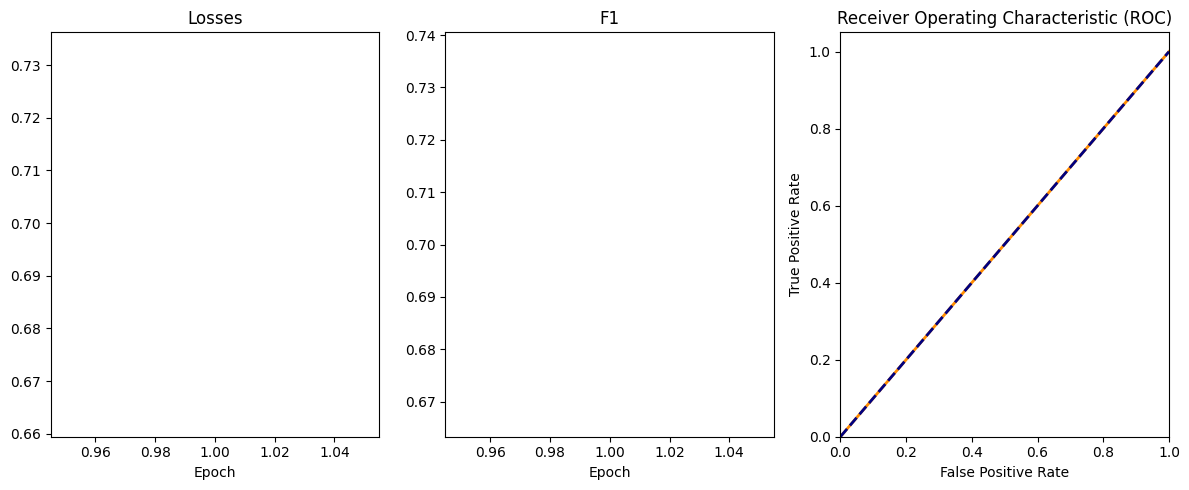

Training epoch 2:   0%|          | 0/10902 [00:00<?, ?it/s]

Testing:   0%|          | 0/2726 [00:00<?, ?it/s]

              precision    recall  f1-score   support

         0.0       0.58      1.00      0.73      1252
         1.0       0.99      0.39      0.56      1474

    accuracy                           0.67      2726
   macro avg       0.79      0.69      0.64      2726
weighted avg       0.80      0.67      0.64      2726

Min Loss = 0.6618368198425042, Curr F1 = 0.5555012224938876, Max F1 = 0.701904761904762, Curr AUC_ROC = 0.6914749155760552, Max AUC_ROC = 0.6914749155760552


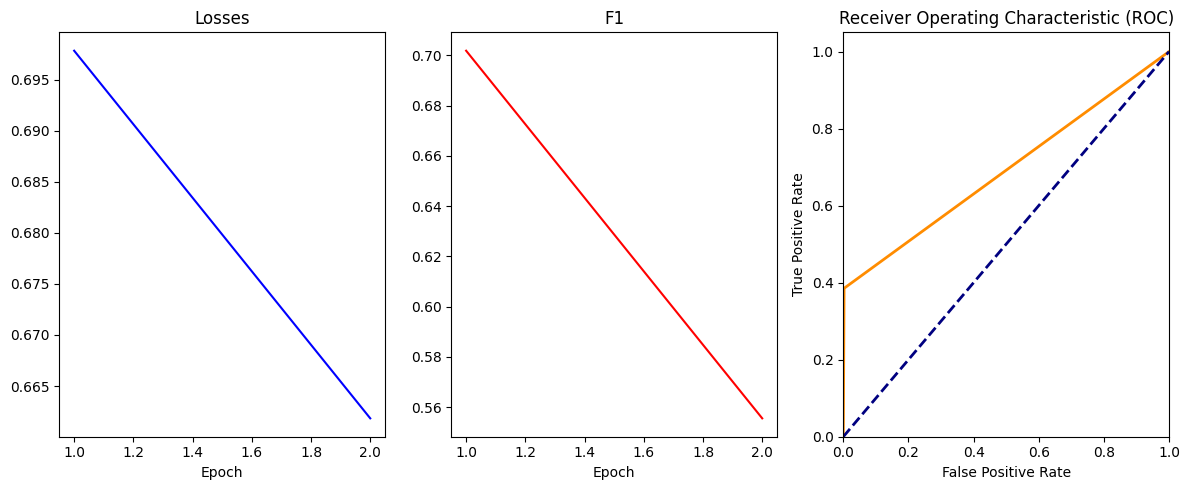

Training epoch 3:   0%|          | 0/10902 [00:00<?, ?it/s]

Testing:   0%|          | 0/2726 [00:00<?, ?it/s]

              precision    recall  f1-score   support

         0.0       0.63      0.98      0.77      1252
         1.0       0.97      0.51      0.67      1474

    accuracy                           0.73      2726
   macro avg       0.80      0.75      0.72      2726
weighted avg       0.82      0.73      0.72      2726

Min Loss = 0.6232125126748014, Curr F1 = 0.672872340425532, Max F1 = 0.701904761904762, Curr AUC_ROC = 0.7482773830527871, Max AUC_ROC = 0.7482773830527871


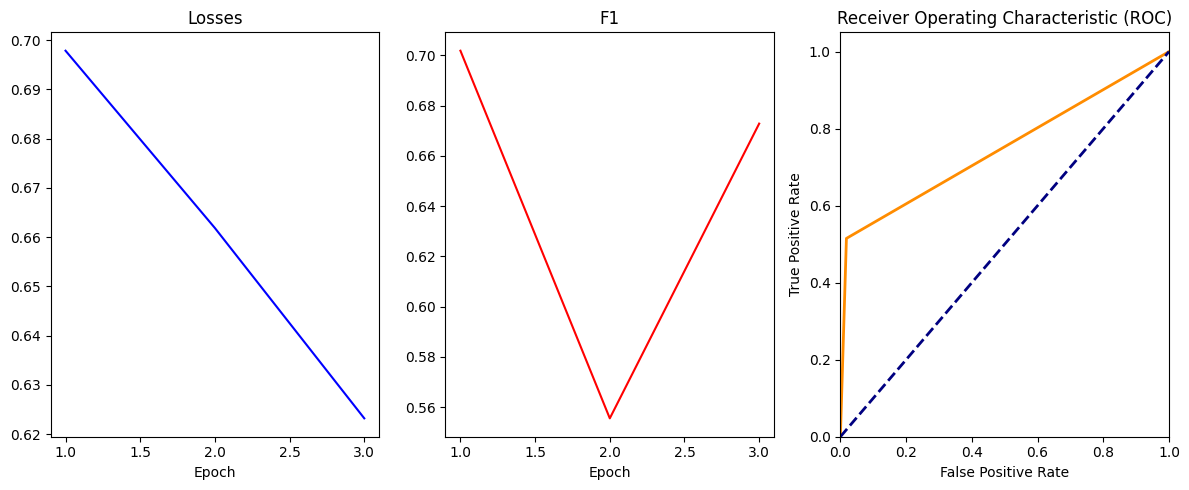

Training epoch 4:   0%|          | 0/10902 [00:00<?, ?it/s]

Testing:   0%|          | 0/2726 [00:00<?, ?it/s]

              precision    recall  f1-score   support

         0.0       0.63      1.00      0.77      1252
         1.0       0.99      0.50      0.67      1474

    accuracy                           0.73      2726
   macro avg       0.81      0.75      0.72      2726
weighted avg       0.83      0.73      0.71      2726

Min Loss = 0.6138862773784255, Curr F1 = 0.6669671022983326, Max F1 = 0.701904761904762, Curr AUC_ROC = 0.7490208339655196, Max AUC_ROC = 0.7490208339655196


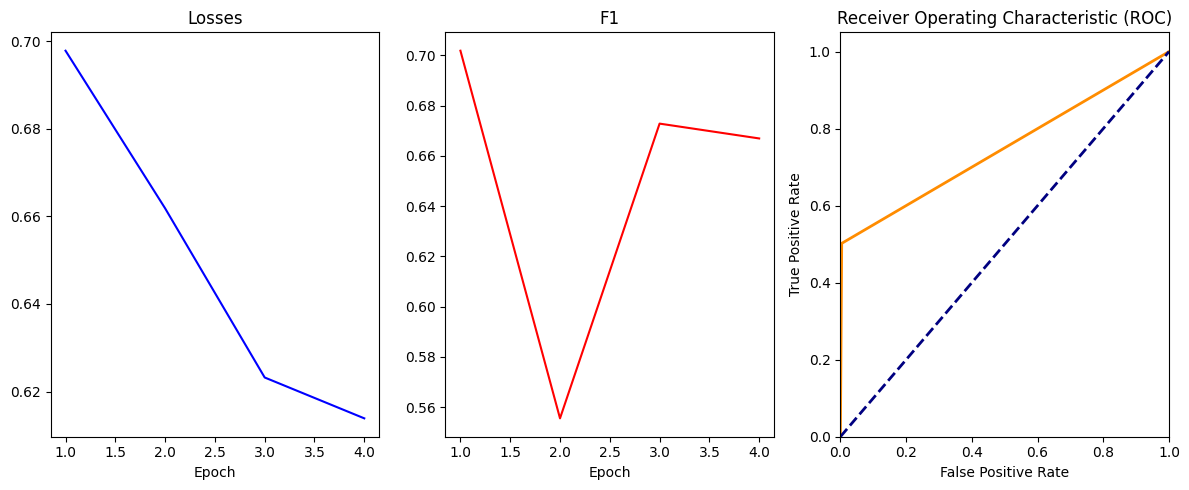

Training epoch 5:   0%|          | 0/10902 [00:00<?, ?it/s]

Testing:   0%|          | 0/2726 [00:00<?, ?it/s]

              precision    recall  f1-score   support

         0.0       0.64      0.88      0.74      1252
         1.0       0.85      0.58      0.69      1474

    accuracy                           0.72      2726
   macro avg       0.75      0.73      0.72      2726
weighted avg       0.75      0.72      0.71      2726

Min Loss = 0.6127582731908056, Curr F1 = 0.6913779210314263, Max F1 = 0.701904761904762, Curr AUC_ROC = 0.7311406227647703, Max AUC_ROC = 0.7490208339655196


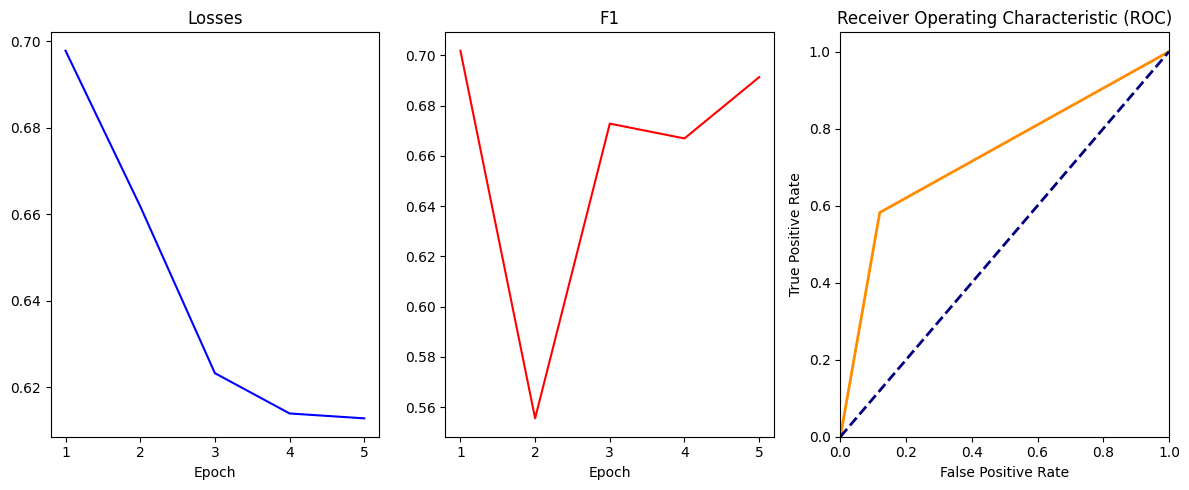

Training epoch 6:   0%|          | 0/10902 [00:00<?, ?it/s]

Testing:   0%|          | 0/2726 [00:00<?, ?it/s]

              precision    recall  f1-score   support

         0.0       0.62      1.00      0.76      1252
         1.0       1.00      0.48      0.65      1474

    accuracy                           0.72      2726
   macro avg       0.81      0.74      0.70      2726
weighted avg       0.82      0.72      0.70      2726

Min Loss = 0.6082918280074409, Curr F1 = 0.6455754241173773, Max F1 = 0.701904761904762, Curr AUC_ROC = 0.7376078870821612, Max AUC_ROC = 0.7490208339655196


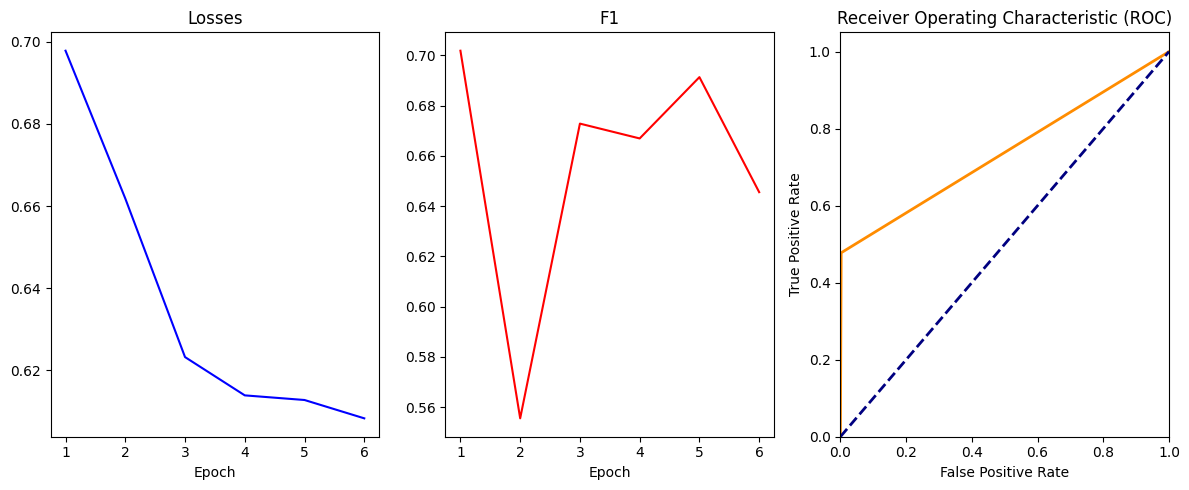

Training epoch 7:   0%|          | 0/10902 [00:00<?, ?it/s]

Testing:   0%|          | 0/2726 [00:00<?, ?it/s]

              precision    recall  f1-score   support

         0.0       0.64      0.98      0.78      1252
         1.0       0.98      0.53      0.69      1474

    accuracy                           0.74      2726
   macro avg       0.81      0.76      0.73      2726
weighted avg       0.82      0.74      0.73      2726

Min Loss = 0.605748611021055, Curr F1 = 0.6883230904302019, Max F1 = 0.701904761904762, Curr AUC_ROC = 0.7579557917643847, Max AUC_ROC = 0.7579557917643847


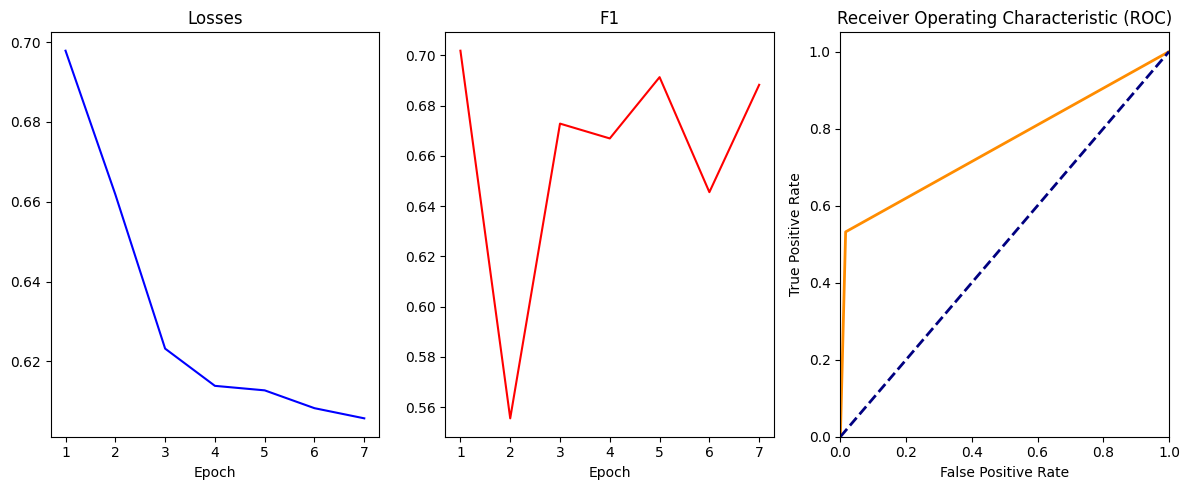

Training epoch 8:   0%|          | 0/10902 [00:00<?, ?it/s]

Testing:   0%|          | 0/2726 [00:00<?, ?it/s]

              precision    recall  f1-score   support

         0.0       0.65      0.99      0.78      1252
         1.0       0.98      0.55      0.70      1474

    accuracy                           0.75      2726
   macro avg       0.82      0.77      0.74      2726
weighted avg       0.83      0.75      0.74      2726

Min Loss = 0.6006507382433779, Curr F1 = 0.7032679738562091, Max F1 = 0.7032679738562091, Curr AUC_ROC = 0.7681538574915143, Max AUC_ROC = 0.7681538574915143


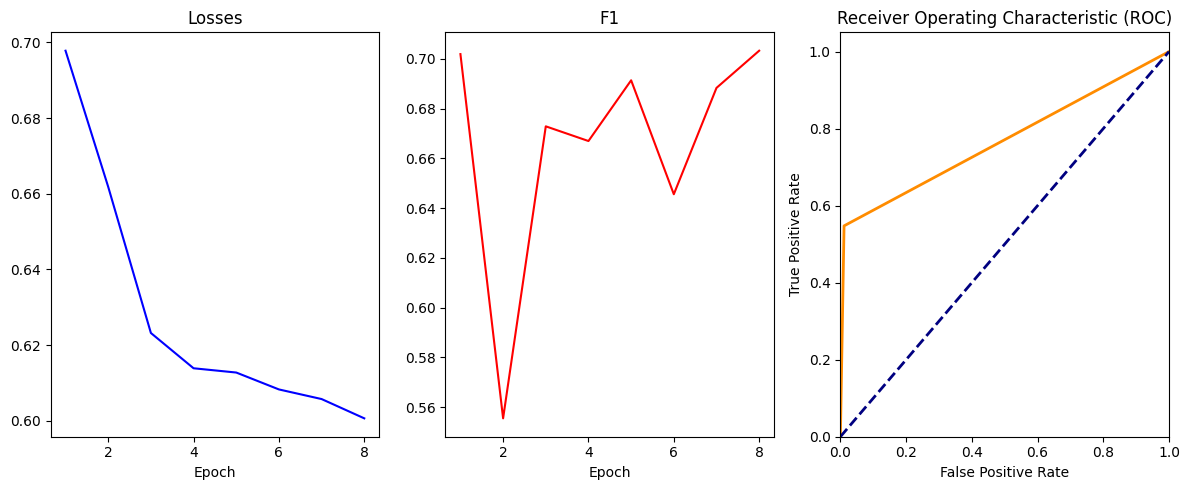

Training epoch 9:   0%|          | 0/10902 [00:00<?, ?it/s]

Testing:   0%|          | 0/2726 [00:00<?, ?it/s]

              precision    recall  f1-score   support

         0.0       0.60      0.99      0.75      1252
         1.0       0.99      0.45      0.61      1474

    accuracy                           0.70      2726
   macro avg       0.79      0.72      0.68      2726
weighted avg       0.81      0.70      0.68      2726

Min Loss = 0.600072301436271, Curr F1 = 0.6137319009808502, Max F1 = 0.7032679738562091, Curr AUC_ROC = 0.7188693477139426, Max AUC_ROC = 0.7681538574915143


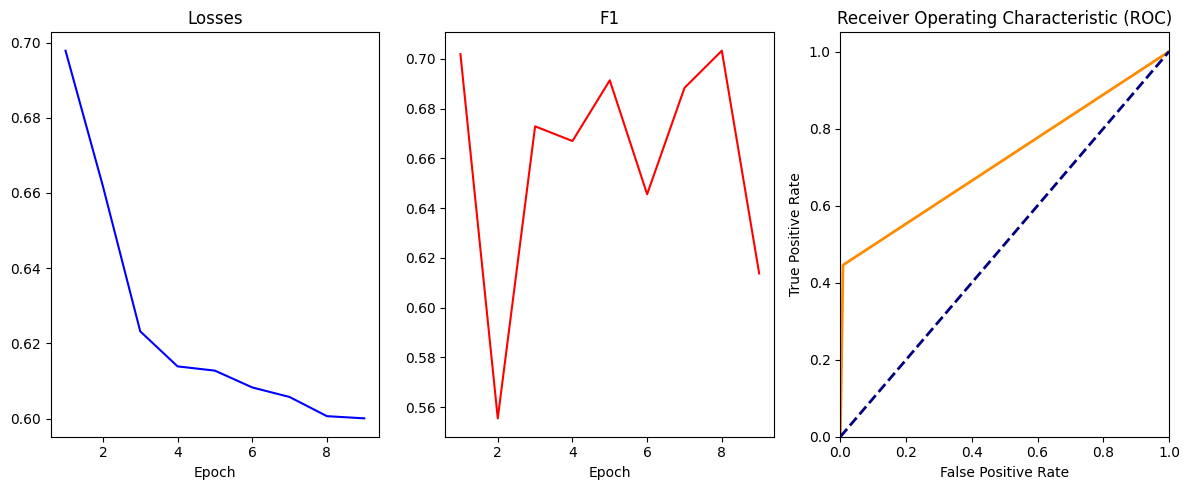

Training epoch 10:   0%|          | 0/10902 [00:00<?, ?it/s]

Testing:   0%|          | 0/2726 [00:00<?, ?it/s]

              precision    recall  f1-score   support

         0.0       0.62      0.99      0.76      1252
         1.0       0.99      0.48      0.64      1474

    accuracy                           0.71      2726
   macro avg       0.80      0.73      0.70      2726
weighted avg       0.82      0.71      0.70      2726

Min Loss = 0.5967503439295382, Curr F1 = 0.6416475972540046, Max F1 = 0.7032679738562091, Curr AUC_ROC = 0.7337947208482709, Max AUC_ROC = 0.7681538574915143


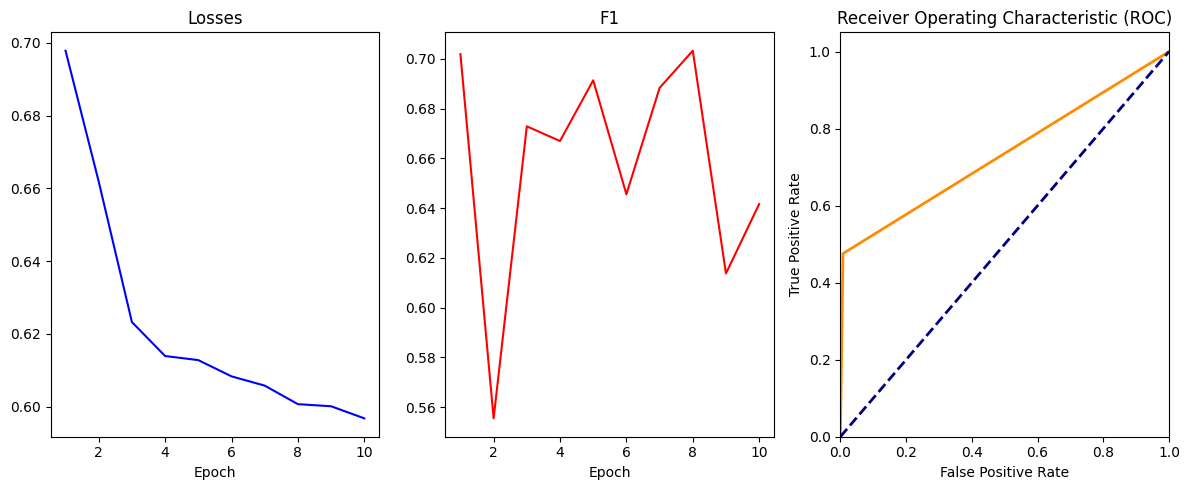

In [49]:
model_rnn = OtchislenieModel(hidden_dim=256, input_size=max_subjects_per_semestr, num_classes = 1).to(device)
criterion = nn.BCELoss()
optimizer = torch.optim.Adam(model_rnn.parameters())

model_rnn = train_model(model_rnn, optimizer, criterion, num_epoch=10)

Training epoch 1:   0%|          | 0/10902 [00:00<?, ?it/s]

Testing:   0%|          | 0/2726 [00:00<?, ?it/s]

              precision    recall  f1-score   support

         0.0       0.60      0.99      0.74      1252
         1.0       0.97      0.44      0.60      1474

    accuracy                           0.69      2726
   macro avg       0.79      0.71      0.67      2726
weighted avg       0.80      0.69      0.67      2726

Min Loss = 0.6046720892190933, Curr F1 = 0.6049555867227676, Max F1 = 0.6049555867227676, Curr AUC_ROC = 0.7122823292772269, Max AUC_ROC = 0.7122823292772269


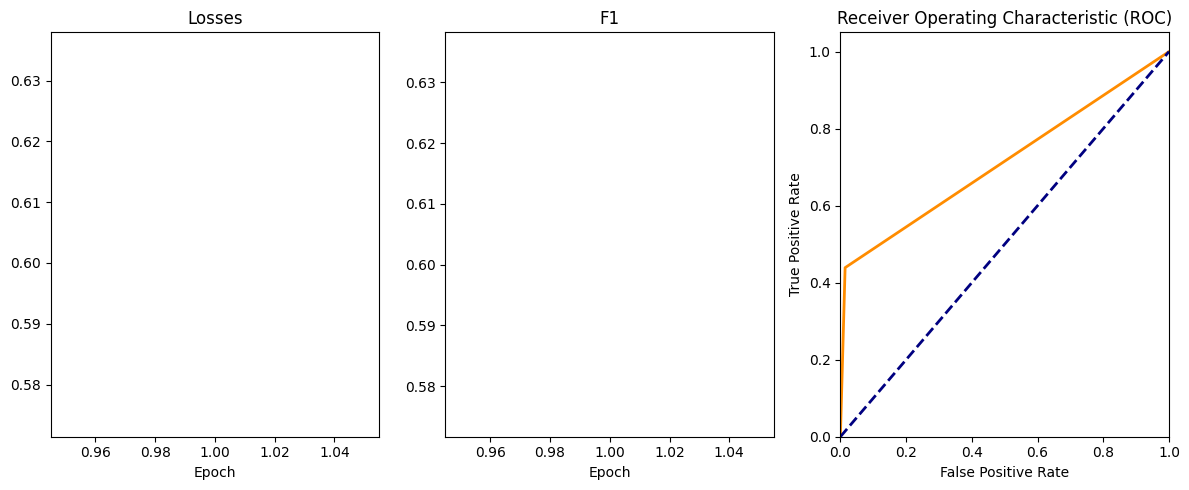

Training epoch 2:   0%|          | 0/10902 [00:00<?, ?it/s]

Testing:   0%|          | 0/2726 [00:00<?, ?it/s]

              precision    recall  f1-score   support

         0.0       0.65      0.98      0.78      1252
         1.0       0.96      0.56      0.71      1474

    accuracy                           0.75      2726
   macro avg       0.81      0.77      0.75      2726
weighted avg       0.82      0.75      0.74      2726

Min Loss = 0.5900527291496048, Curr F1 = 0.7087087087087087, Max F1 = 0.7087087087087087, Curr AUC_ROC = 0.7678097676011462, Max AUC_ROC = 0.7678097676011462


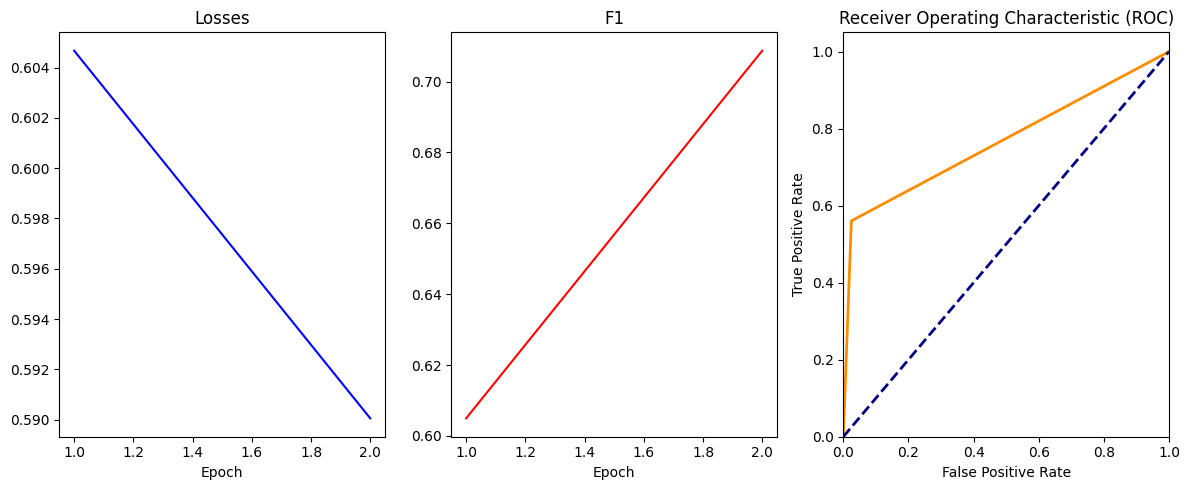

Training epoch 3:   0%|          | 0/10902 [00:00<?, ?it/s]

Testing:   0%|          | 0/2726 [00:00<?, ?it/s]

              precision    recall  f1-score   support

         0.0       0.65      0.99      0.78      1252
         1.0       0.98      0.55      0.70      1474

    accuracy                           0.75      2726
   macro avg       0.81      0.77      0.74      2726
weighted avg       0.83      0.75      0.74      2726

Min Loss = 0.5856504242828277, Curr F1 = 0.7006535947712419, Max F1 = 0.7087087087087087, Curr AUC_ROC = 0.765938135347081, Max AUC_ROC = 0.7678097676011462


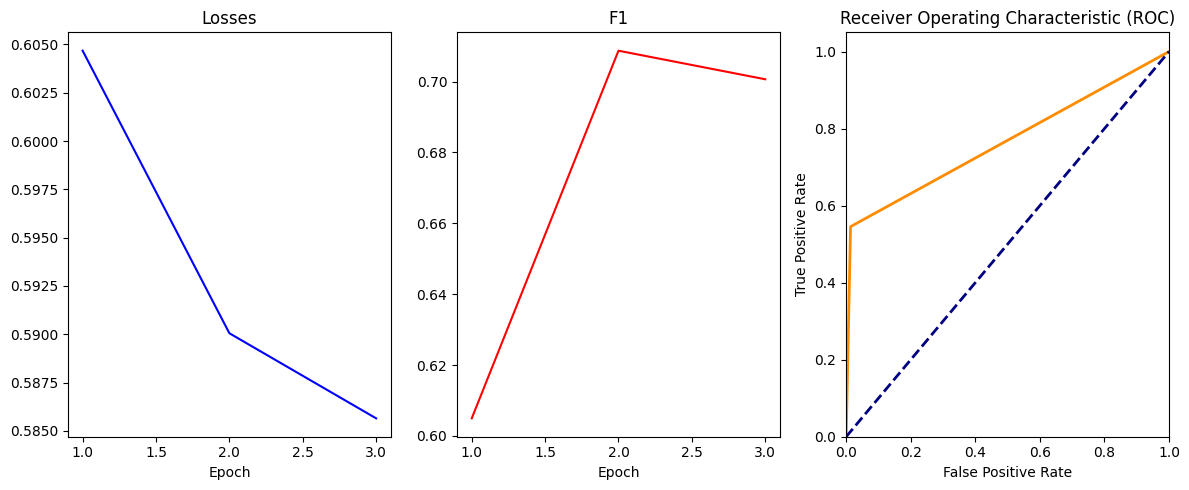

Training epoch 4:   0%|          | 0/10902 [00:00<?, ?it/s]

Testing:   0%|          | 0/2726 [00:00<?, ?it/s]

              precision    recall  f1-score   support

         0.0       0.67      0.98      0.79      1252
         1.0       0.97      0.59      0.73      1474

    accuracy                           0.77      2726
   macro avg       0.82      0.78      0.76      2726
weighted avg       0.83      0.77      0.76      2726

Min Loss = 0.5819017722221322, Curr F1 = 0.7315834038950042, Max F1 = 0.7315834038950042, Curr AUC_ROC = 0.7834953897373429, Max AUC_ROC = 0.7834953897373429


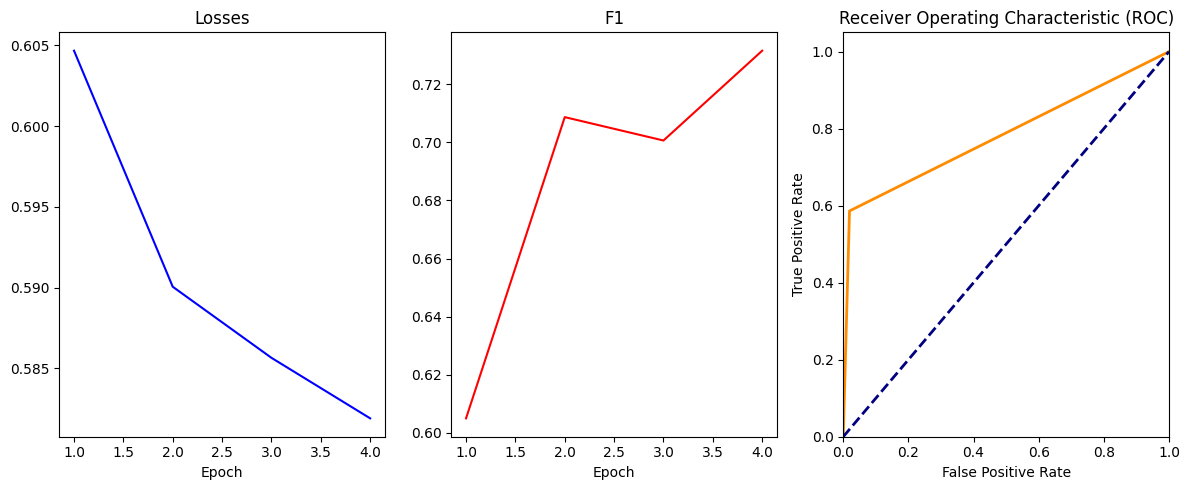

Training epoch 5:   0%|          | 0/10902 [00:00<?, ?it/s]

Testing:   0%|          | 0/2726 [00:00<?, ?it/s]

              precision    recall  f1-score   support

         0.0       0.67      0.98      0.80      1252
         1.0       0.97      0.59      0.73      1474

    accuracy                           0.77      2726
   macro avg       0.82      0.78      0.76      2726
weighted avg       0.83      0.77      0.76      2726

Min Loss = 0.5782775926362526, Curr F1 = 0.7328825021132713, Max F1 = 0.7328825021132713, Curr AUC_ROC = 0.7841136677923194, Max AUC_ROC = 0.7841136677923194


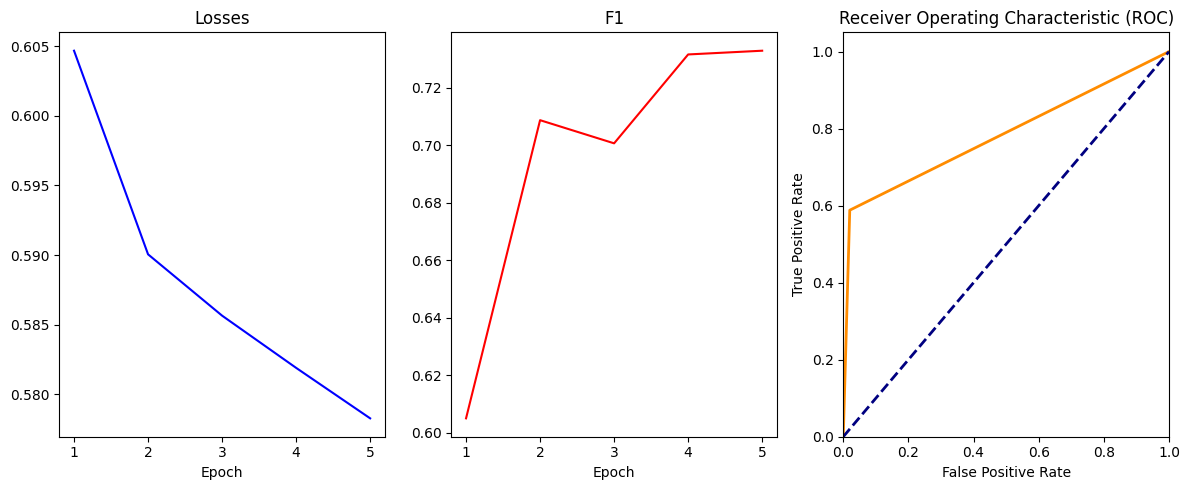

Training epoch 6:   0%|          | 0/10902 [00:00<?, ?it/s]

Testing:   0%|          | 0/2726 [00:00<?, ?it/s]

              precision    recall  f1-score   support

         0.0       0.63      0.99      0.77      1252
         1.0       0.98      0.51      0.67      1474

    accuracy                           0.73      2726
   macro avg       0.80      0.75      0.72      2726
weighted avg       0.82      0.73      0.71      2726

Min Loss = 0.5754797561707529, Curr F1 = 0.667262969588551, Max F1 = 0.7328825021132713, Curr AUC_ROC = 0.7466631408741943, Max AUC_ROC = 0.7841136677923194


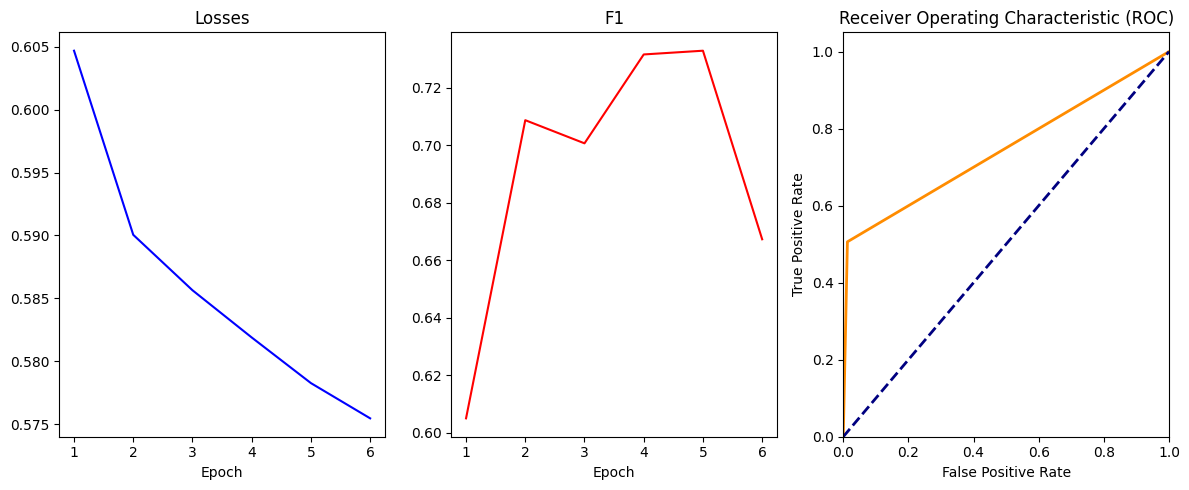

Training epoch 7:   0%|          | 0/10902 [00:00<?, ?it/s]

Testing:   0%|          | 0/2726 [00:00<?, ?it/s]

              precision    recall  f1-score   support

         0.0       0.67      0.98      0.79      1252
         1.0       0.97      0.59      0.73      1474

    accuracy                           0.77      2726
   macro avg       0.82      0.78      0.76      2726
weighted avg       0.83      0.77      0.76      2726

Min Loss = 0.5737495018465544, Curr F1 = 0.7310461668784415, Max F1 = 0.7328825021132713, Curr AUC_ROC = 0.7831561767115627, Max AUC_ROC = 0.7841136677923194


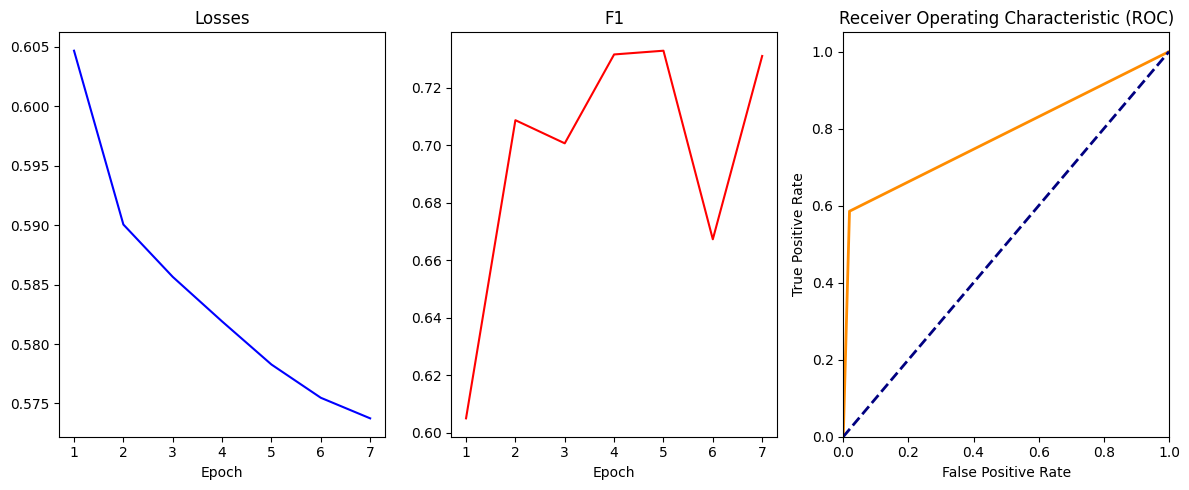

Training epoch 8:   0%|          | 0/10902 [00:00<?, ?it/s]

Testing:   0%|          | 0/2726 [00:00<?, ?it/s]

              precision    recall  f1-score   support

         0.0       0.66      0.99      0.79      1252
         1.0       0.98      0.56      0.71      1474

    accuracy                           0.76      2726
   macro avg       0.82      0.77      0.75      2726
weighted avg       0.83      0.76      0.75      2726

Min Loss = 0.5717602090028815, Curr F1 = 0.7143472641102973, Max F1 = 0.7328825021132713, Curr AUC_ROC = 0.7740190999692215, Max AUC_ROC = 0.7841136677923194


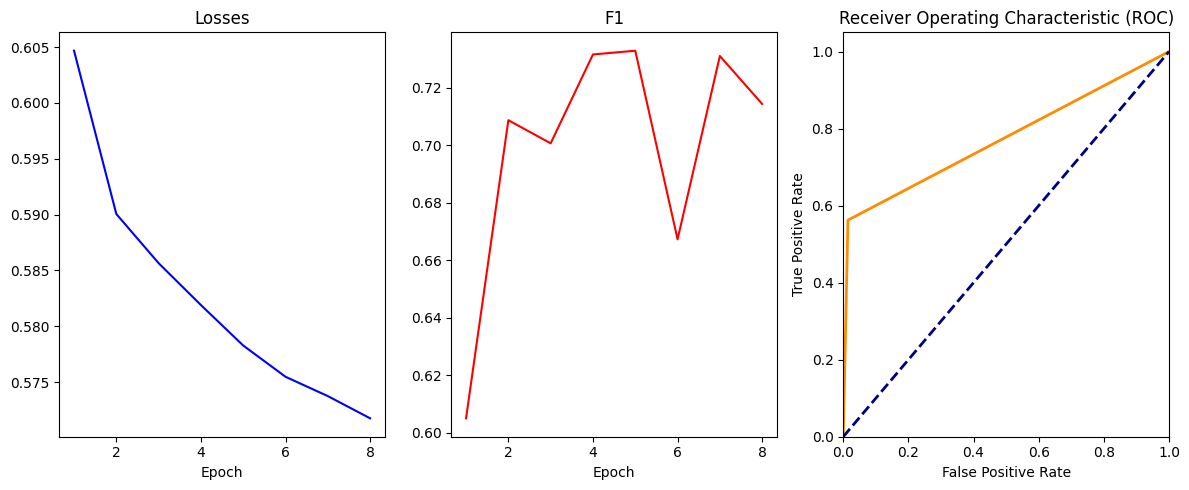

Training epoch 9:   0%|          | 0/10902 [00:00<?, ?it/s]

Testing:   0%|          | 0/2726 [00:00<?, ?it/s]

              precision    recall  f1-score   support

         0.0       0.68      0.99      0.81      1252
         1.0       0.98      0.61      0.75      1474

    accuracy                           0.78      2726
   macro avg       0.83      0.80      0.78      2726
weighted avg       0.84      0.78      0.78      2726

Min Loss = 0.5689308746153883, Curr F1 = 0.7498952660242982, Max F1 = 0.7498952660242982, Curr AUC_ROC = 0.7964071596707141, Max AUC_ROC = 0.7964071596707141


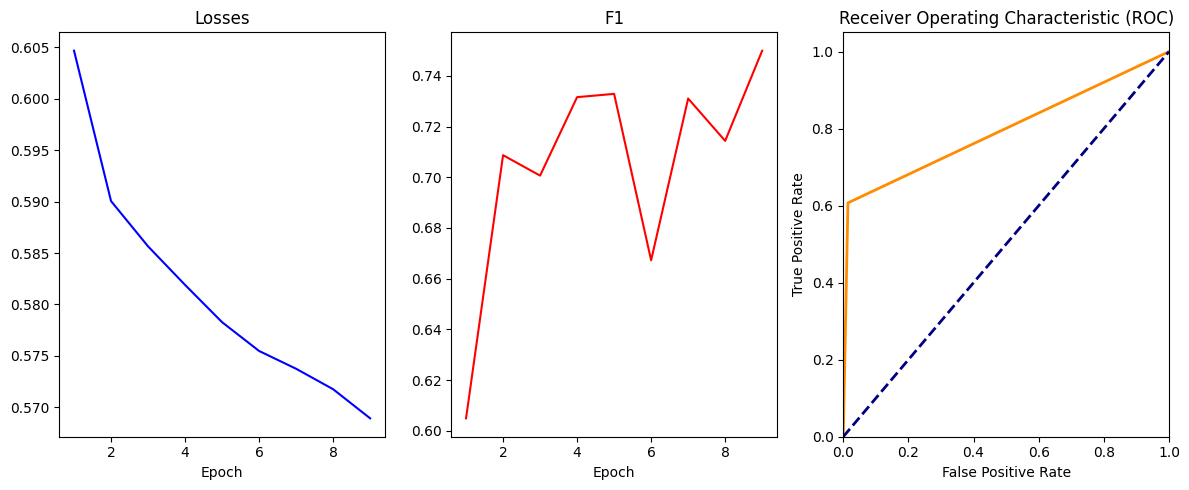

Training epoch 10:   0%|          | 0/10902 [00:00<?, ?it/s]

Testing:   0%|          | 0/2726 [00:00<?, ?it/s]

              precision    recall  f1-score   support

         0.0       0.67      0.97      0.80      1252
         1.0       0.96      0.60      0.74      1474

    accuracy                           0.77      2726
   macro avg       0.82      0.79      0.77      2726
weighted avg       0.83      0.77      0.76      2726

Min Loss = 0.5674039748770844, Curr F1 = 0.7378559463986599, Max F1 = 0.7498952660242982, Curr AUC_ROC = 0.7856677619743282, Max AUC_ROC = 0.7964071596707141


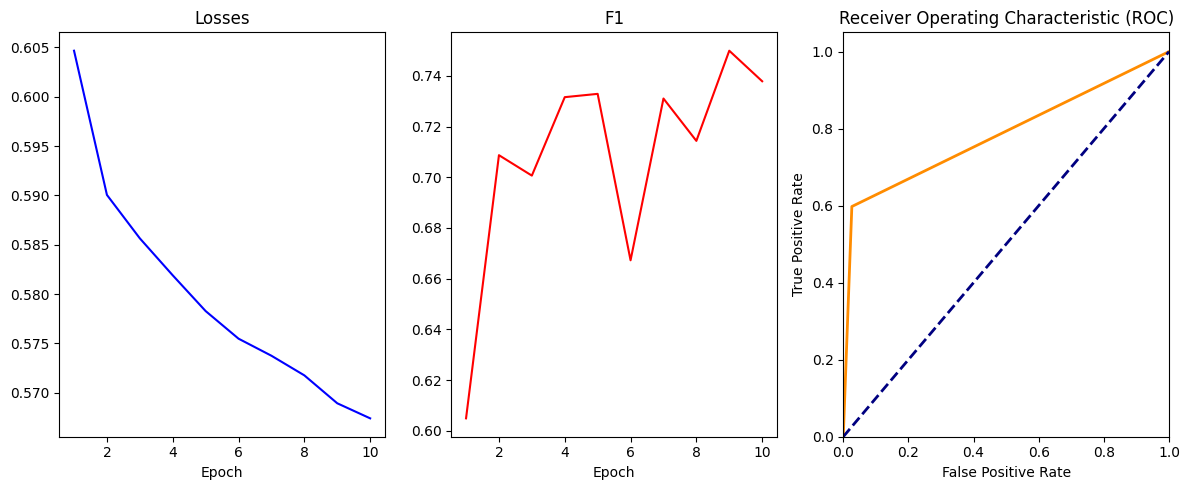

In [50]:
model_rnn = OtchislenieModel(hidden_dim=128, input_size=max_subjects_per_semestr, num_classes = 1).to(device)
criterion = nn.BCELoss()
optimizer = torch.optim.Adam(model_rnn.parameters())

model_rnn = train_model(model_rnn, optimizer, criterion, num_epoch=10)

Training epoch 1:   0%|          | 0/10902 [00:00<?, ?it/s]

Testing:   0%|          | 0/2726 [00:00<?, ?it/s]

              precision    recall  f1-score   support

         0.0       0.37      0.01      0.02      1252
         1.0       0.54      0.98      0.70      1474

    accuracy                           0.54      2726
   macro avg       0.45      0.50      0.36      2726
weighted avg       0.46      0.54      0.39      2726

Min Loss = 0.7692811991742632, Curr F1 = 0.6967803940413262, Max F1 = 0.6967803940413262, Curr AUC_ROC = 0.49744994169437445, Max AUC_ROC = 0.49744994169437445


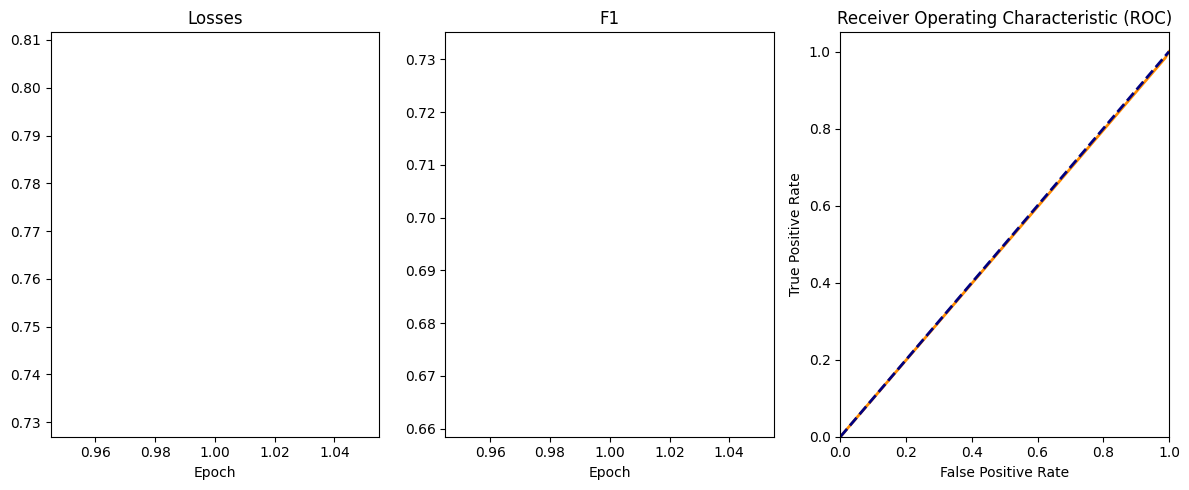

Training epoch 2:   0%|          | 0/10902 [00:00<?, ?it/s]

Testing:   0%|          | 0/2726 [00:00<?, ?it/s]

              precision    recall  f1-score   support

         0.0       0.57      0.99      0.72      1252
         1.0       0.98      0.36      0.53      1474

    accuracy                           0.65      2726
   macro avg       0.77      0.68      0.63      2726
weighted avg       0.79      0.65      0.62      2726

Min Loss = 0.702788975917403, Curr F1 = 0.5308947108255068, Max F1 = 0.6967803940413262, Curr AUC_ROC = 0.6773650625755914, Max AUC_ROC = 0.6773650625755914


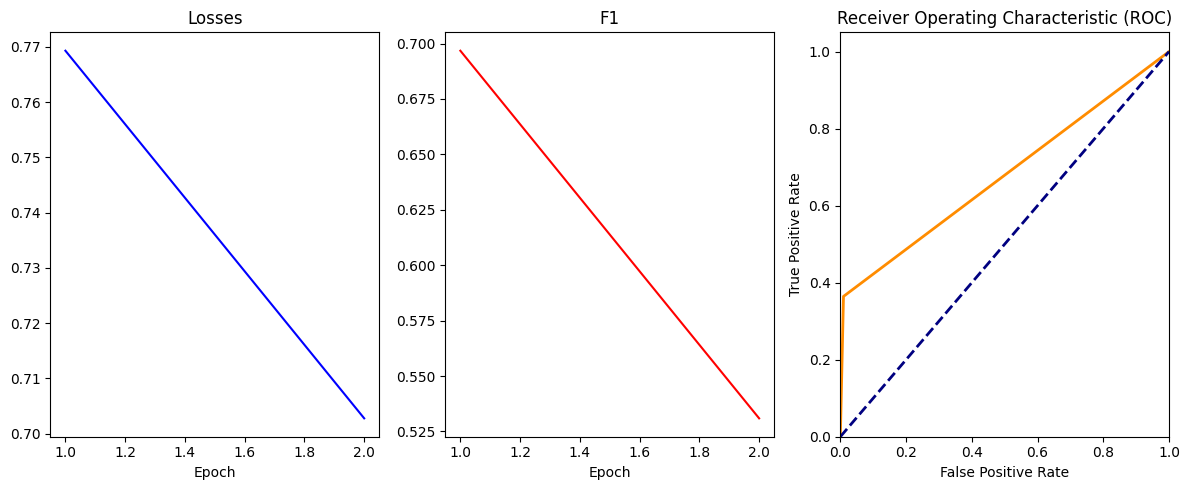

Training epoch 3:   0%|          | 0/10902 [00:00<?, ?it/s]

Testing:   0%|          | 0/2726 [00:00<?, ?it/s]

              precision    recall  f1-score   support

         0.0       0.60      1.00      0.75      1252
         1.0       1.00      0.43      0.60      1474

    accuracy                           0.69      2726
   macro avg       0.80      0.71      0.67      2726
weighted avg       0.81      0.69      0.67      2726

Min Loss = 0.629340739173422, Curr F1 = 0.5982905982905983, Max F1 = 0.6967803940413262, Curr AUC_ROC = 0.7129054841967912, Max AUC_ROC = 0.7129054841967912


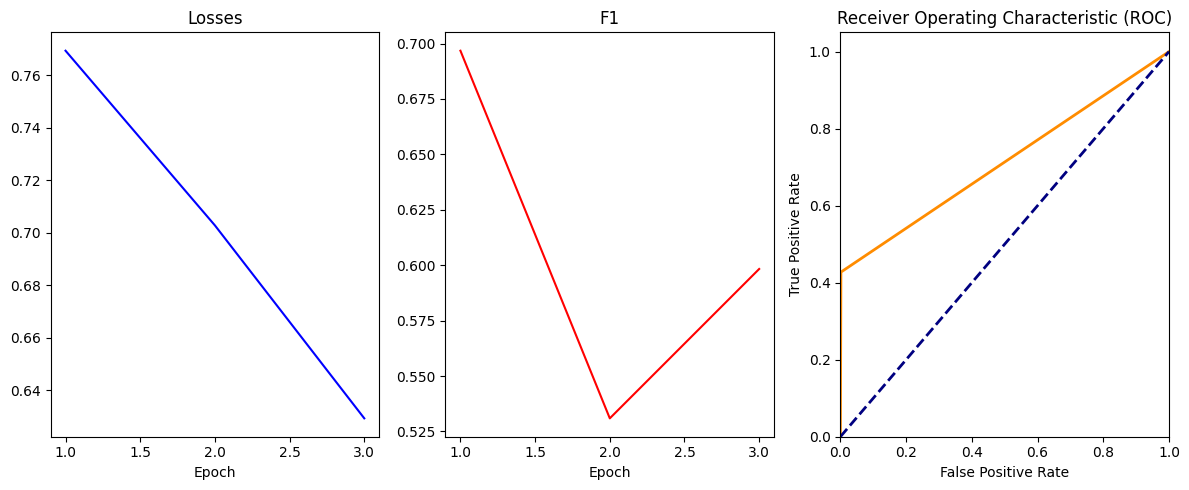

Training epoch 4:   0%|          | 0/10902 [00:00<?, ?it/s]

Testing:   0%|          | 0/2726 [00:00<?, ?it/s]

              precision    recall  f1-score   support

         0.0       0.59      0.99      0.74      1252
         1.0       0.99      0.43      0.59      1474

    accuracy                           0.69      2726
   macro avg       0.79      0.71      0.67      2726
weighted avg       0.81      0.69      0.66      2726

Min Loss = 0.629340739173422, Curr F1 = 0.5943127962085307, Max F1 = 0.6967803940413262, Curr AUC_ROC = 0.7090923179629012, Max AUC_ROC = 0.7129054841967912


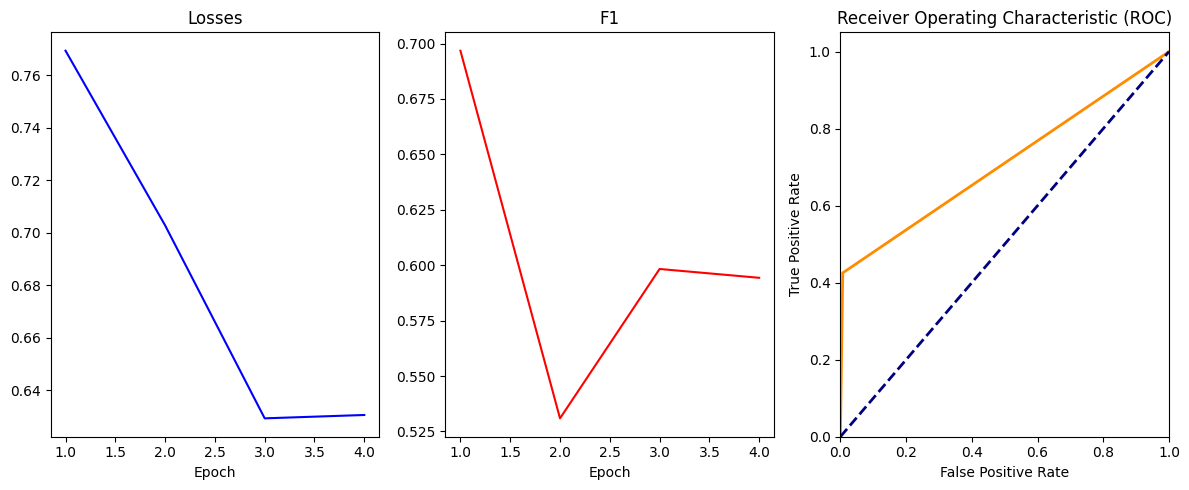

Training epoch 5:   0%|          | 0/10902 [00:00<?, ?it/s]

Testing:   0%|          | 0/2726 [00:00<?, ?it/s]

              precision    recall  f1-score   support

         0.0       0.59      1.00      0.74      1252
         1.0       0.99      0.40      0.57      1474

    accuracy                           0.67      2726
   macro avg       0.79      0.70      0.65      2726
weighted avg       0.81      0.67      0.65      2726

Min Loss = 0.6220498753756345, Curr F1 = 0.5712904784920252, Max F1 = 0.6967803940413262, Curr AUC_ROC = 0.6988774541466354, Max AUC_ROC = 0.7129054841967912


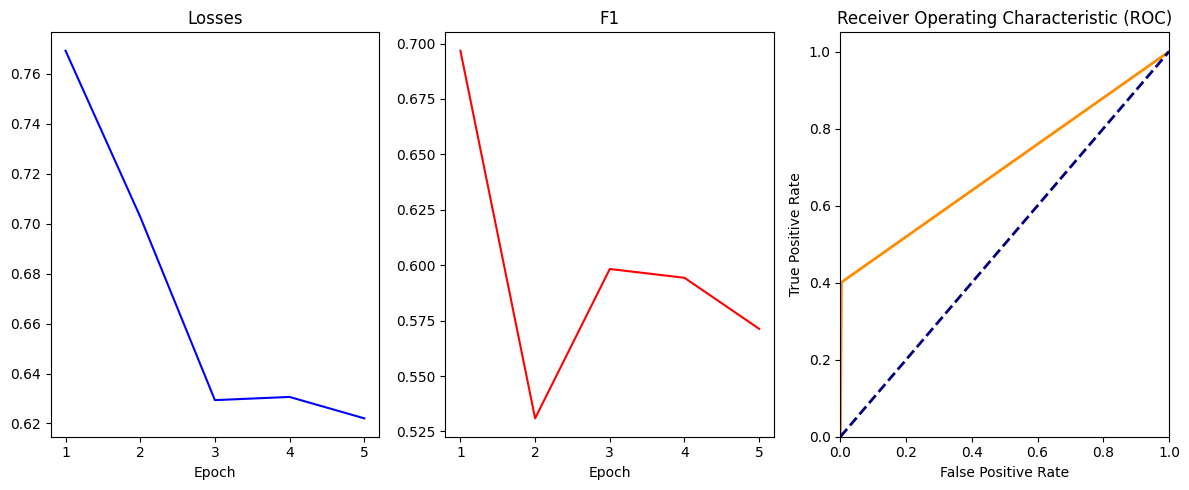

Training epoch 6:   0%|          | 0/10902 [00:00<?, ?it/s]

Testing:   0%|          | 0/2726 [00:00<?, ?it/s]

              precision    recall  f1-score   support

         0.0       0.57      1.00      0.72      1252
         1.0       1.00      0.35      0.52      1474

    accuracy                           0.65      2726
   macro avg       0.78      0.67      0.62      2726
weighted avg       0.80      0.65      0.61      2726

Min Loss = 0.619121648033613, Curr F1 = 0.5165829145728643, Max F1 = 0.6967803940413262, Curr AUC_ROC = 0.6735567732062893, Max AUC_ROC = 0.7129054841967912


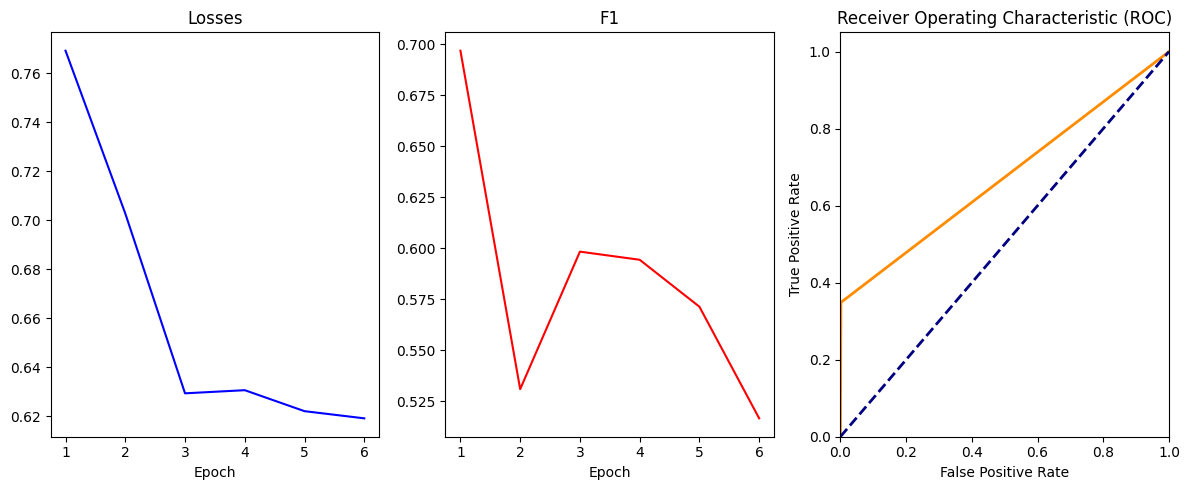

Training epoch 7:   0%|          | 0/10902 [00:00<?, ?it/s]

Testing:   0%|          | 0/2726 [00:00<?, ?it/s]

              precision    recall  f1-score   support

         0.0       0.60      0.99      0.75      1252
         1.0       0.98      0.44      0.60      1474

    accuracy                           0.69      2726
   macro avg       0.79      0.71      0.67      2726
weighted avg       0.80      0.69      0.67      2726

Min Loss = 0.619121648033613, Curr F1 = 0.6035613870665417, Max F1 = 0.6967803940413262, Curr AUC_ROC = 0.7120634122446149, Max AUC_ROC = 0.7129054841967912


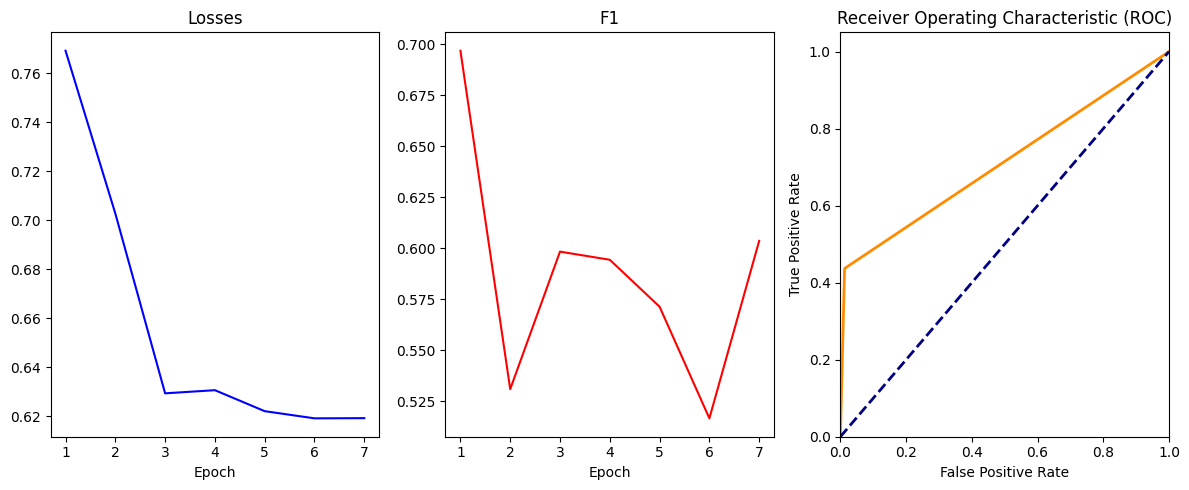

Training epoch 8:   0%|          | 0/10902 [00:00<?, ?it/s]

Testing:   0%|          | 0/2726 [00:00<?, ?it/s]

              precision    recall  f1-score   support

         0.0       0.63      0.97      0.76      1252
         1.0       0.96      0.51      0.66      1474

    accuracy                           0.72      2726
   macro avg       0.79      0.74      0.71      2726
weighted avg       0.81      0.72      0.71      2726

Min Loss = 0.619121648033613, Curr F1 = 0.66430155210643, Max F1 = 0.6967803940413262, Curr AUC_ROC = 0.7412910035937073, Max AUC_ROC = 0.7412910035937073


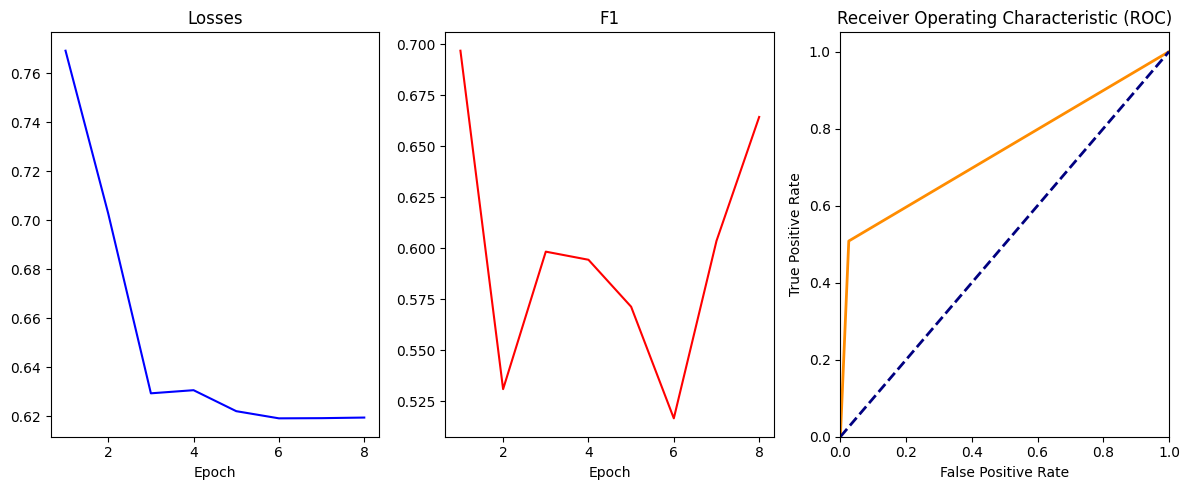

Training epoch 9:   0%|          | 0/10902 [00:00<?, ?it/s]

Testing:   0%|          | 0/2726 [00:00<?, ?it/s]

              precision    recall  f1-score   support

         0.0       0.63      0.98      0.77      1252
         1.0       0.97      0.50      0.66      1474

    accuracy                           0.72      2726
   macro avg       0.80      0.74      0.72      2726
weighted avg       0.81      0.72      0.71      2726

Min Loss = 0.6150784399439011, Curr F1 = 0.6642857142857144, Max F1 = 0.6967803940413262, Curr AUC_ROC = 0.7435885486884485, Max AUC_ROC = 0.7435885486884485


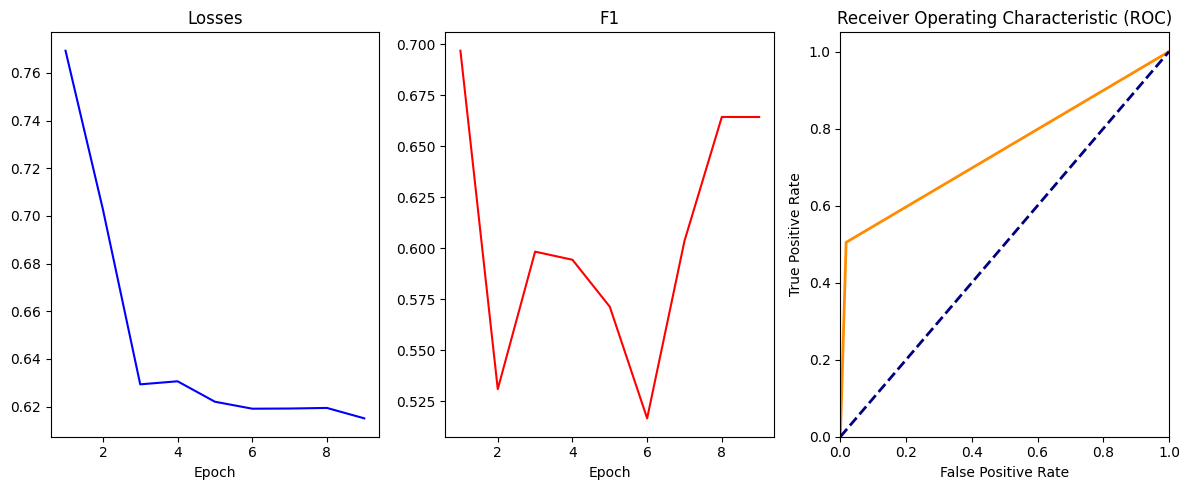

Training epoch 10:   0%|          | 0/10902 [00:00<?, ?it/s]

Testing:   0%|          | 0/2726 [00:00<?, ?it/s]

              precision    recall  f1-score   support

         0.0       0.60      0.99      0.75      1252
         1.0       0.98      0.45      0.62      1474

    accuracy                           0.70      2726
   macro avg       0.79      0.72      0.68      2726
weighted avg       0.81      0.70      0.68      2726

Min Loss = 0.6150784399439011, Curr F1 = 0.617169373549884, Max F1 = 0.6967803940413262, Curr AUC_ROC = 0.7191868857859989, Max AUC_ROC = 0.7435885486884485


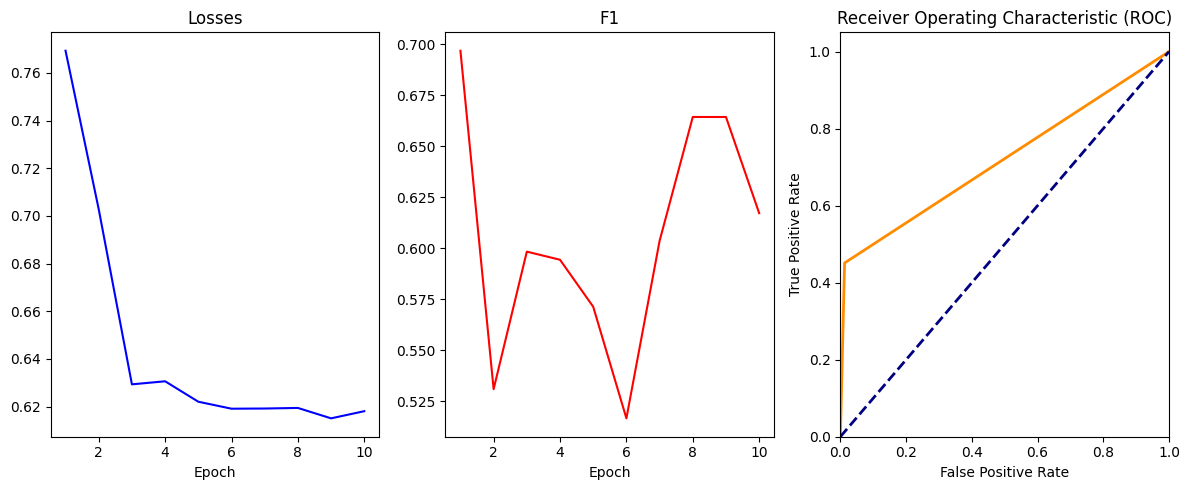

In [51]:
model_rnn = OtchislenieModel(hidden_dim=512, input_size=max_subjects_per_semestr, num_classes = 1).to(device)
criterion = nn.BCELoss()
optimizer = torch.optim.Adam(model_rnn.parameters())

model_rnn = train_model(model_rnn, optimizer, criterion, num_epoch=10)

GRU Base Structure

Training epoch 1:   0%|          | 0/10902 [00:00<?, ?it/s]

Testing:   0%|          | 0/2726 [00:00<?, ?it/s]

              precision    recall  f1-score   support

         0.0       0.49      1.00      0.66      1252
         1.0       1.00      0.11      0.19      1474

    accuracy                           0.52      2726
   macro avg       0.74      0.55      0.42      2726
weighted avg       0.76      0.52      0.41      2726

Min Loss = 0.8142797786546309, Curr F1 = 0.19251992642550583, Max F1 = 0.19251992642550583, Curr AUC_ROC = 0.5532564450474898, Max AUC_ROC = 0.5532564450474898


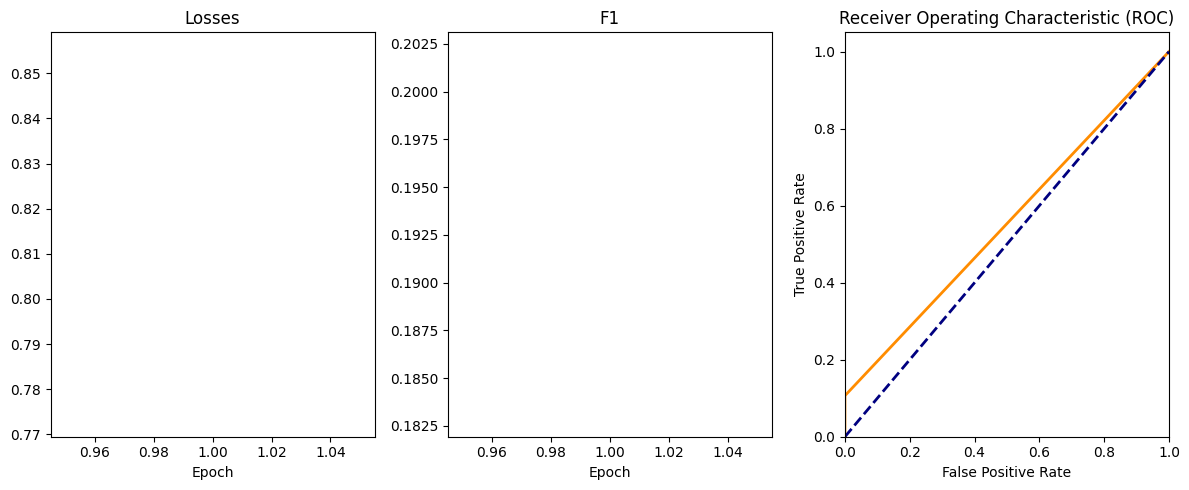

Training epoch 2:   0%|          | 0/10902 [00:00<?, ?it/s]

Testing:   0%|          | 0/2726 [00:00<?, ?it/s]

              precision    recall  f1-score   support

         0.0       0.61      0.98      0.75      1252
         1.0       0.96      0.46      0.62      1474

    accuracy                           0.70      2726
   macro avg       0.78      0.72      0.69      2726
weighted avg       0.80      0.70      0.68      2726

Min Loss = 0.6863085708253385, Curr F1 = 0.6249428962996803, Max F1 = 0.6249428962996803, Curr AUC_ROC = 0.7196415179403591, Max AUC_ROC = 0.7196415179403591


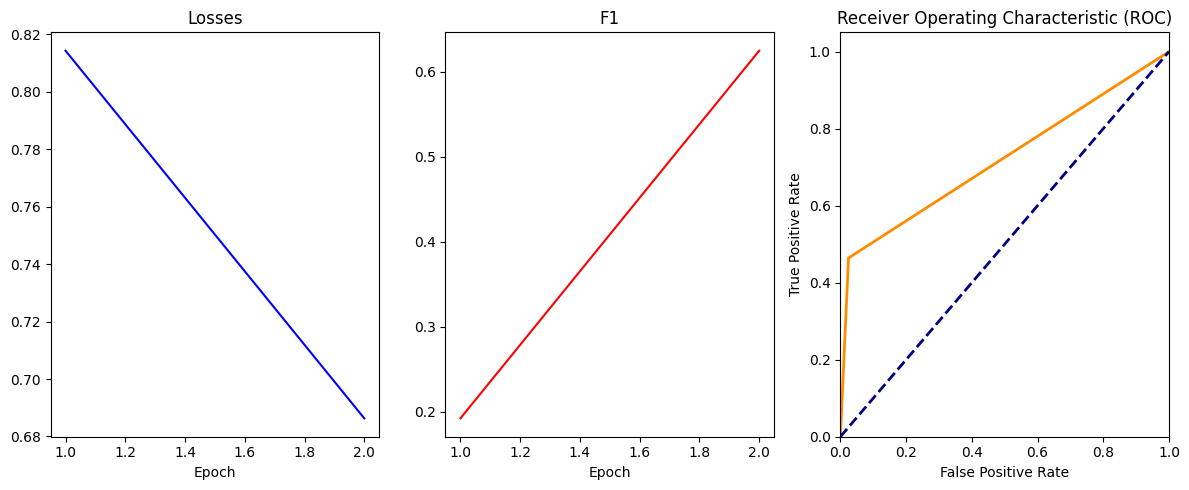

Training epoch 3:   0%|          | 0/10902 [00:00<?, ?it/s]

Testing:   0%|          | 0/2726 [00:00<?, ?it/s]

              precision    recall  f1-score   support

         0.0       0.57      1.00      0.73      1252
         1.0       1.00      0.36      0.53      1474

    accuracy                           0.65      2726
   macro avg       0.78      0.68      0.63      2726
weighted avg       0.80      0.65      0.62      2726

Min Loss = 0.6245190494269587, Curr F1 = 0.5301444942700548, Max F1 = 0.6249428962996803, Curr AUC_ROC = 0.6800619686926969, Max AUC_ROC = 0.7196415179403591


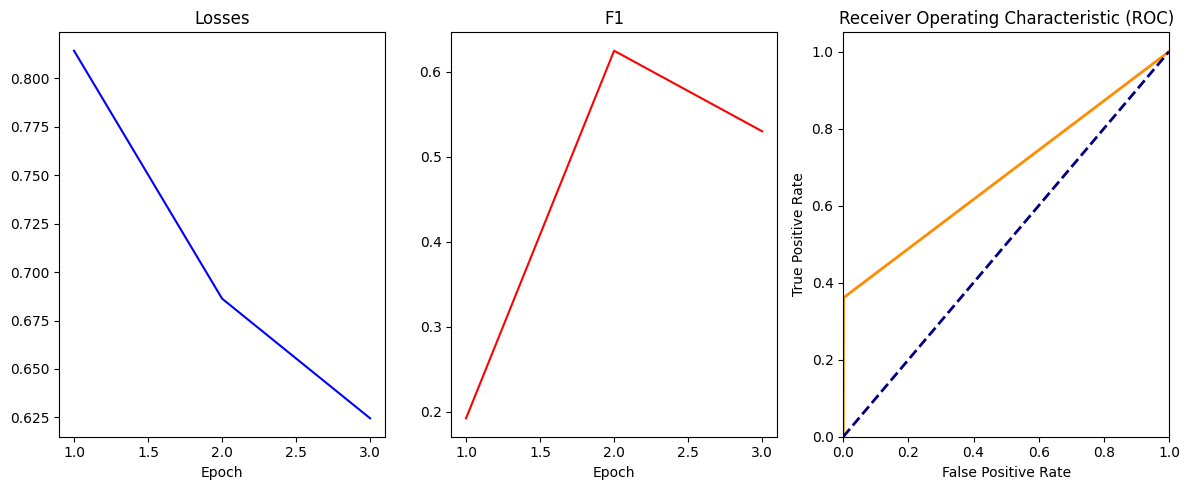

Training epoch 4:   0%|          | 0/10902 [00:00<?, ?it/s]

Testing:   0%|          | 0/2726 [00:00<?, ?it/s]

              precision    recall  f1-score   support

         0.0       0.68      0.97      0.80      1252
         1.0       0.95      0.61      0.74      1474

    accuracy                           0.77      2726
   macro avg       0.81      0.79      0.77      2726
weighted avg       0.83      0.77      0.77      2726

Min Loss = 0.6199986137801016, Curr F1 = 0.7416009954375778, Max F1 = 0.7416009954375778, Curr AUC_ROC = 0.7860839210858285, Max AUC_ROC = 0.7860839210858285


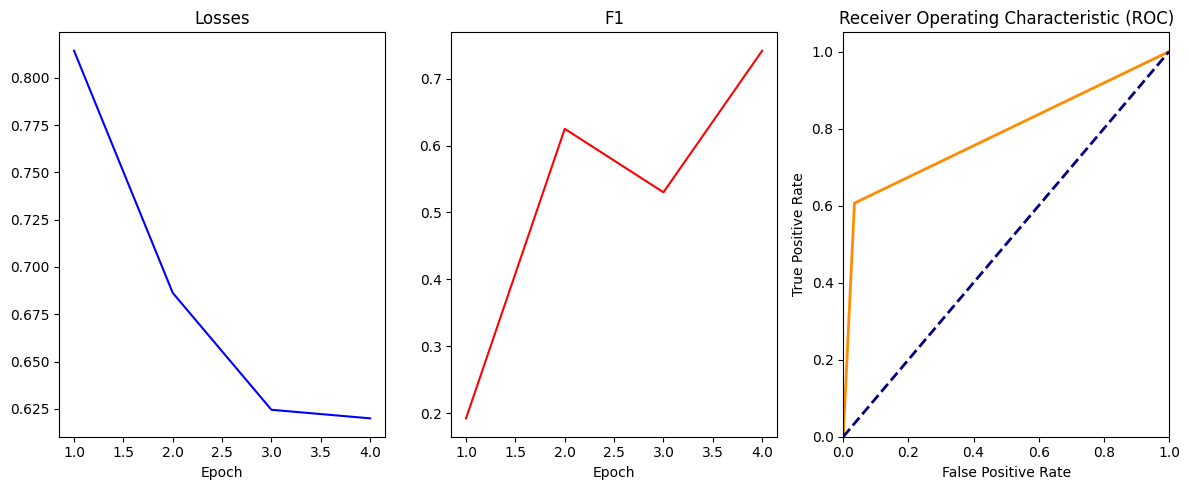

Training epoch 5:   0%|          | 0/10902 [00:00<?, ?it/s]

Testing:   0%|          | 0/2726 [00:00<?, ?it/s]

              precision    recall  f1-score   support

         0.0       0.62      0.98      0.76      1252
         1.0       0.97      0.48      0.64      1474

    accuracy                           0.71      2726
   macro avg       0.79      0.73      0.70      2726
weighted avg       0.81      0.71      0.70      2726

Min Loss = 0.6148637607406638, Curr F1 = 0.6446654611211573, Max F1 = 0.7416009954375778, Curr AUC_ROC = 0.73187486182217, Max AUC_ROC = 0.7860839210858285


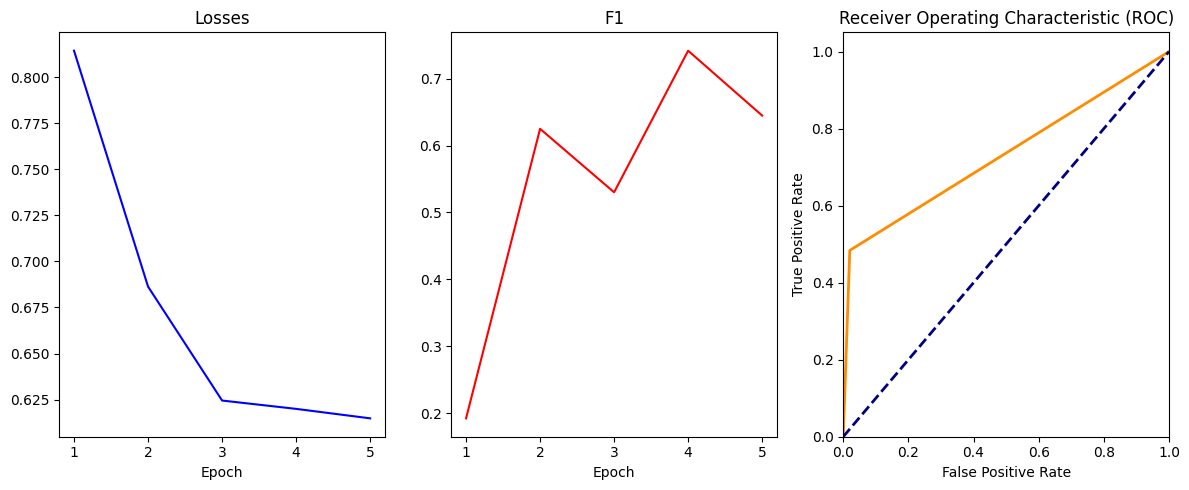

Training epoch 6:   0%|          | 0/10902 [00:00<?, ?it/s]

Testing:   0%|          | 0/2726 [00:00<?, ?it/s]

              precision    recall  f1-score   support

         0.0       0.59      0.99      0.74      1252
         1.0       0.99      0.42      0.59      1474

    accuracy                           0.68      2726
   macro avg       0.79      0.71      0.67      2726
weighted avg       0.81      0.68      0.66      2726

Min Loss = 0.6064539075449965, Curr F1 = 0.5901951451689671, Max F1 = 0.7416009954375778, Curr AUC_ROC = 0.7075165488271683, Max AUC_ROC = 0.7860839210858285


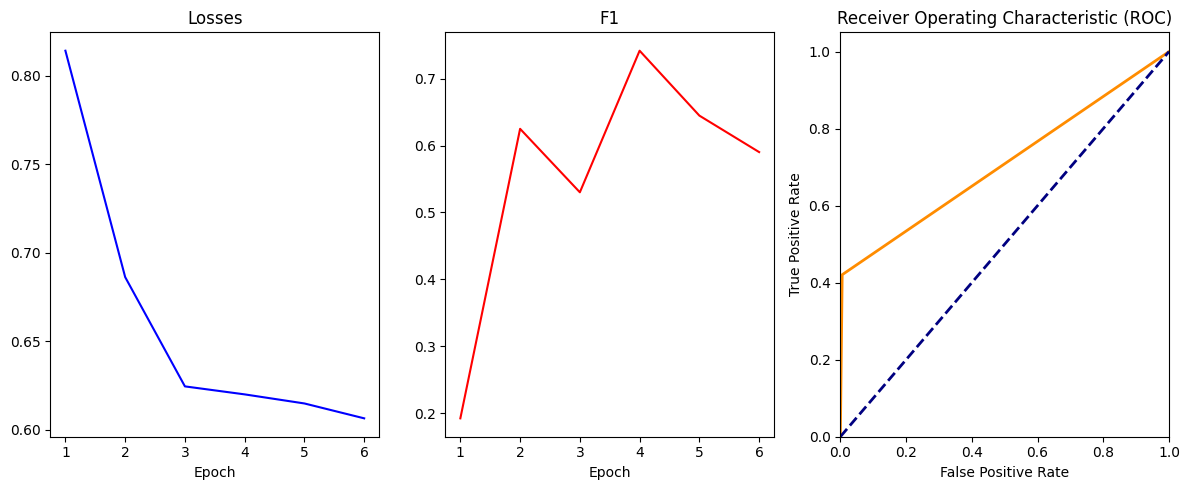

Training epoch 7:   0%|          | 0/10902 [00:00<?, ?it/s]

Testing:   0%|          | 0/2726 [00:00<?, ?it/s]

              precision    recall  f1-score   support

         0.0       0.61      0.99      0.75      1252
         1.0       0.97      0.46      0.63      1474

    accuracy                           0.70      2726
   macro avg       0.79      0.73      0.69      2726
weighted avg       0.81      0.70      0.69      2726

Min Loss = 0.6064539075449965, Curr F1 = 0.6293063849333946, Max F1 = 0.7416009954375778, Curr AUC_ROC = 0.7251724242568741, Max AUC_ROC = 0.7860839210858285


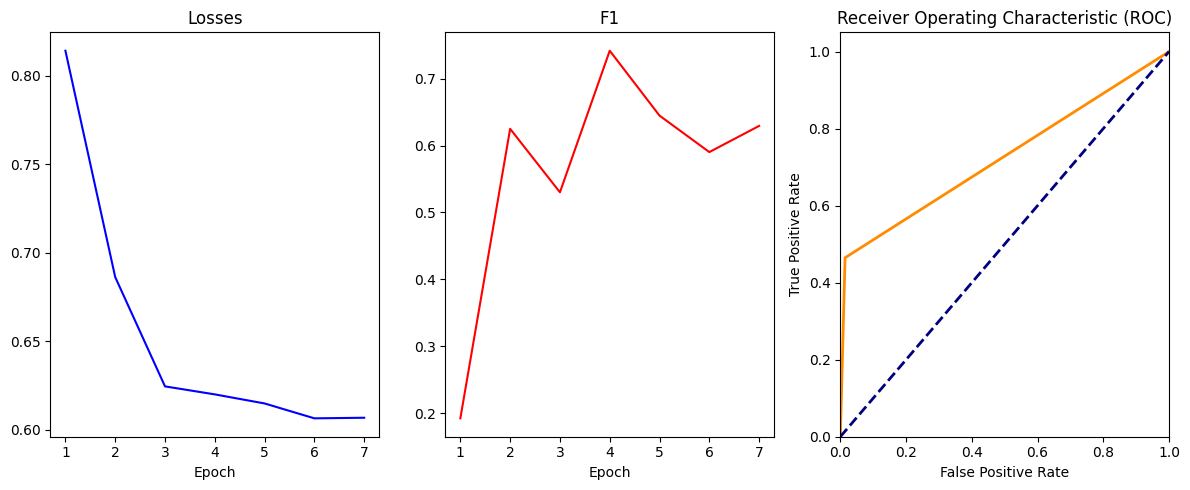

Training epoch 8:   0%|          | 0/10902 [00:00<?, ?it/s]

Testing:   0%|          | 0/2726 [00:00<?, ?it/s]

              precision    recall  f1-score   support

         0.0       0.65      0.98      0.78      1252
         1.0       0.98      0.54      0.70      1474

    accuracy                           0.74      2726
   macro avg       0.81      0.76      0.74      2726
weighted avg       0.82      0.74      0.73      2726

Min Loss = 0.6012489806209391, Curr F1 = 0.6963350785340315, Max F1 = 0.7416009954375778, Curr AUC_ROC = 0.7627047741253073, Max AUC_ROC = 0.7860839210858285


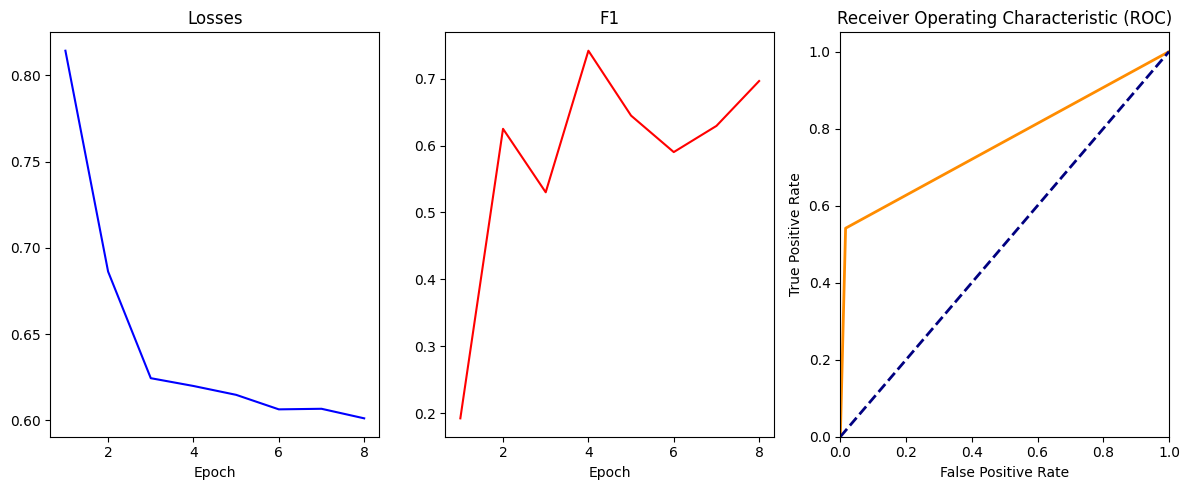

Training epoch 9:   0%|          | 0/10902 [00:00<?, ?it/s]

Testing:   0%|          | 0/2726 [00:00<?, ?it/s]

              precision    recall  f1-score   support

         0.0       0.68      0.98      0.80      1252
         1.0       0.97      0.60      0.74      1474

    accuracy                           0.77      2726
   macro avg       0.82      0.79      0.77      2726
weighted avg       0.83      0.77      0.77      2726

Min Loss = 0.5955780355361947, Curr F1 = 0.7427854454203263, Max F1 = 0.7427854454203263, Curr AUC_ROC = 0.7896396972442462, Max AUC_ROC = 0.7896396972442462


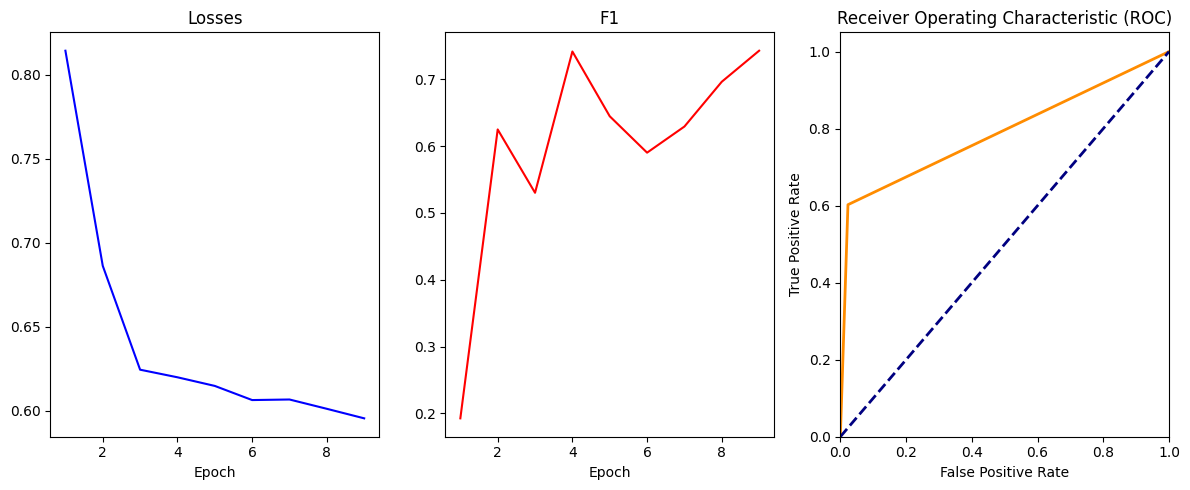

Training epoch 10:   0%|          | 0/10902 [00:00<?, ?it/s]

Testing:   0%|          | 0/2726 [00:00<?, ?it/s]

              precision    recall  f1-score   support

         0.0       0.66      0.98      0.79      1252
         1.0       0.97      0.57      0.72      1474

    accuracy                           0.76      2726
   macro avg       0.82      0.78      0.76      2726
weighted avg       0.83      0.76      0.75      2726

Min Loss = 0.5918164576981794, Curr F1 = 0.7205128205128205, Max F1 = 0.7427854454203263, Curr AUC_ROC = 0.7767712772183232, Max AUC_ROC = 0.7896396972442462


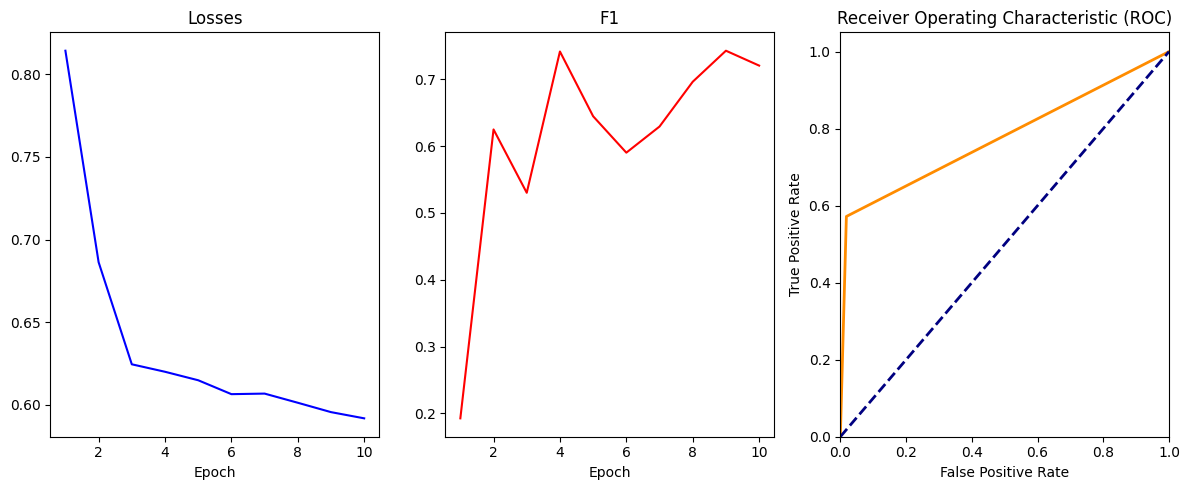

In [52]:
model_gru = OtchislenieModel_GRU(hidden_dim=256, input_size=max_subjects_per_semestr, num_classes = 1).to(device)
criterion = nn.BCELoss()
optimizer = torch.optim.Adam(model_gru.parameters())

model_gru = train_model(model_gru, optimizer, criterion, num_epoch=10)

Training epoch 1:   0%|          | 0/10902 [00:00<?, ?it/s]

Testing:   0%|          | 0/2726 [00:00<?, ?it/s]

              precision    recall  f1-score   support

         0.0       0.66      0.97      0.79      1252
         1.0       0.95      0.58      0.72      1474

    accuracy                           0.76      2726
   macro avg       0.81      0.78      0.76      2726
weighted avg       0.82      0.76      0.75      2726

Min Loss = 0.597858304570977, Curr F1 = 0.7236731255265374, Max F1 = 0.7236731255265374, Curr AUC_ROC = 0.7750101872282502, Max AUC_ROC = 0.7750101872282502


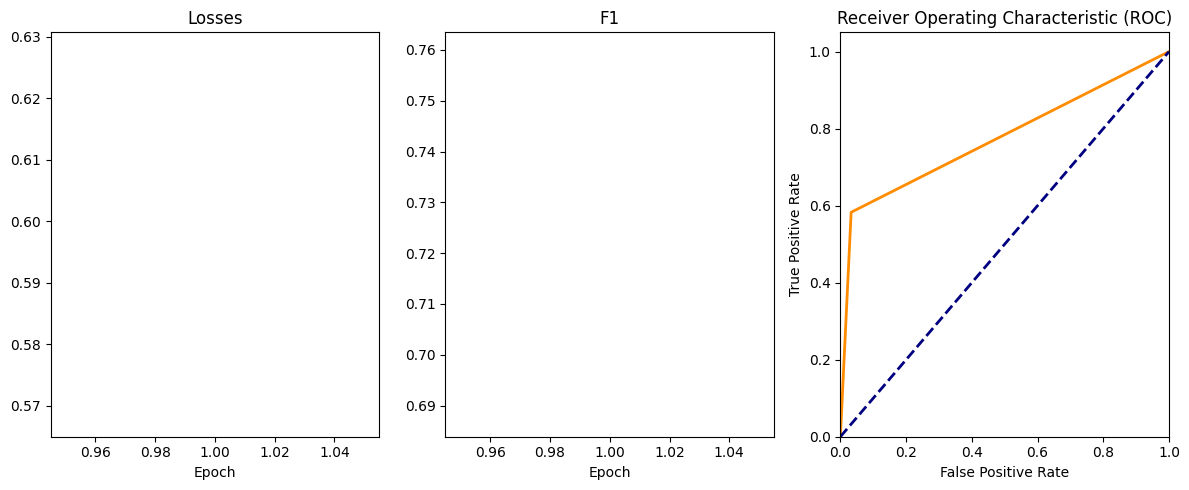

Training epoch 2:   0%|          | 0/10902 [00:00<?, ?it/s]

Testing:   0%|          | 0/2726 [00:00<?, ?it/s]

              precision    recall  f1-score   support

         0.0       0.66      0.98      0.79      1252
         1.0       0.97      0.57      0.72      1474

    accuracy                           0.76      2726
   macro avg       0.81      0.77      0.75      2726
weighted avg       0.83      0.76      0.75      2726

Min Loss = 0.5815990078019518, Curr F1 = 0.7157534246575342, Max F1 = 0.7236731255265374, Curr AUC_ROC = 0.7731987029707692, Max AUC_ROC = 0.7750101872282502


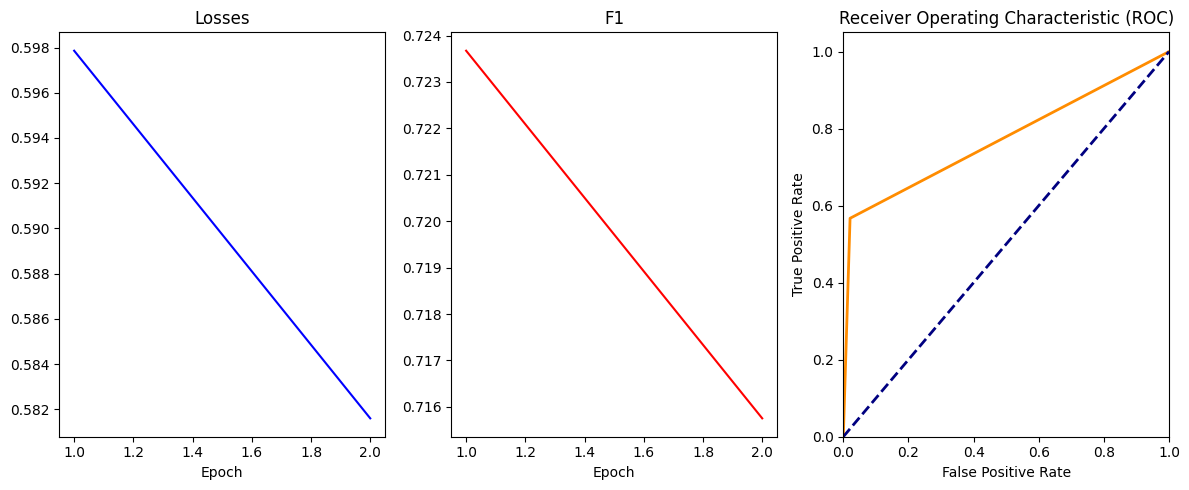

Training epoch 3:   0%|          | 0/10902 [00:00<?, ?it/s]

Testing:   0%|          | 0/2726 [00:00<?, ?it/s]

              precision    recall  f1-score   support

         0.0       0.65      0.98      0.78      1252
         1.0       0.97      0.55      0.70      1474

    accuracy                           0.75      2726
   macro avg       0.81      0.77      0.74      2726
weighted avg       0.82      0.75      0.74      2726

Min Loss = 0.5725751240069528, Curr F1 = 0.7022106631989596, Max F1 = 0.7236731255265374, Curr AUC_ROC = 0.7655772473675769, Max AUC_ROC = 0.7750101872282502


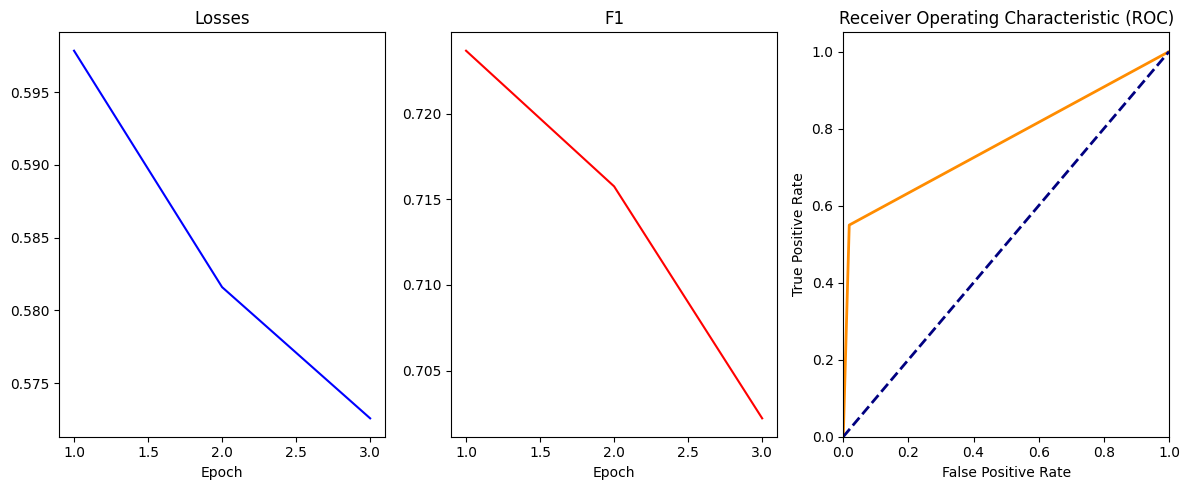

Training epoch 4:   0%|          | 0/10902 [00:00<?, ?it/s]

Testing:   0%|          | 0/2726 [00:00<?, ?it/s]

              precision    recall  f1-score   support

         0.0       0.67      0.99      0.80      1252
         1.0       0.98      0.58      0.73      1474

    accuracy                           0.77      2726
   macro avg       0.82      0.78      0.76      2726
weighted avg       0.84      0.77      0.76      2726

Min Loss = 0.5655881625521054, Curr F1 = 0.7276613937580162, Max F1 = 0.7276613937580162, Curr AUC_ROC = 0.7830792306258426, Max AUC_ROC = 0.7830792306258426


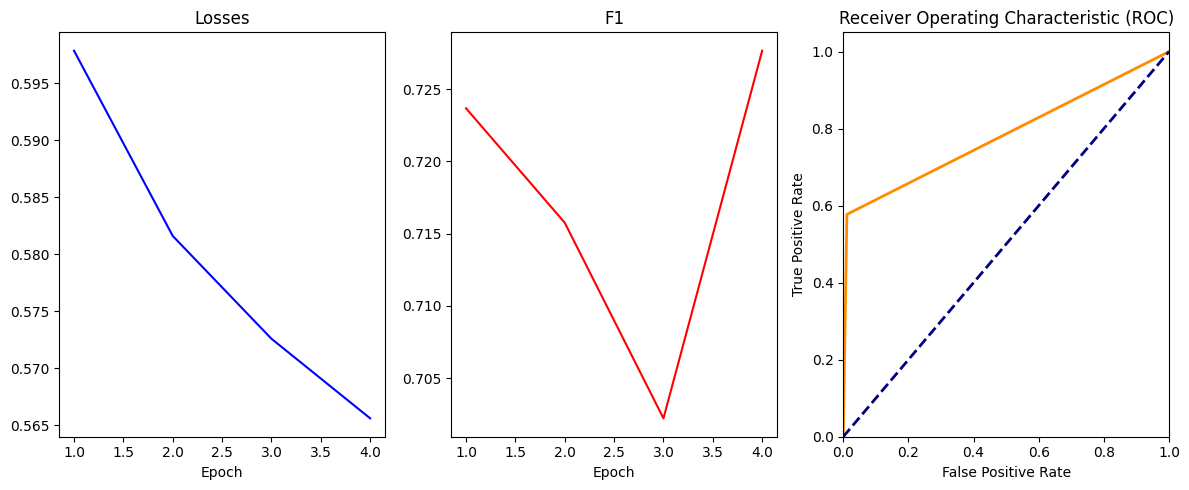

Training epoch 5:   0%|          | 0/10902 [00:00<?, ?it/s]

Testing:   0%|          | 0/2726 [00:00<?, ?it/s]

              precision    recall  f1-score   support

         0.0       0.68      0.97      0.80      1252
         1.0       0.96      0.62      0.75      1474

    accuracy                           0.78      2726
   macro avg       0.82      0.79      0.78      2726
weighted avg       0.83      0.78      0.77      2726

Min Loss = 0.5595493620496302, Curr F1 = 0.7509293680297398, Max F1 = 0.7509293680297398, Curr AUC_ROC = 0.7931689215843525, Max AUC_ROC = 0.7931689215843525


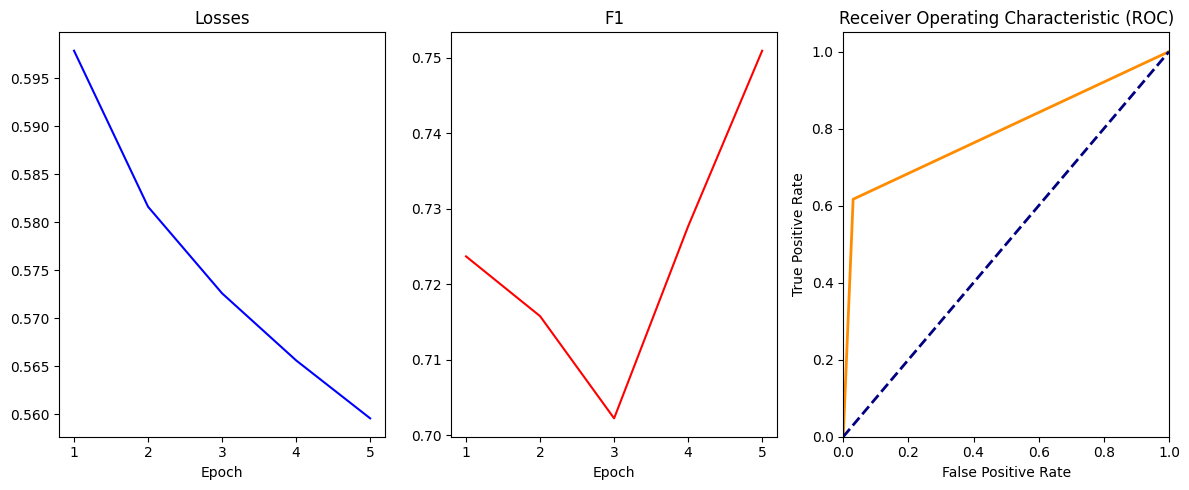

Training epoch 6:   0%|          | 0/10902 [00:00<?, ?it/s]

Testing:   0%|          | 0/2726 [00:00<?, ?it/s]

              precision    recall  f1-score   support

         0.0       0.68      0.97      0.80      1252
         1.0       0.97      0.61      0.75      1474

    accuracy                           0.78      2726
   macro avg       0.82      0.79      0.78      2726
weighted avg       0.83      0.78      0.77      2726

Min Loss = 0.5528703433721356, Curr F1 = 0.7491694352159468, Max F1 = 0.7509293680297398, Curr AUC_ROC = 0.7931905965380763, Max AUC_ROC = 0.7931905965380763


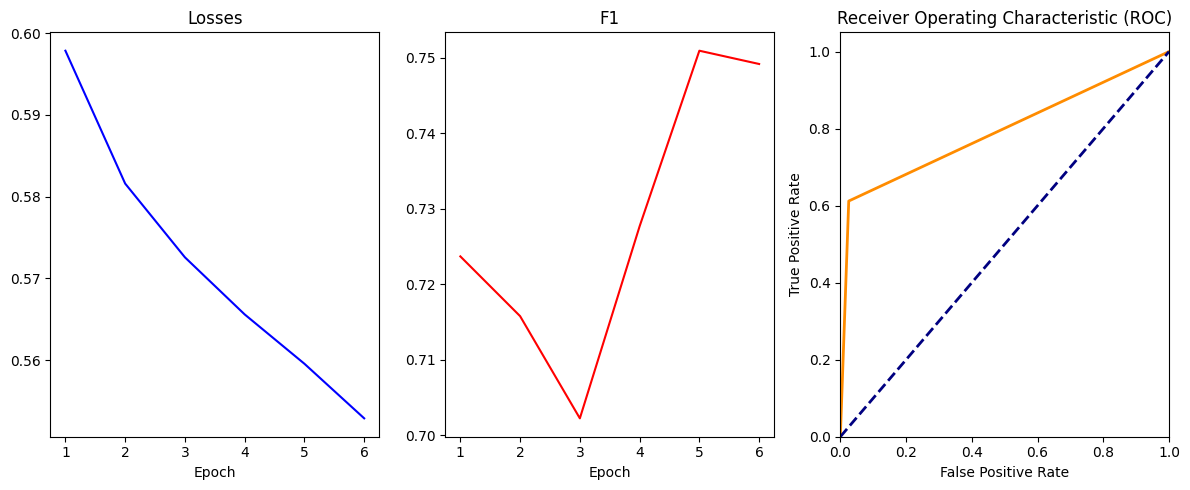

Training epoch 7:   0%|          | 0/10902 [00:00<?, ?it/s]

Testing:   0%|          | 0/2726 [00:00<?, ?it/s]

              precision    recall  f1-score   support

         0.0       0.69      0.96      0.80      1252
         1.0       0.95      0.64      0.76      1474

    accuracy                           0.79      2726
   macro avg       0.82      0.80      0.78      2726
weighted avg       0.83      0.79      0.78      2726

Min Loss = 0.5483897522466377, Curr F1 = 0.7631792376317924, Max F1 = 0.7631792376317924, Curr AUC_ROC = 0.7988320451185837, Max AUC_ROC = 0.7988320451185837


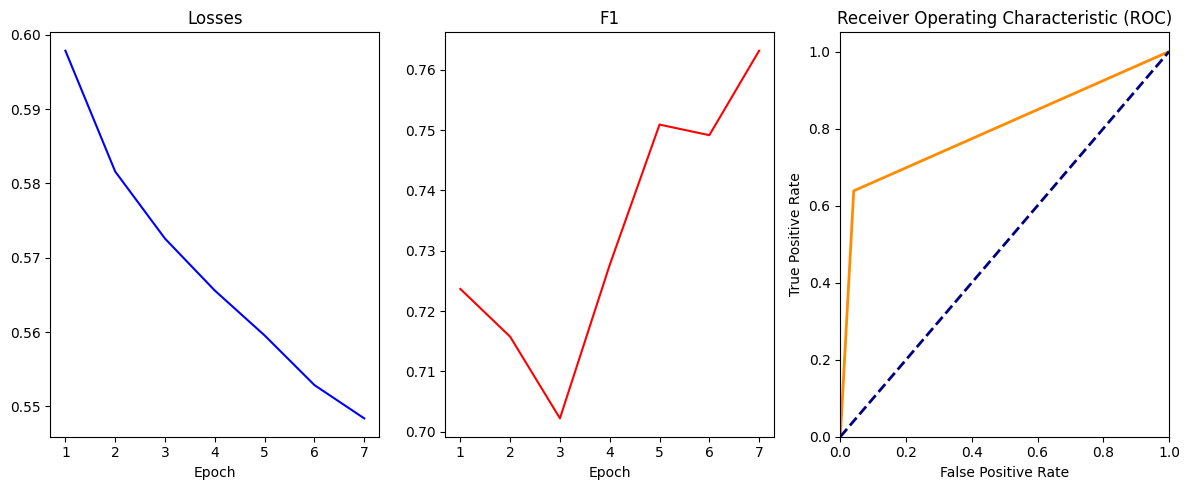

Training epoch 8:   0%|          | 0/10902 [00:00<?, ?it/s]

Testing:   0%|          | 0/2726 [00:00<?, ?it/s]

              precision    recall  f1-score   support

         0.0       0.70      0.96      0.81      1252
         1.0       0.95      0.66      0.78      1474

    accuracy                           0.79      2726
   macro avg       0.83      0.81      0.79      2726
weighted avg       0.84      0.79      0.79      2726

Min Loss = 0.5441690584953237, Curr F1 = 0.7755921316740265, Max F1 = 0.7755921316740265, Curr AUC_ROC = 0.8073123707630884, Max AUC_ROC = 0.8073123707630884


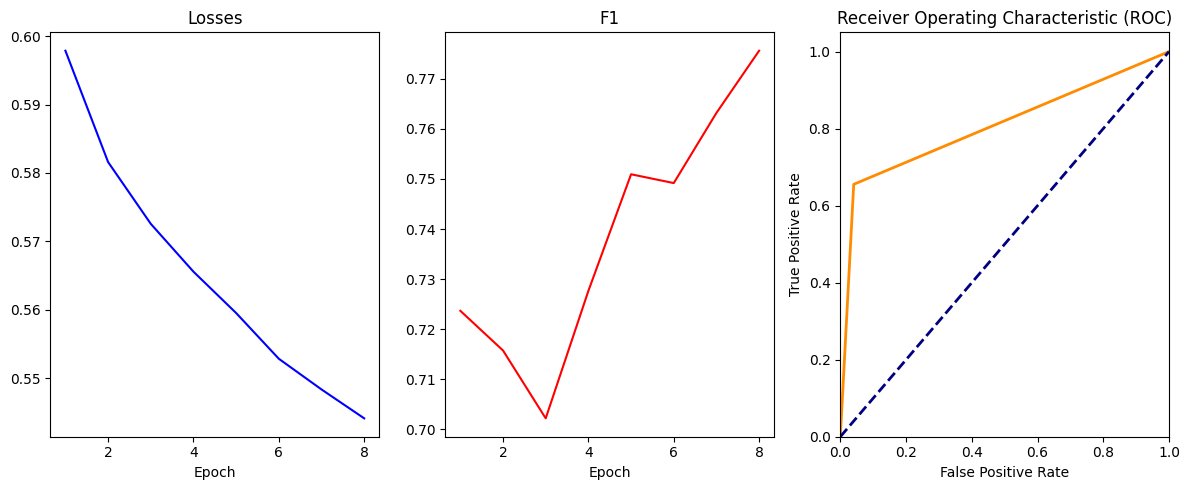

Training epoch 9:   0%|          | 0/10902 [00:00<?, ?it/s]

Testing:   0%|          | 0/2726 [00:00<?, ?it/s]

              precision    recall  f1-score   support

         0.0       0.71      0.95      0.81      1252
         1.0       0.94      0.66      0.78      1474

    accuracy                           0.79      2726
   macro avg       0.82      0.81      0.79      2726
weighted avg       0.83      0.79      0.79      2726

Min Loss = 0.540717461318122, Curr F1 = 0.7775567051333068, Max F1 = 0.7775567051333068, Curr AUC_ROC = 0.8066507428006642, Max AUC_ROC = 0.8073123707630884


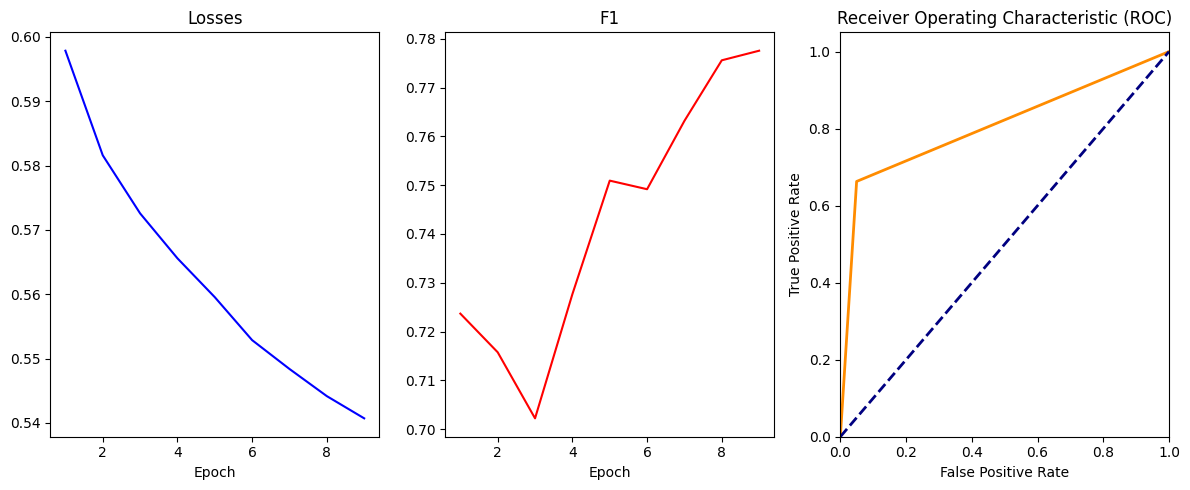

Training epoch 10:   0%|          | 0/10902 [00:00<?, ?it/s]

Testing:   0%|          | 0/2726 [00:00<?, ?it/s]

              precision    recall  f1-score   support

         0.0       0.68      0.96      0.80      1252
         1.0       0.95      0.61      0.74      1474

    accuracy                           0.77      2726
   macro avg       0.81      0.79      0.77      2726
weighted avg       0.82      0.77      0.77      2726

Min Loss = 0.5385346439393851, Curr F1 = 0.7444352844187965, Max F1 = 0.7775567051333068, Curr AUC_ROC = 0.786740672183665, Max AUC_ROC = 0.8073123707630884


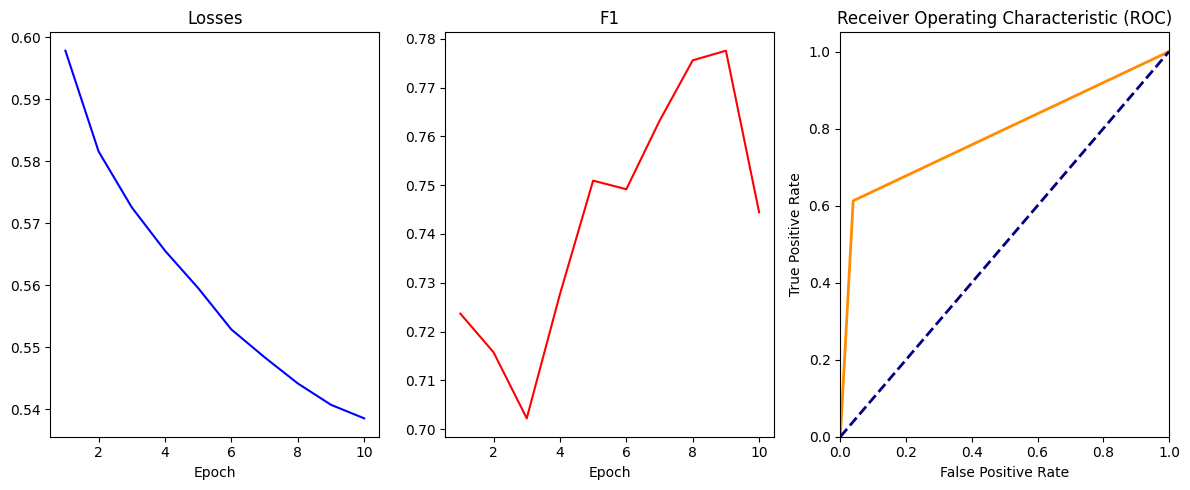

In [53]:
model_gru = OtchislenieModel_GRU(hidden_dim=128, input_size=max_subjects_per_semestr, num_classes = 1).to(device)
criterion = nn.BCELoss()
optimizer = torch.optim.Adam(model_gru.parameters())

model_gru = train_model(model_gru, optimizer, criterion, num_epoch=10)

Training epoch 1:   0%|          | 0/10902 [00:00<?, ?it/s]

Testing:   0%|          | 0/2726 [00:00<?, ?it/s]

              precision    recall  f1-score   support

         0.0       0.63      0.87      0.73      1252
         1.0       0.83      0.57      0.68      1474

    accuracy                           0.71      2726
   macro avg       0.73      0.72      0.71      2726
weighted avg       0.74      0.71      0.70      2726

Min Loss = 0.7462813881226055, Curr F1 = 0.6797910807553235, Max F1 = 0.6797910807553235, Curr AUC_ROC = 0.7194822070304879, Max AUC_ROC = 0.7194822070304879


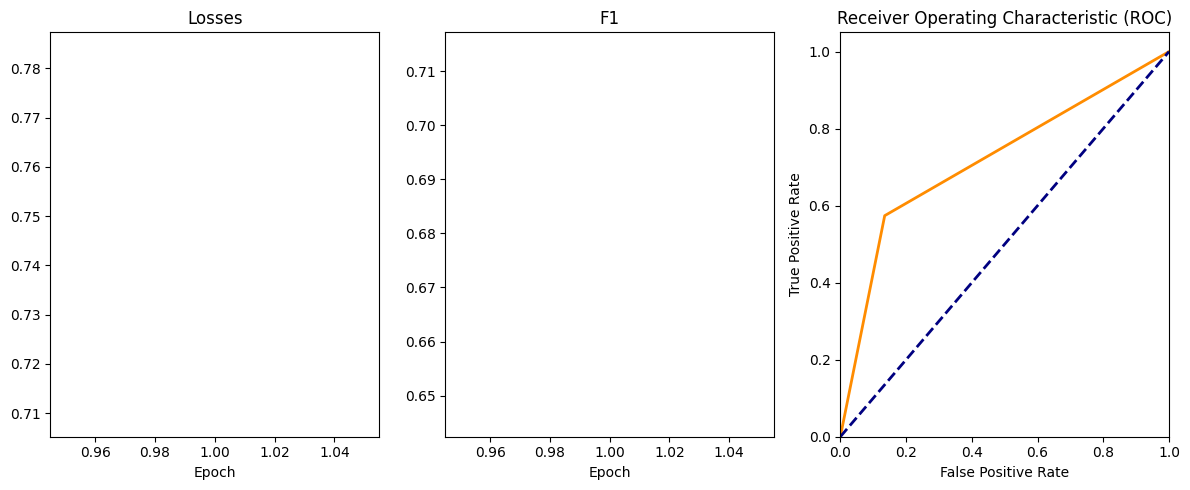

Training epoch 2:   0%|          | 0/10902 [00:00<?, ?it/s]

Testing:   0%|          | 0/2726 [00:00<?, ?it/s]

              precision    recall  f1-score   support

         0.0       0.56      1.00      0.72      1252
         1.0       0.99      0.33      0.49      1474

    accuracy                           0.64      2726
   macro avg       0.78      0.66      0.61      2726
weighted avg       0.79      0.64      0.60      2726

Min Loss = 0.6449880674440387, Curr F1 = 0.49439347604485223, Max F1 = 0.6797910807553235, Curr AUC_ROC = 0.6633202344362995, Max AUC_ROC = 0.7194822070304879


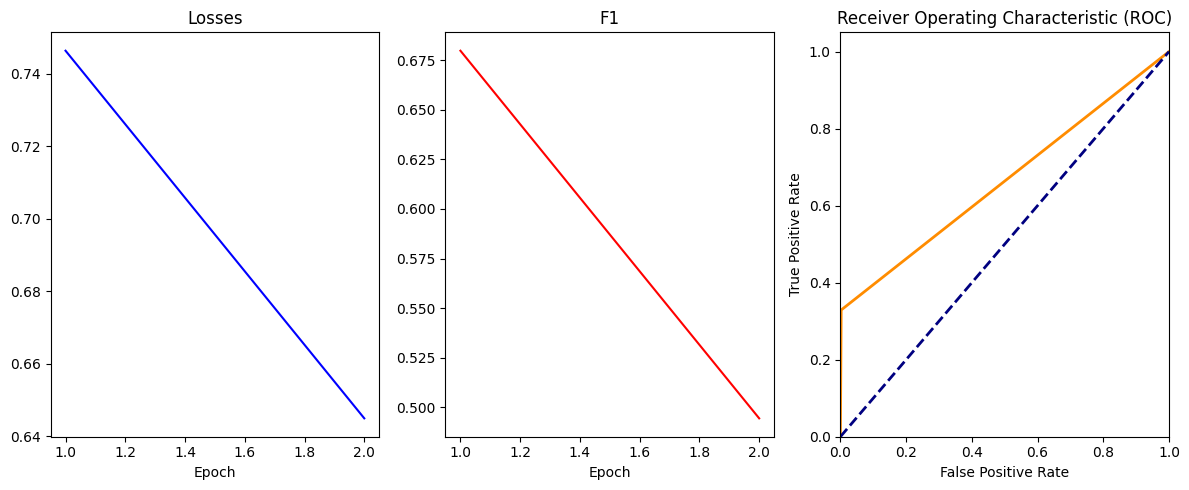

Training epoch 3:   0%|          | 0/10902 [00:00<?, ?it/s]

Testing:   0%|          | 0/2726 [00:00<?, ?it/s]

              precision    recall  f1-score   support

         0.0       0.62      0.90      0.74      1252
         1.0       0.86      0.54      0.66      1474

    accuracy                           0.70      2726
   macro avg       0.74      0.72      0.70      2726
weighted avg       0.75      0.70      0.70      2726

Min Loss = 0.6449880674440387, Curr F1 = 0.6641697877652933, Max F1 = 0.6797910807553235, Curr AUC_ROC = 0.7183757006428791, Max AUC_ROC = 0.7194822070304879


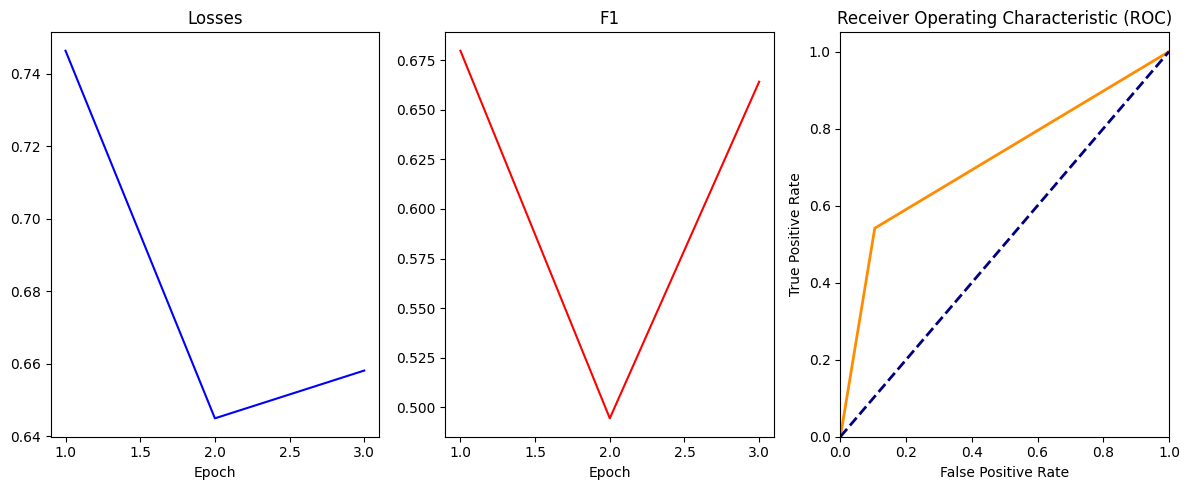

Training epoch 4:   0%|          | 0/10902 [00:00<?, ?it/s]

Testing:   0%|          | 0/2726 [00:00<?, ?it/s]

              precision    recall  f1-score   support

         0.0       0.62      0.97      0.76      1252
         1.0       0.95      0.49      0.65      1474

    accuracy                           0.71      2726
   macro avg       0.79      0.73      0.70      2726
weighted avg       0.80      0.71      0.70      2726

Min Loss = 0.6449880674440387, Curr F1 = 0.6496644295302013, Max F1 = 0.6797910807553235, Curr AUC_ROC = 0.7322910209336703, Max AUC_ROC = 0.7322910209336703


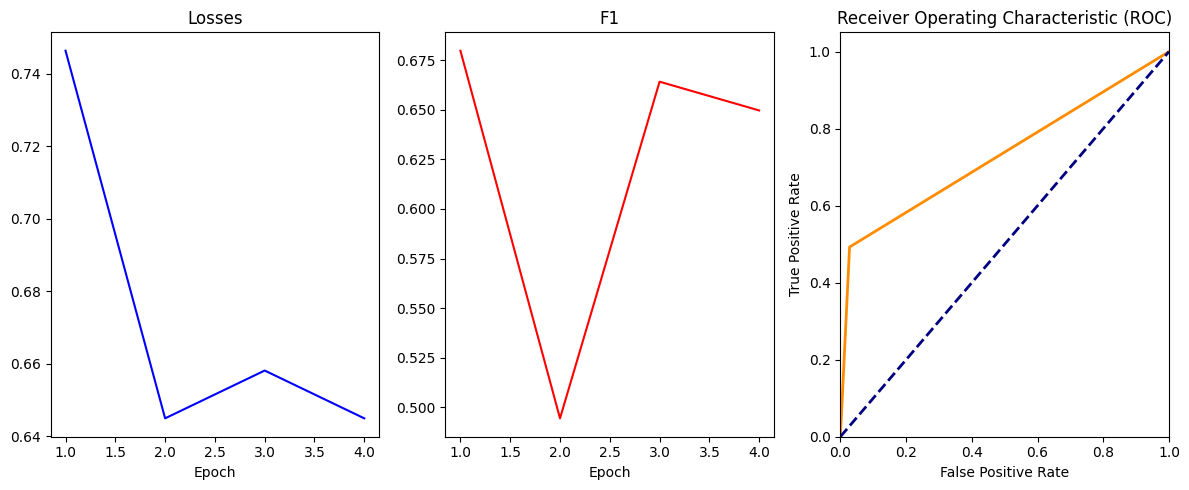

Training epoch 5:   0%|          | 0/10902 [00:00<?, ?it/s]

Testing:   0%|          | 0/2726 [00:00<?, ?it/s]

              precision    recall  f1-score   support

         0.0       0.59      0.98      0.74      1252
         1.0       0.97      0.41      0.58      1474

    accuracy                           0.67      2726
   macro avg       0.78      0.70      0.66      2726
weighted avg       0.79      0.67      0.65      2726

Min Loss = 0.6395121341538066, Curr F1 = 0.5780952380952381, Max F1 = 0.6797910807553235, Curr AUC_ROC = 0.6983144472236552, Max AUC_ROC = 0.7322910209336703


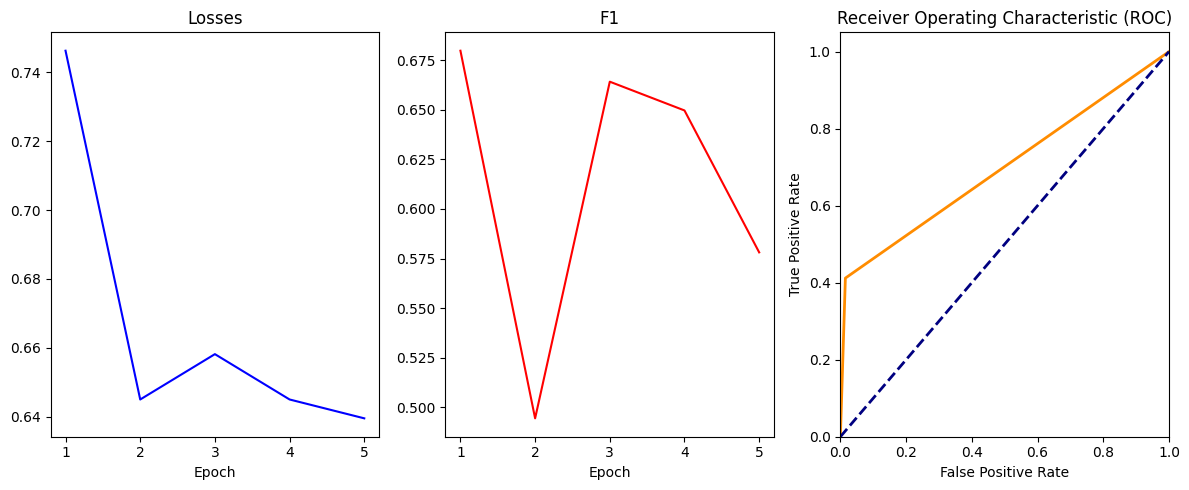

Training epoch 6:   0%|          | 0/10902 [00:00<?, ?it/s]

Testing:   0%|          | 0/2726 [00:00<?, ?it/s]

              precision    recall  f1-score   support

         0.0       0.64      0.95      0.76      1252
         1.0       0.93      0.54      0.68      1474

    accuracy                           0.73      2726
   macro avg       0.78      0.75      0.72      2726
weighted avg       0.79      0.73      0.72      2726

Min Loss = 0.6266462390405544, Curr F1 = 0.6824034334763949, Max F1 = 0.6824034334763949, Curr AUC_ROC = 0.7453133331310337, Max AUC_ROC = 0.7453133331310337


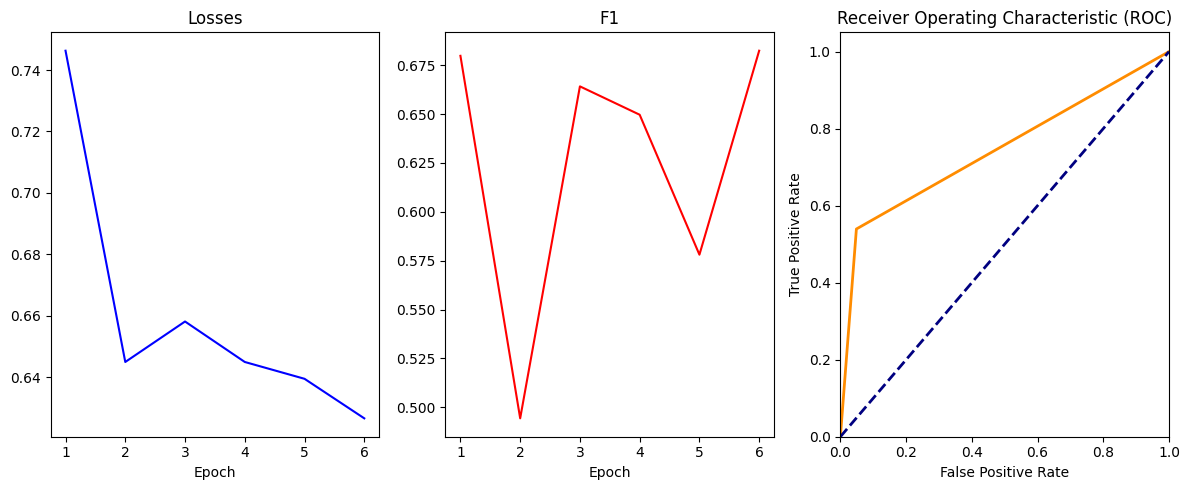

Training epoch 7:   0%|          | 0/10902 [00:00<?, ?it/s]

Testing:   0%|          | 0/2726 [00:00<?, ?it/s]

              precision    recall  f1-score   support

         0.0       0.63      0.99      0.77      1252
         1.0       0.99      0.50      0.66      1474

    accuracy                           0.73      2726
   macro avg       0.81      0.75      0.72      2726
weighted avg       0.82      0.73      0.71      2726

Min Loss = 0.6221673750747259, Curr F1 = 0.6624548736462094, Max F1 = 0.6824034334763949, Curr AUC_ROC = 0.7457874727437458, Max AUC_ROC = 0.7457874727437458


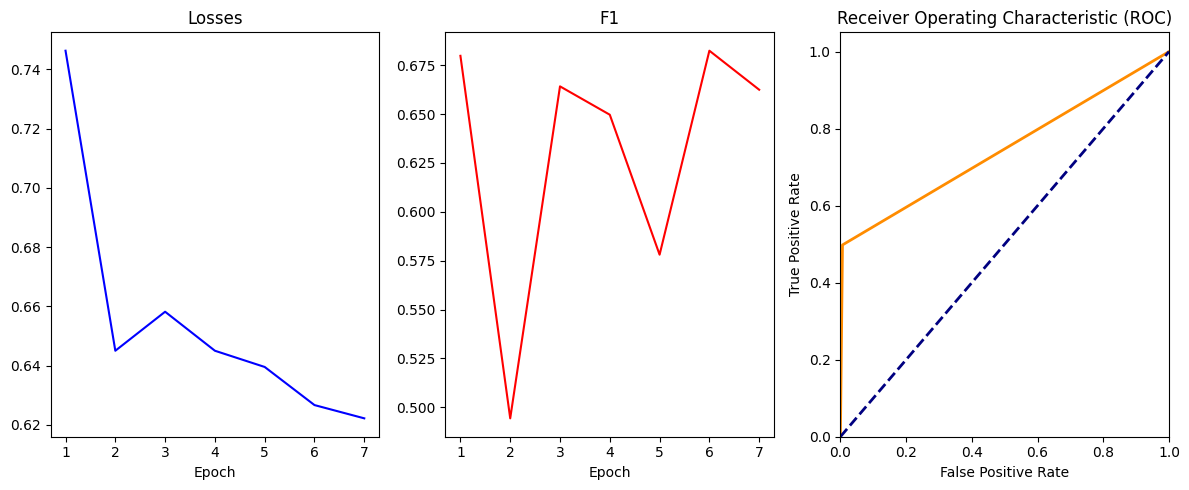

Training epoch 8:   0%|          | 0/10902 [00:00<?, ?it/s]

Testing:   0%|          | 0/2726 [00:00<?, ?it/s]

              precision    recall  f1-score   support

         0.0       0.63      1.00      0.77      1252
         1.0       0.99      0.50      0.67      1474

    accuracy                           0.73      2726
   macro avg       0.81      0.75      0.72      2726
weighted avg       0.83      0.73      0.71      2726

Min Loss = 0.6178664500626746, Curr F1 = 0.6660649819494585, Max F1 = 0.6824034334763949, Curr AUC_ROC = 0.7487417689363234, Max AUC_ROC = 0.7487417689363234


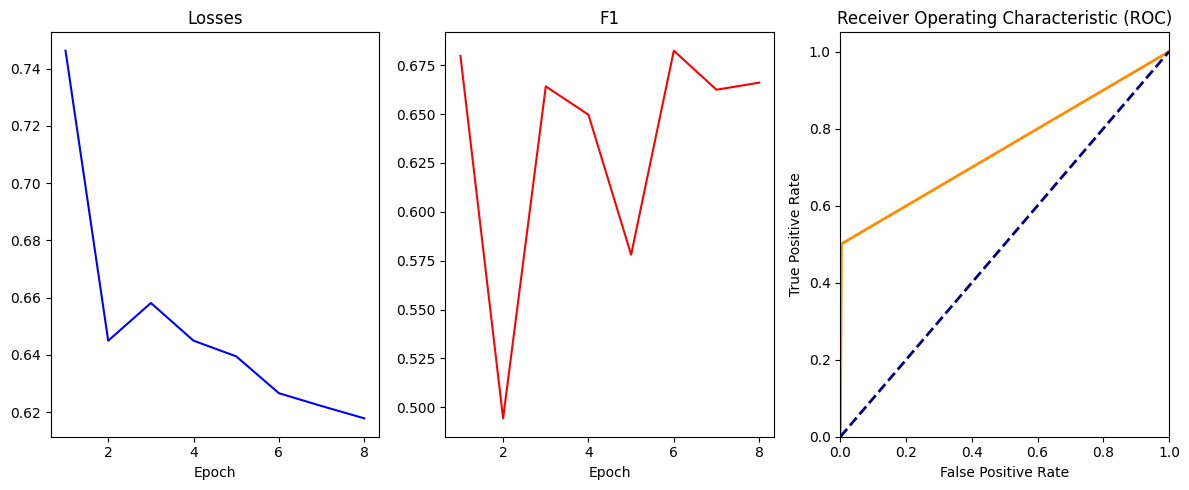

Training epoch 9:   0%|          | 0/10902 [00:00<?, ?it/s]

Testing:   0%|          | 0/2726 [00:00<?, ?it/s]

              precision    recall  f1-score   support

         0.0       0.68      0.89      0.77      1252
         1.0       0.87      0.64      0.74      1474

    accuracy                           0.75      2726
   macro avg       0.77      0.76      0.75      2726
weighted avg       0.78      0.75      0.75      2726

Min Loss = 0.6157475818140619, Curr F1 = 0.7356051703877792, Max F1 = 0.7356051703877792, Curr AUC_ROC = 0.7626104880766079, Max AUC_ROC = 0.7626104880766079


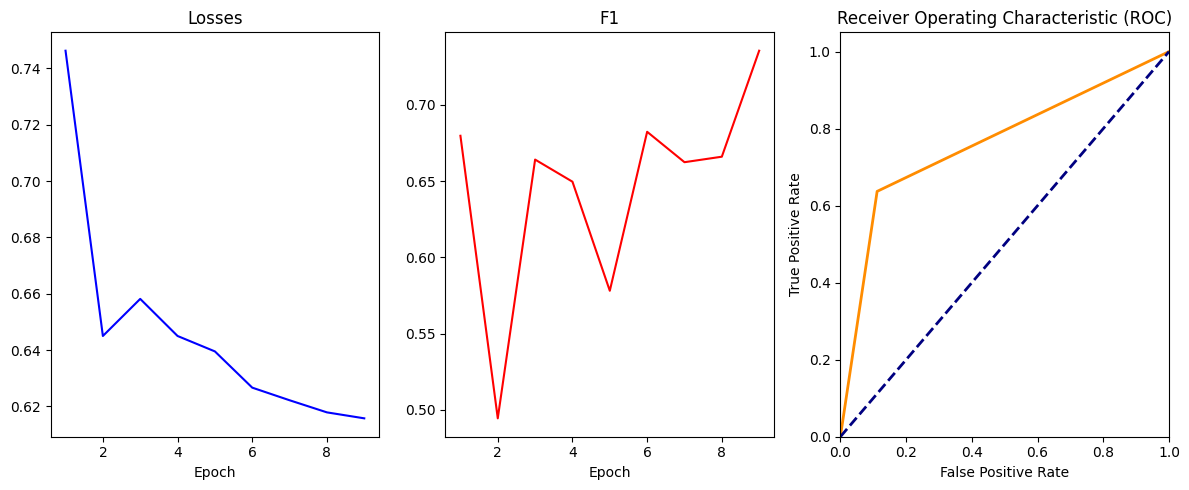

Training epoch 10:   0%|          | 0/10902 [00:00<?, ?it/s]

Testing:   0%|          | 0/2726 [00:00<?, ?it/s]

              precision    recall  f1-score   support

         0.0       0.62      0.99      0.76      1252
         1.0       0.98      0.48      0.65      1474

    accuracy                           0.72      2726
   macro avg       0.80      0.74      0.70      2726
weighted avg       0.82      0.72      0.70      2726

Min Loss = 0.6134126893267066, Curr F1 = 0.6469517743403094, Max F1 = 0.7356051703877792, Curr AUC_ROC = 0.7359887680389802, Max AUC_ROC = 0.7626104880766079


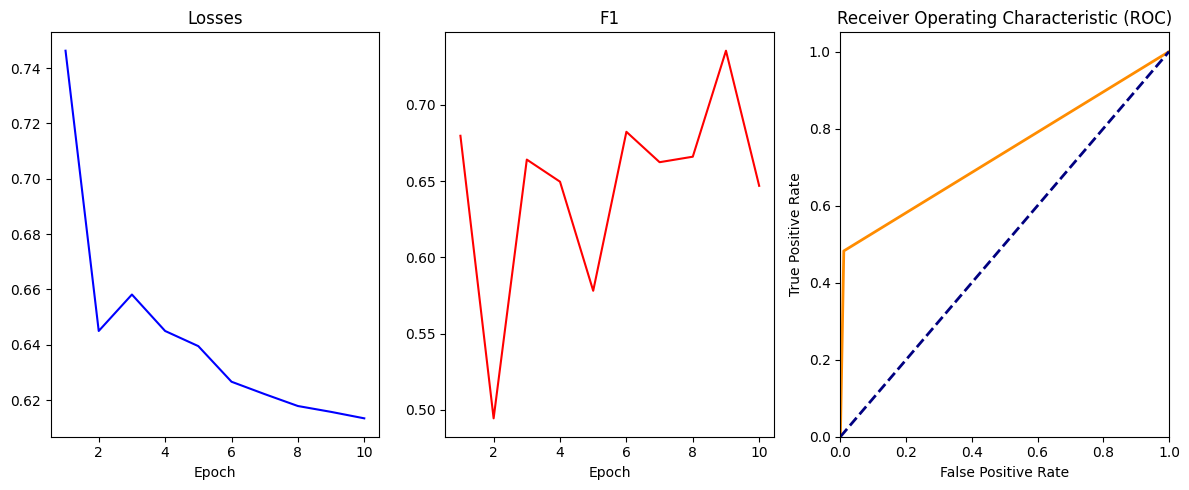

In [54]:
model_gru = OtchislenieModel_GRU(hidden_dim=512, input_size=max_subjects_per_semestr, num_classes = 1).to(device)
criterion = nn.BCELoss()
optimizer = torch.optim.Adam(model_gru.parameters())

model_gru = train_model(model_gru, optimizer, criterion, num_epoch=10)

LSTM Base Structure

Training epoch 1:   0%|          | 0/10902 [00:00<?, ?it/s]

Testing:   0%|          | 0/2726 [00:00<?, ?it/s]

              precision    recall  f1-score   support

         0.0       0.65      0.97      0.78      1252
         1.0       0.95      0.57      0.71      1474

    accuracy                           0.75      2726
   macro avg       0.80      0.77      0.75      2726
weighted avg       0.82      0.75      0.74      2726

Min Loss = 0.6323220668265938, Curr F1 = 0.7100893997445722, Max F1 = 0.7100893997445722, Curr AUC_ROC = 0.7665298615837456, Max AUC_ROC = 0.7665298615837456


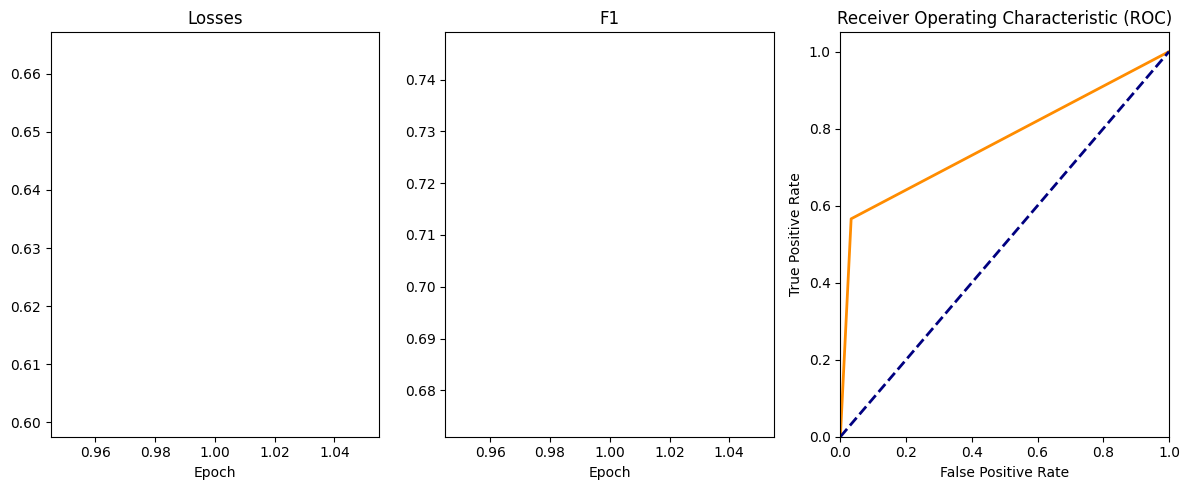

Training epoch 2:   0%|          | 0/10902 [00:00<?, ?it/s]

Testing:   0%|          | 0/2726 [00:00<?, ?it/s]

              precision    recall  f1-score   support

         0.0       0.70      0.95      0.80      1252
         1.0       0.94      0.65      0.77      1474

    accuracy                           0.79      2726
   macro avg       0.82      0.80      0.79      2726
weighted avg       0.83      0.79      0.78      2726

Min Loss = 0.5865765575465096, Curr F1 = 0.7667603372139703, Max F1 = 0.7667603372139703, Curr AUC_ROC = 0.7991880562334999, Max AUC_ROC = 0.7991880562334999


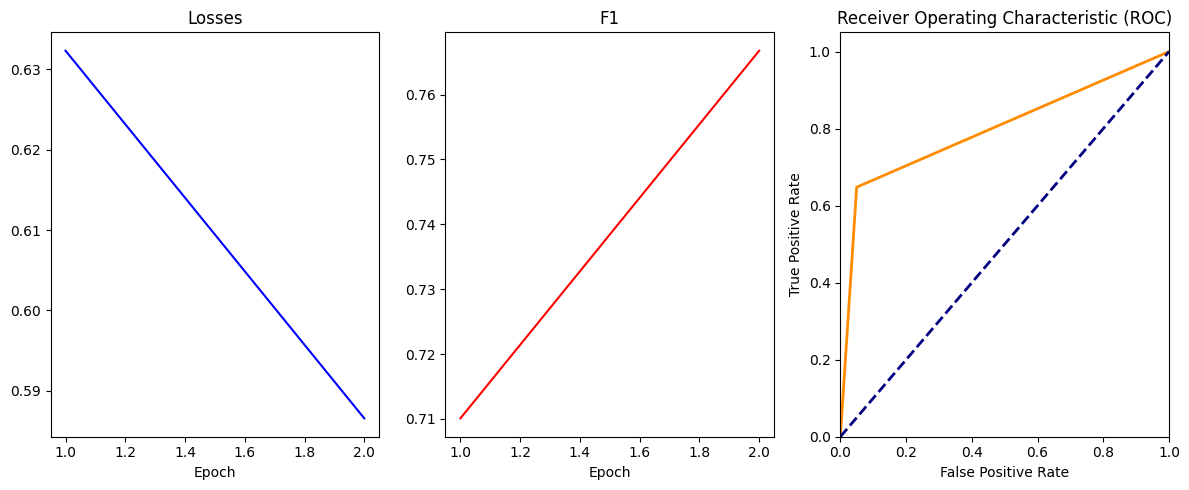

Training epoch 3:   0%|          | 0/10902 [00:00<?, ?it/s]

Testing:   0%|          | 0/2726 [00:00<?, ?it/s]

              precision    recall  f1-score   support

         0.0       0.68      0.97      0.80      1252
         1.0       0.96      0.61      0.74      1474

    accuracy                           0.77      2726
   macro avg       0.82      0.79      0.77      2726
weighted avg       0.83      0.77      0.77      2726

Min Loss = 0.5779426799790834, Curr F1 = 0.7449191206968063, Max F1 = 0.7667603372139703, Curr AUC_ROC = 0.7890382172784062, Max AUC_ROC = 0.7991880562334999


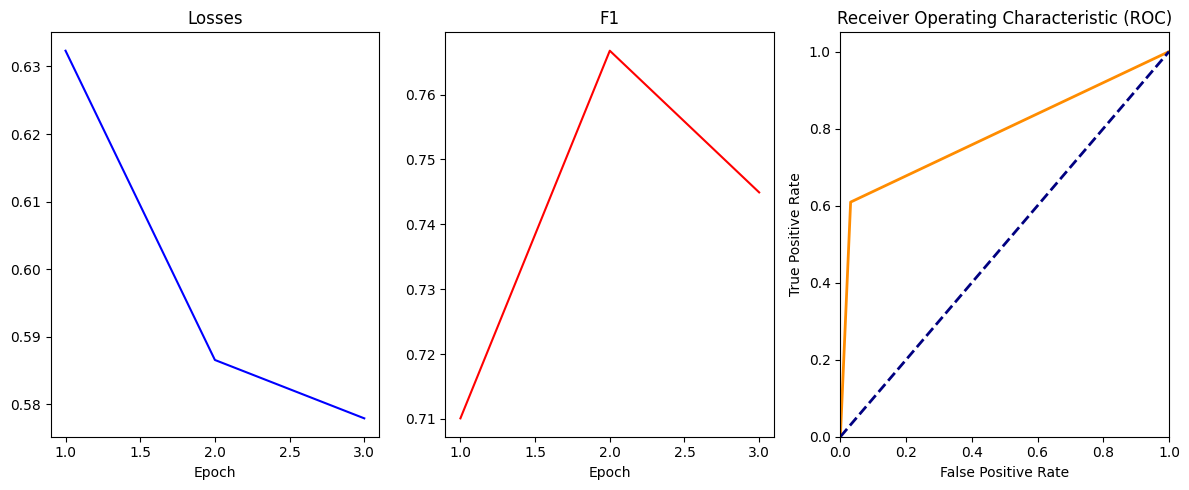

Training epoch 4:   0%|          | 0/10902 [00:00<?, ?it/s]

Testing:   0%|          | 0/2726 [00:00<?, ?it/s]

              precision    recall  f1-score   support

         0.0       0.68      0.98      0.80      1252
         1.0       0.97      0.61      0.75      1474

    accuracy                           0.78      2726
   macro avg       0.83      0.79      0.77      2726
weighted avg       0.84      0.78      0.77      2726

Min Loss = 0.5708443728297637, Curr F1 = 0.7461313258051024, Max F1 = 0.7667603372139703, Curr AUC_ROC = 0.7925939934368241, Max AUC_ROC = 0.7991880562334999


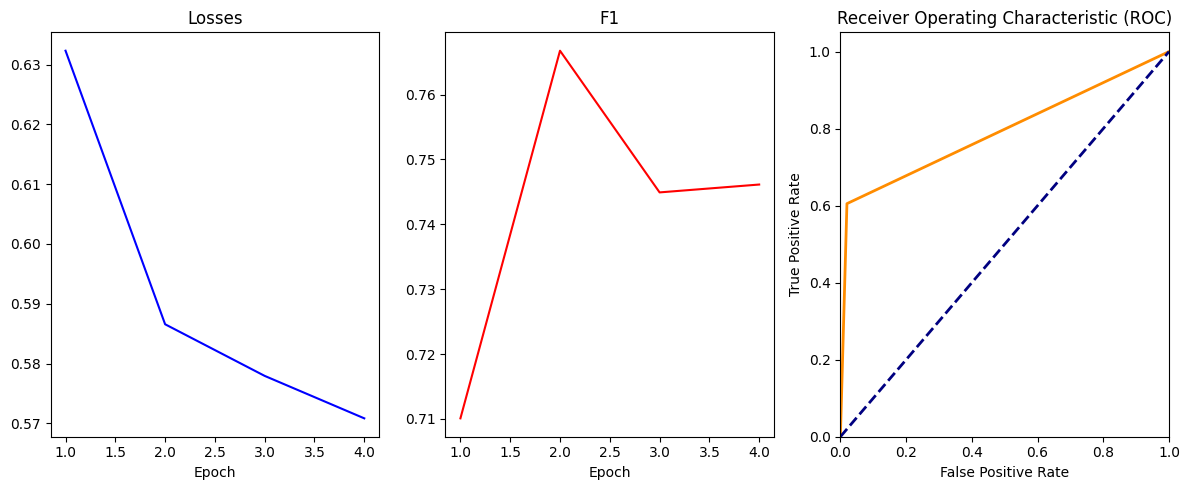

Training epoch 5:   0%|          | 0/10902 [00:00<?, ?it/s]

Testing:   0%|          | 0/2726 [00:00<?, ?it/s]

              precision    recall  f1-score   support

         0.0       0.69      0.98      0.80      1252
         1.0       0.97      0.62      0.76      1474

    accuracy                           0.78      2726
   macro avg       0.83      0.80      0.78      2726
weighted avg       0.84      0.78      0.78      2726

Min Loss = 0.564704476051146, Curr F1 = 0.7551695616211745, Max F1 = 0.7667603372139703, Curr AUC_ROC = 0.7973213008440226, Max AUC_ROC = 0.7991880562334999


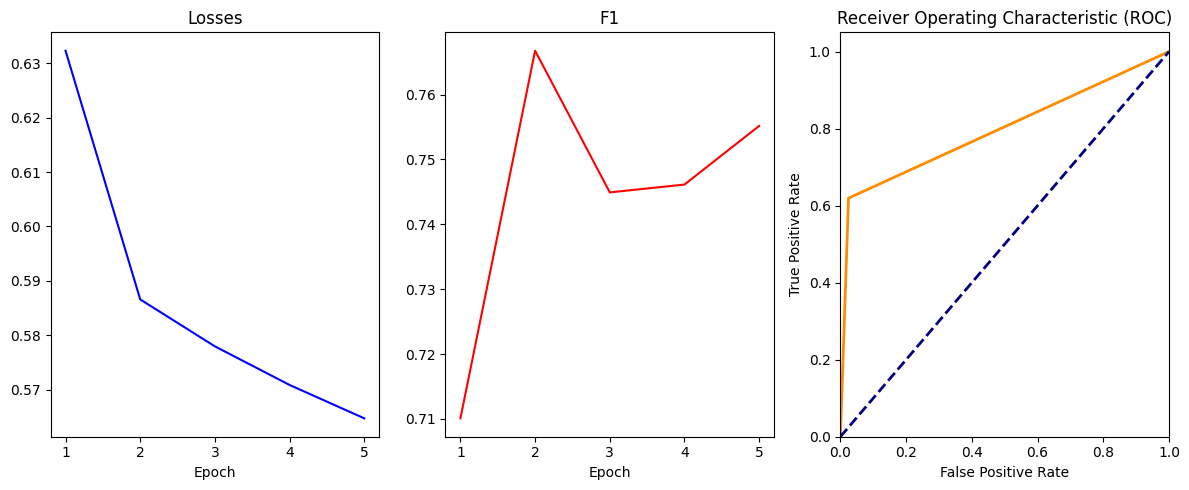

Training epoch 6:   0%|          | 0/10902 [00:00<?, ?it/s]

Testing:   0%|          | 0/2726 [00:00<?, ?it/s]

              precision    recall  f1-score   support

         0.0       0.66      0.98      0.79      1252
         1.0       0.97      0.57      0.72      1474

    accuracy                           0.76      2726
   macro avg       0.82      0.78      0.76      2726
weighted avg       0.83      0.76      0.75      2726

Min Loss = 0.5625727667658291, Curr F1 = 0.7212276214833762, Max F1 = 0.7667603372139703, Curr AUC_ROC = 0.776590833228571, Max AUC_ROC = 0.7991880562334999


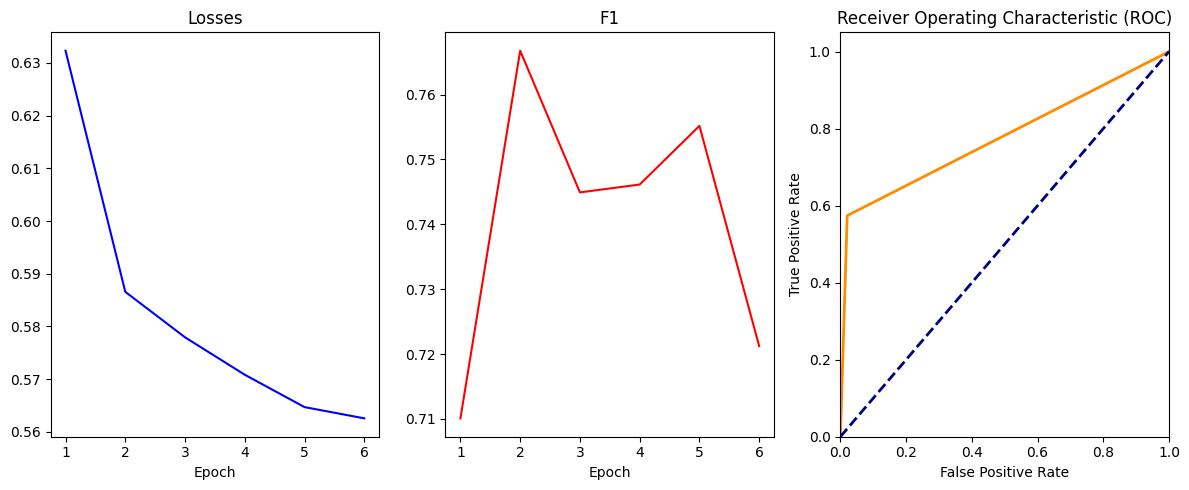

Training epoch 7:   0%|          | 0/10902 [00:00<?, ?it/s]

Testing:   0%|          | 0/2726 [00:00<?, ?it/s]

              precision    recall  f1-score   support

         0.0       0.69      0.97      0.81      1252
         1.0       0.96      0.63      0.76      1474

    accuracy                           0.79      2726
   macro avg       0.83      0.80      0.79      2726
weighted avg       0.84      0.79      0.79      2726

Min Loss = 0.5587354305604689, Curr F1 = 0.764946764946765, Max F1 = 0.7667603372139703, Curr AUC_ROC = 0.803246691318314, Max AUC_ROC = 0.803246691318314


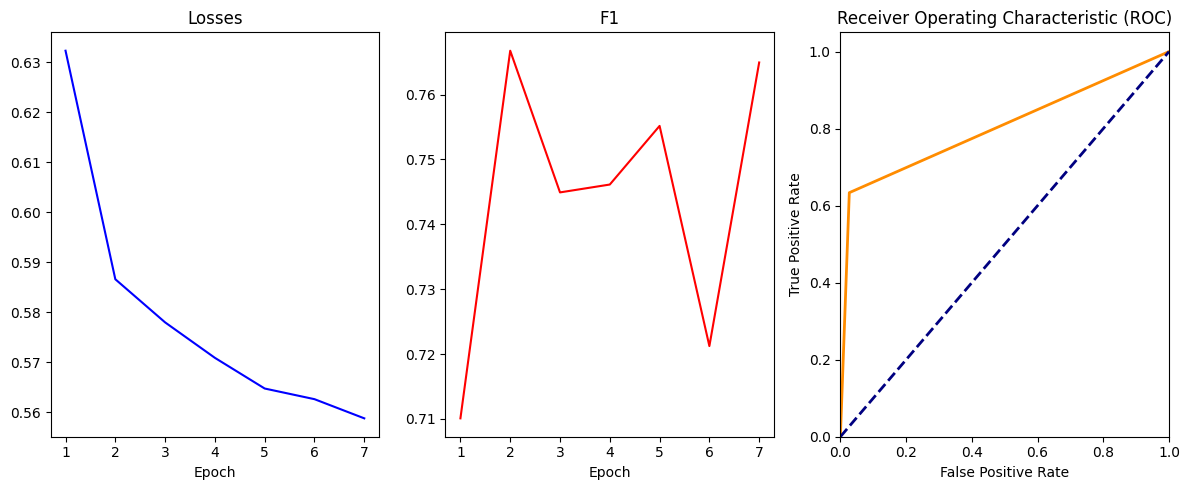

Training epoch 8:   0%|          | 0/10902 [00:00<?, ?it/s]

Testing:   0%|          | 0/2726 [00:00<?, ?it/s]

              precision    recall  f1-score   support

         0.0       0.70      0.96      0.81      1252
         1.0       0.96      0.64      0.77      1474

    accuracy                           0.79      2726
   macro avg       0.83      0.80      0.79      2726
weighted avg       0.84      0.79      0.79      2726

Min Loss = 0.555063810316363, Curr F1 = 0.7668562144597888, Max F1 = 0.7668562144597888, Curr AUC_ROC = 0.8026452113524737, Max AUC_ROC = 0.803246691318314


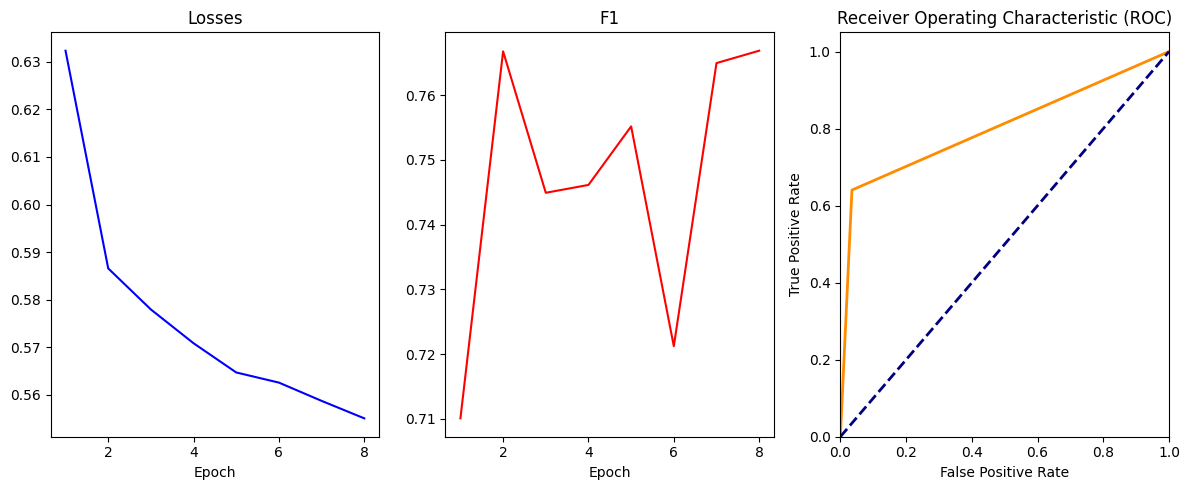

Training epoch 9:   0%|          | 0/10902 [00:00<?, ?it/s]

Testing:   0%|          | 0/2726 [00:00<?, ?it/s]

              precision    recall  f1-score   support

         0.0       0.69      0.98      0.81      1252
         1.0       0.97      0.63      0.76      1474

    accuracy                           0.79      2726
   macro avg       0.83      0.80      0.79      2726
weighted avg       0.84      0.79      0.78      2726

Min Loss = 0.5526906485990348, Curr F1 = 0.7634718222953517, Max F1 = 0.7668562144597888, Curr AUC_ROC = 0.803208218275454, Max AUC_ROC = 0.803246691318314


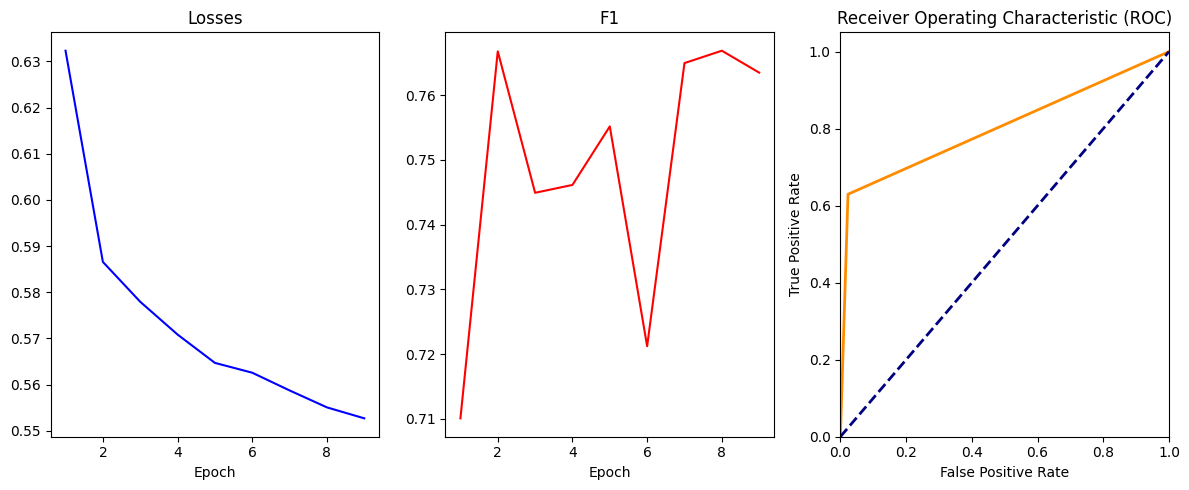

Training epoch 10:   0%|          | 0/10902 [00:00<?, ?it/s]

Testing:   0%|          | 0/2726 [00:00<?, ?it/s]

              precision    recall  f1-score   support

         0.0       0.70      0.97      0.81      1252
         1.0       0.96      0.64      0.77      1474

    accuracy                           0.79      2726
   macro avg       0.83      0.81      0.79      2726
weighted avg       0.84      0.79      0.79      2726

Min Loss = 0.5482134900958445, Curr F1 = 0.7702922077922078, Max F1 = 0.7702922077922078, Curr AUC_ROC = 0.8055393595484674, Max AUC_ROC = 0.8055393595484674


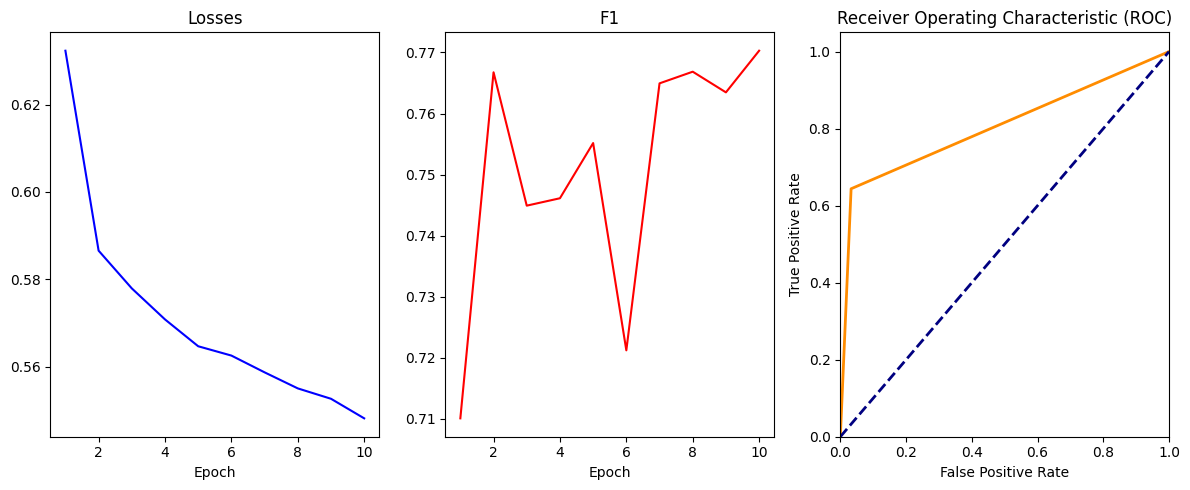

In [55]:
model_lstm = OtchislenieModel_LSTM(hidden_dim=256, input_size=max_subjects_per_semestr, num_classes = 1).to(device)
criterion = nn.BCELoss()
optimizer = torch.optim.Adam(model_lstm.parameters())

model_lstm = train_model(model_lstm, optimizer, criterion, num_epoch=10)

Training epoch 1:   0%|          | 0/10902 [00:00<?, ?it/s]

Testing:   0%|          | 0/2726 [00:00<?, ?it/s]

              precision    recall  f1-score   support

         0.0       0.64      0.98      0.78      1252
         1.0       0.97      0.54      0.69      1474

    accuracy                           0.74      2726
   macro avg       0.81      0.76      0.73      2726
weighted avg       0.82      0.74      0.73      2726

Min Loss = 0.5968846611075829, Curr F1 = 0.6905281536446968, Max F1 = 0.6905281536446968, Curr AUC_ROC = 0.7579341168106607, Max AUC_ROC = 0.7579341168106607


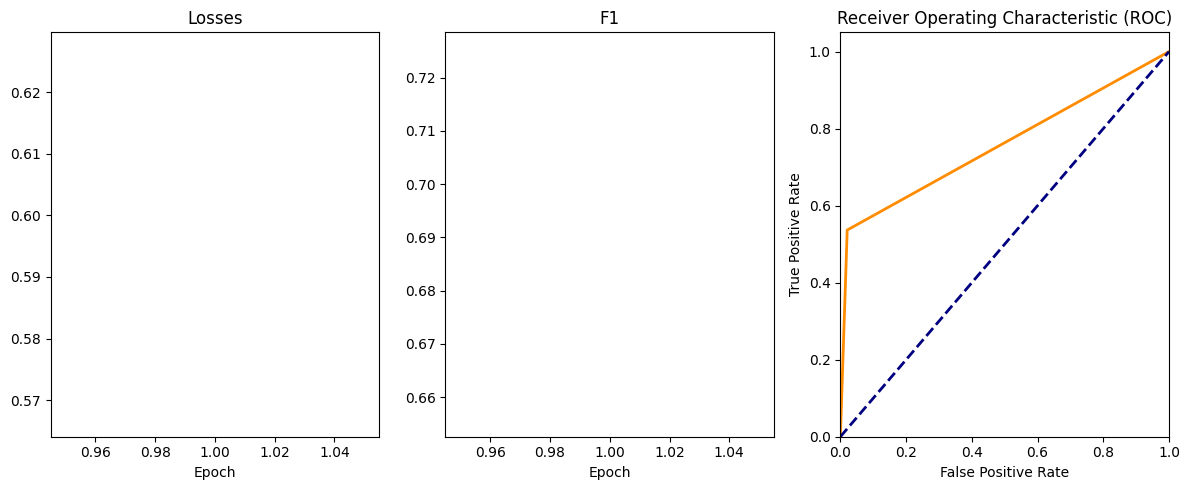

Training epoch 2:   0%|          | 0/10902 [00:00<?, ?it/s]

Testing:   0%|          | 0/2726 [00:00<?, ?it/s]

              precision    recall  f1-score   support

         0.0       0.65      0.98      0.78      1252
         1.0       0.97      0.56      0.71      1474

    accuracy                           0.75      2726
   macro avg       0.81      0.77      0.75      2726
weighted avg       0.83      0.75      0.74      2726

Min Loss = 0.5777760257750033, Curr F1 = 0.7078651685393258, Max F1 = 0.7078651685393258, Curr AUC_ROC = 0.769428886644327, Max AUC_ROC = 0.769428886644327


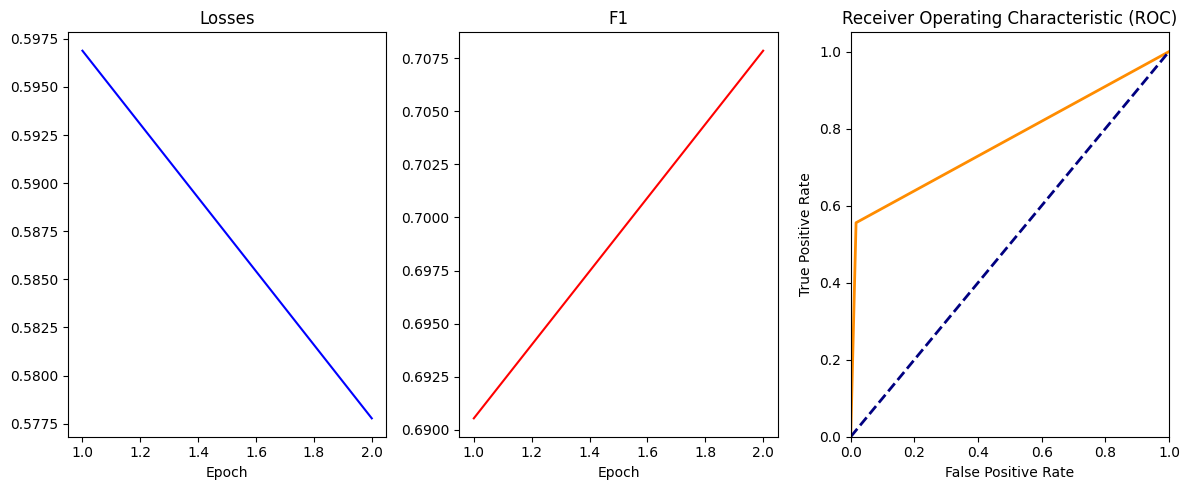

Training epoch 3:   0%|          | 0/10902 [00:00<?, ?it/s]

Testing:   0%|          | 0/2726 [00:00<?, ?it/s]

              precision    recall  f1-score   support

         0.0       0.67      0.98      0.80      1252
         1.0       0.97      0.60      0.74      1474

    accuracy                           0.77      2726
   macro avg       0.82      0.79      0.77      2726
weighted avg       0.84      0.77      0.77      2726

Min Loss = 0.5666622711259102, Curr F1 = 0.7398989898989898, Max F1 = 0.7398989898989898, Curr AUC_ROC = 0.7889829461464098, Max AUC_ROC = 0.7889829461464098


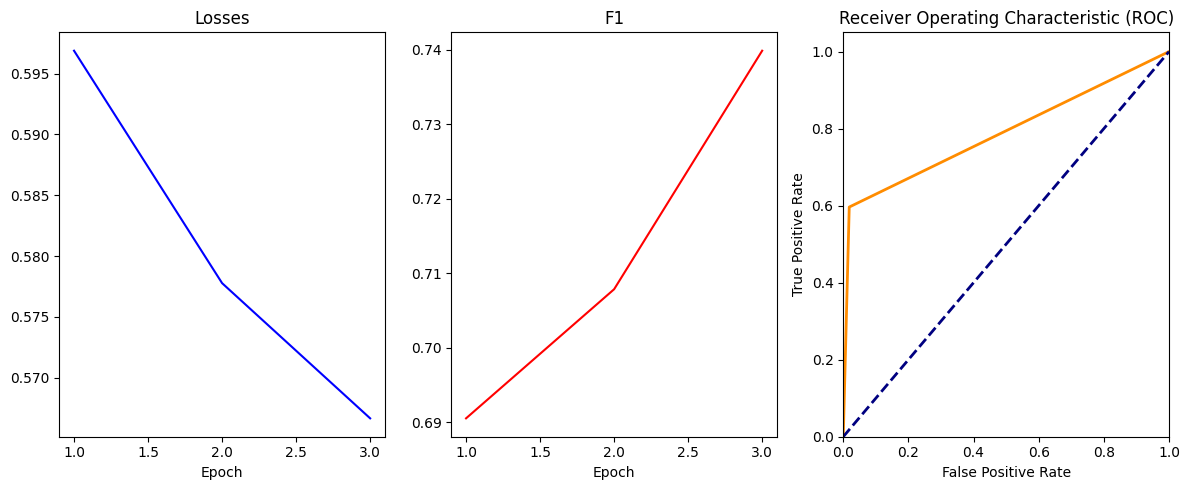

Training epoch 4:   0%|          | 0/10902 [00:00<?, ?it/s]

Testing:   0%|          | 0/2726 [00:00<?, ?it/s]

              precision    recall  f1-score   support

         0.0       0.68      0.99      0.80      1252
         1.0       0.98      0.60      0.75      1474

    accuracy                           0.78      2726
   macro avg       0.83      0.79      0.78      2726
weighted avg       0.84      0.78      0.77      2726

Min Loss = 0.5562710457467263, Curr F1 = 0.7467450650986979, Max F1 = 0.7467450650986979, Curr AUC_ROC = 0.7943718815160329, Max AUC_ROC = 0.7943718815160329


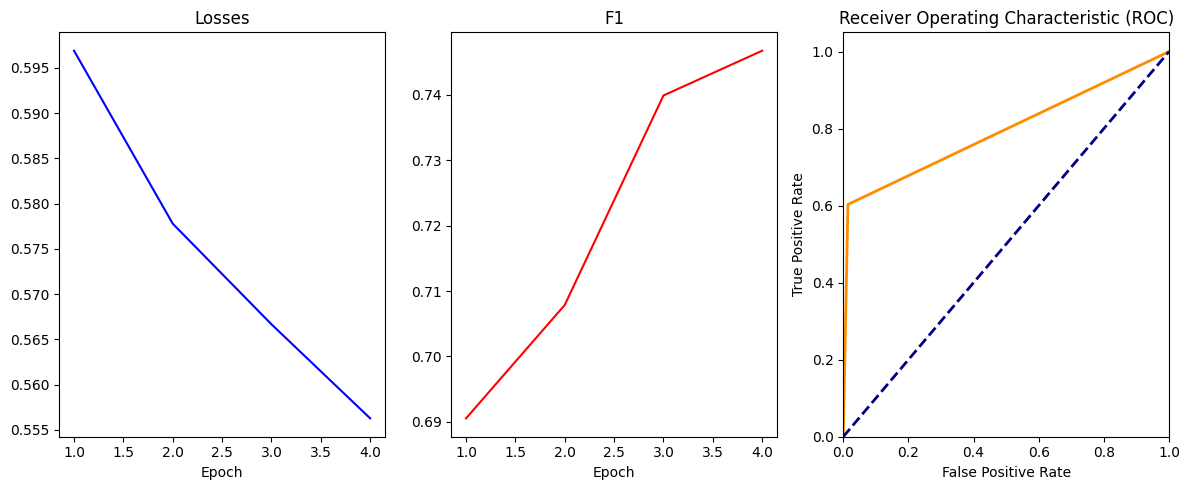

Training epoch 5:   0%|          | 0/10902 [00:00<?, ?it/s]

Testing:   0%|          | 0/2726 [00:00<?, ?it/s]

              precision    recall  f1-score   support

         0.0       0.69      0.98      0.81      1252
         1.0       0.97      0.62      0.76      1474

    accuracy                           0.79      2726
   macro avg       0.83      0.80      0.78      2726
weighted avg       0.84      0.79      0.78      2726

Min Loss = 0.5475615352293784, Curr F1 = 0.7576509511993383, Max F1 = 0.7576509511993383, Curr AUC_ROC = 0.7995370229884561, Max AUC_ROC = 0.7995370229884561


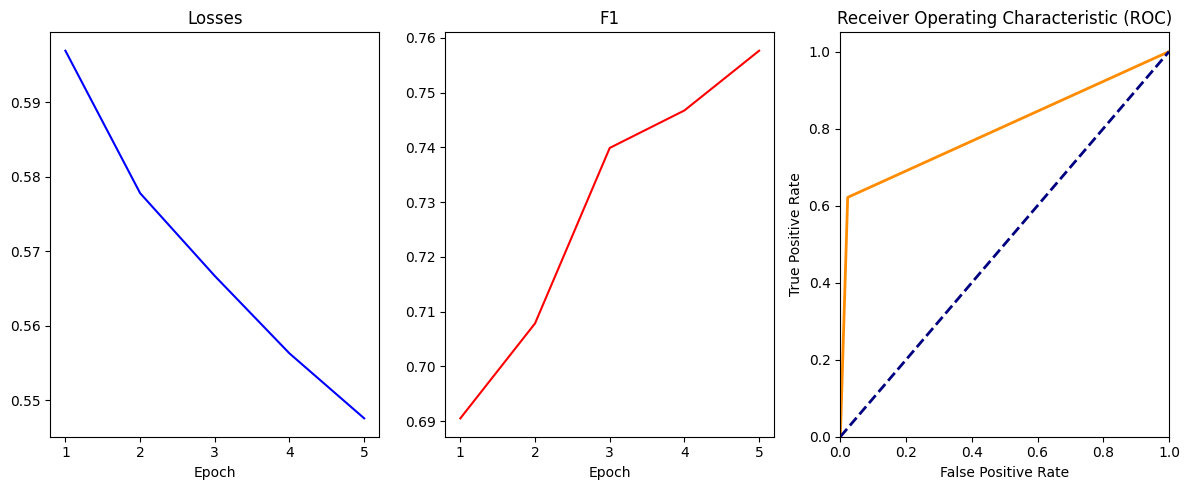

Training epoch 6:   0%|          | 0/10902 [00:00<?, ?it/s]

Testing:   0%|          | 0/2726 [00:00<?, ?it/s]

              precision    recall  f1-score   support

         0.0       0.69      0.98      0.81      1252
         1.0       0.97      0.63      0.76      1474

    accuracy                           0.79      2726
   macro avg       0.83      0.80      0.78      2726
weighted avg       0.84      0.79      0.78      2726

Min Loss = 0.5407449101536804, Curr F1 = 0.7610400330169212, Max F1 = 0.7610400330169212, Curr AUC_ROC = 0.8019716621655012, Max AUC_ROC = 0.8019716621655012


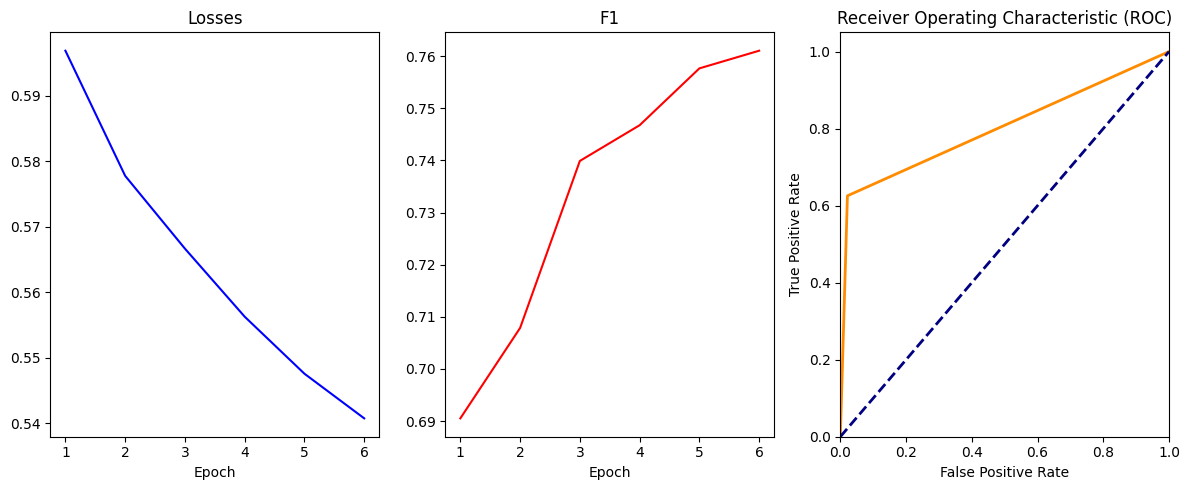

Training epoch 7:   0%|          | 0/10902 [00:00<?, ?it/s]

Testing:   0%|          | 0/2726 [00:00<?, ?it/s]

              precision    recall  f1-score   support

         0.0       0.69      0.98      0.81      1252
         1.0       0.97      0.62      0.76      1474

    accuracy                           0.78      2726
   macro avg       0.83      0.80      0.78      2726
weighted avg       0.84      0.78      0.78      2726

Min Loss = 0.5343928733750716, Curr F1 = 0.7566225165562914, Max F1 = 0.7610400330169212, Curr AUC_ROC = 0.7988585969368955, Max AUC_ROC = 0.8019716621655012


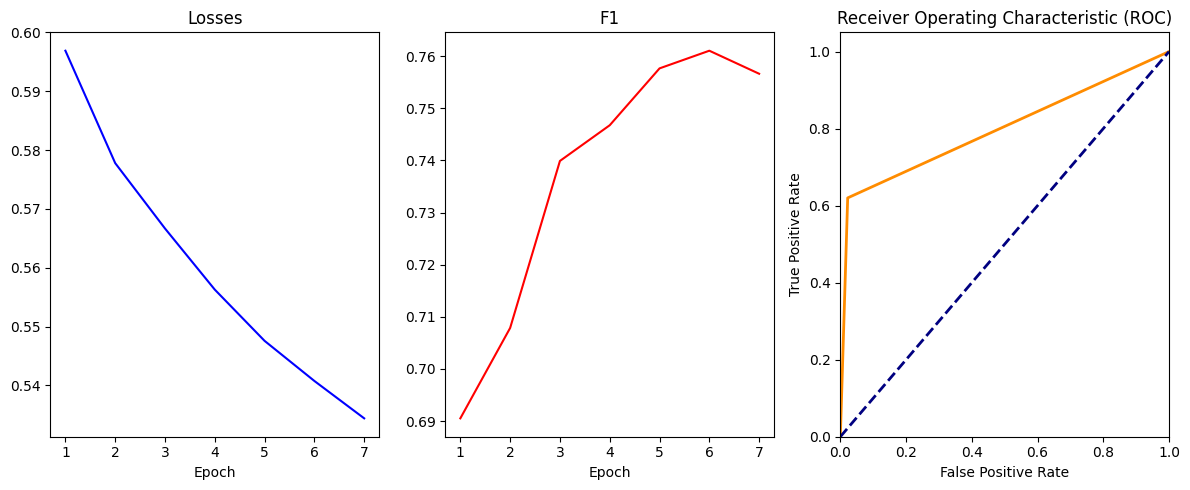

Training epoch 8:   0%|          | 0/10902 [00:00<?, ?it/s]

Testing:   0%|          | 0/2726 [00:00<?, ?it/s]

              precision    recall  f1-score   support

         0.0       0.70      0.96      0.81      1252
         1.0       0.96      0.65      0.77      1474

    accuracy                           0.80      2726
   macro avg       0.83      0.81      0.79      2726
weighted avg       0.84      0.80      0.79      2726

Min Loss = 0.5305484804488654, Curr F1 = 0.774818401937046, Max F1 = 0.774818401937046, Curr AUC_ROC = 0.8080726197649569, Max AUC_ROC = 0.8080726197649569


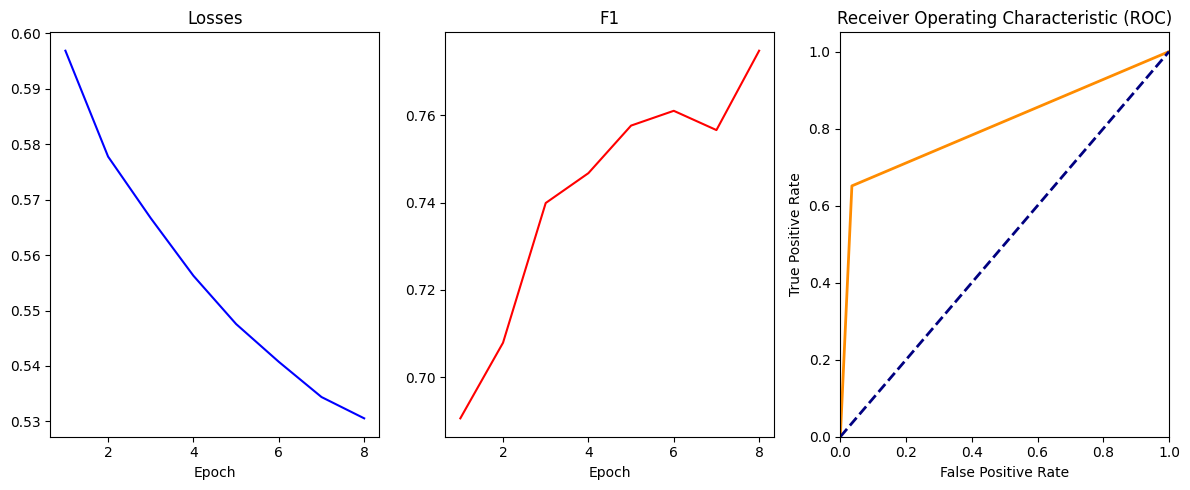

Training epoch 9:   0%|          | 0/10902 [00:00<?, ?it/s]

Testing:   0%|          | 0/2726 [00:00<?, ?it/s]

              precision    recall  f1-score   support

         0.0       0.71      0.96      0.82      1252
         1.0       0.96      0.66      0.78      1474

    accuracy                           0.80      2726
   macro avg       0.83      0.81      0.80      2726
weighted avg       0.84      0.80      0.80      2726

Min Loss = 0.5259391864742233, Curr F1 = 0.7825390468562275, Max F1 = 0.7825390468562275, Curr AUC_ROC = 0.8130405191584916, Max AUC_ROC = 0.8130405191584916


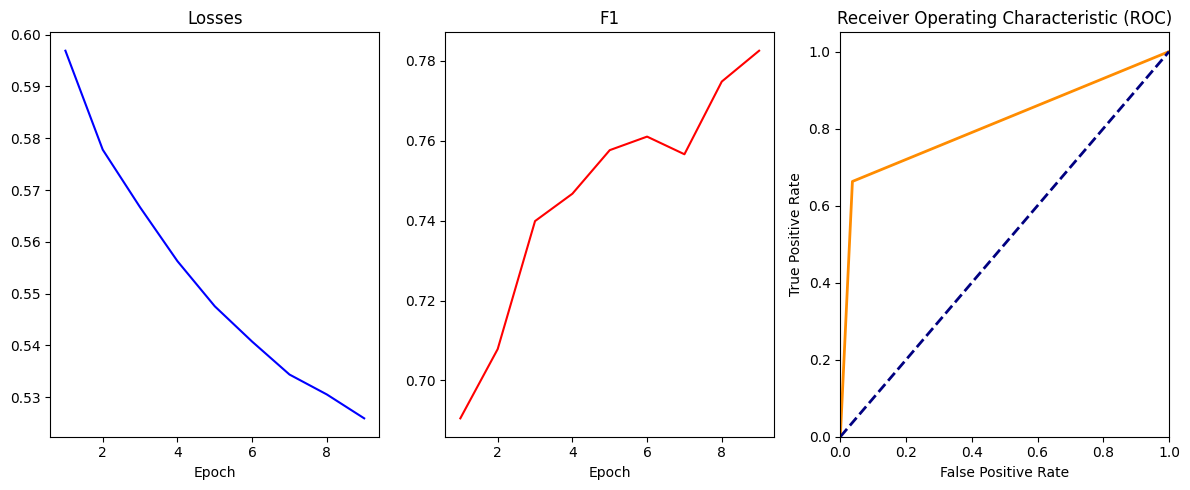

Training epoch 10:   0%|          | 0/10902 [00:00<?, ?it/s]

Testing:   0%|          | 0/2726 [00:00<?, ?it/s]

              precision    recall  f1-score   support

         0.0       0.71      0.96      0.81      1252
         1.0       0.96      0.66      0.78      1474

    accuracy                           0.80      2726
   macro avg       0.83      0.81      0.80      2726
weighted avg       0.84      0.80      0.80      2726

Min Loss = 0.5234156221621541, Curr F1 = 0.7792521109770808, Max F1 = 0.7825390468562275, Curr AUC_ROC = 0.8111255369969785, Max AUC_ROC = 0.8130405191584916


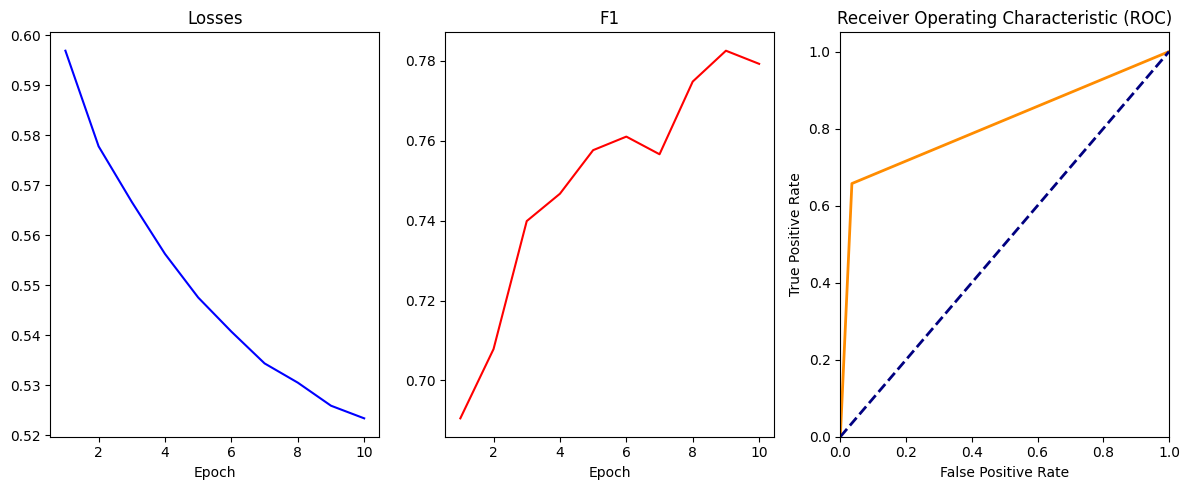

In [56]:
model_lstm = OtchislenieModel_LSTM(hidden_dim=128, input_size=max_subjects_per_semestr, num_classes = 1).to(device)
criterion = nn.BCELoss()
optimizer = torch.optim.Adam(model_lstm.parameters())

model_lstm = train_model(model_lstm, optimizer, criterion, num_epoch=10)

Training epoch 1:   0%|          | 0/10902 [00:00<?, ?it/s]

Testing:   0%|          | 0/2726 [00:00<?, ?it/s]

              precision    recall  f1-score   support

         0.0       0.59      0.96      0.73      1252
         1.0       0.93      0.44      0.60      1474

    accuracy                           0.68      2726
   macro avg       0.76      0.70      0.67      2726
weighted avg       0.77      0.68      0.66      2726

Min Loss = 0.6870340688488633, Curr F1 = 0.6003666361136571, Max F1 = 0.6003666361136571, Curr AUC_ROC = 0.7010183977007209, Max AUC_ROC = 0.7010183977007209


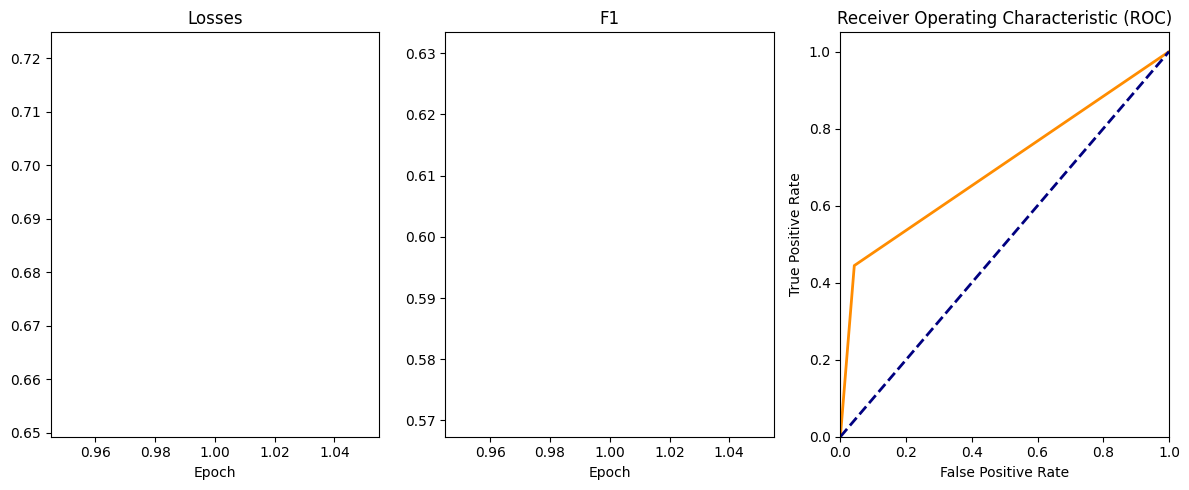

Training epoch 2:   0%|          | 0/10902 [00:00<?, ?it/s]

Testing:   0%|          | 0/2726 [00:00<?, ?it/s]

              precision    recall  f1-score   support

         0.0       0.53      1.00      0.69      1252
         1.0       1.00      0.25      0.40      1474

    accuracy                           0.60      2726
   macro avg       0.77      0.63      0.55      2726
weighted avg       0.78      0.60      0.54      2726

Min Loss = 0.6625713679363391, Curr F1 = 0.4013015184381779, Max F1 = 0.6003666361136571, Curr AUC_ROC = 0.6255088195386703, Max AUC_ROC = 0.7010183977007209


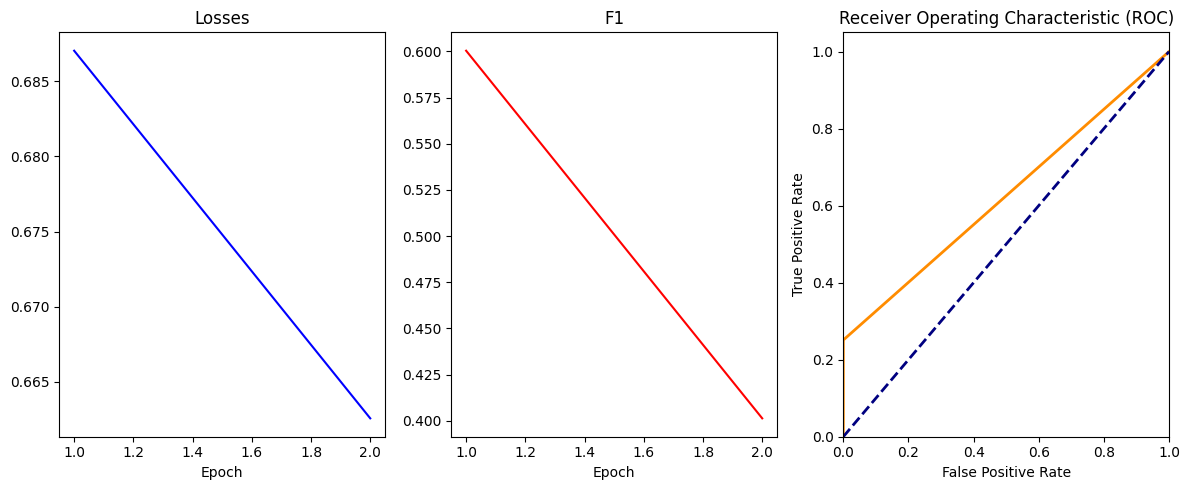

Training epoch 3:   0%|          | 0/10902 [00:00<?, ?it/s]

Testing:   0%|          | 0/2726 [00:00<?, ?it/s]

              precision    recall  f1-score   support

         0.0       0.63      0.06      0.11      1252
         1.0       0.55      0.97      0.70      1474

    accuracy                           0.55      2726
   macro avg       0.59      0.51      0.40      2726
weighted avg       0.58      0.55      0.43      2726

Min Loss = 0.6625713679363391, Curr F1 = 0.7006369426751592, Max F1 = 0.7006369426751592, Curr AUC_ROC = 0.5146273425206238, Max AUC_ROC = 0.7010183977007209


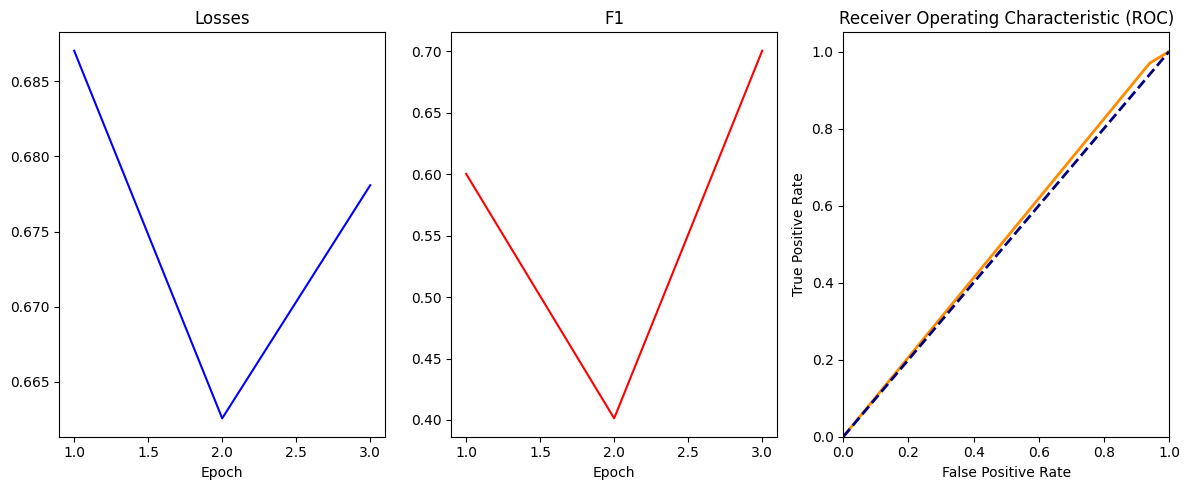

Training epoch 4:   0%|          | 0/10902 [00:00<?, ?it/s]

Testing:   0%|          | 0/2726 [00:00<?, ?it/s]

              precision    recall  f1-score   support

         0.0       0.53      1.00      0.69      1252
         1.0       1.00      0.24      0.39      1474

    accuracy                           0.59      2726
   macro avg       0.76      0.62      0.54      2726
weighted avg       0.78      0.59      0.53      2726

Min Loss = 0.6625713679363391, Curr F1 = 0.39346049046321524, Max F1 = 0.7006369426751592, Curr AUC_ROC = 0.6224559023066486, Max AUC_ROC = 0.7010183977007209


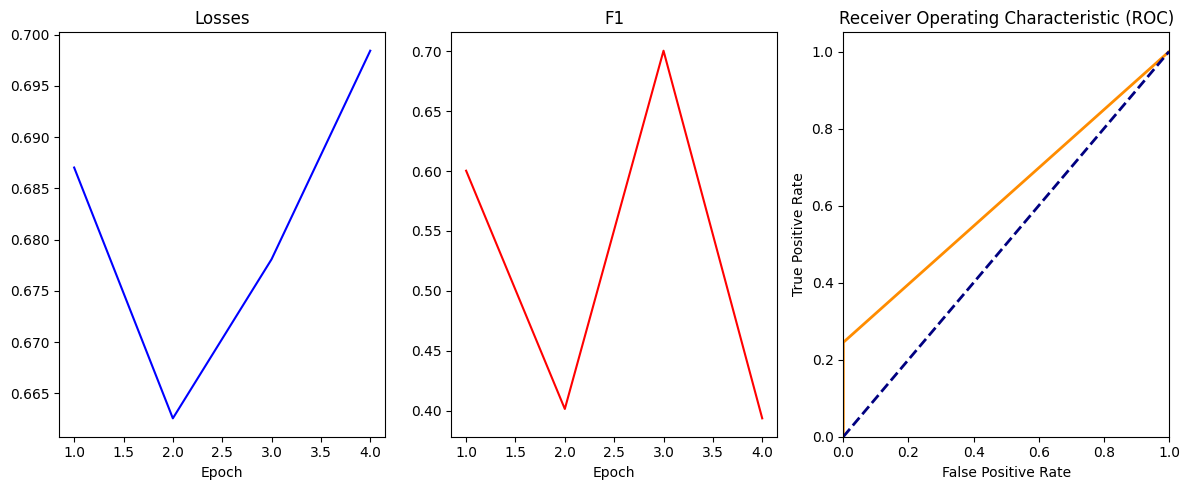

Training epoch 5:   0%|          | 0/10902 [00:00<?, ?it/s]

Testing:   0%|          | 0/2726 [00:00<?, ?it/s]

              precision    recall  f1-score   support

         0.0       0.57      0.91      0.70      1252
         1.0       0.84      0.41      0.55      1474

    accuracy                           0.64      2726
   macro avg       0.71      0.66      0.63      2726
weighted avg       0.72      0.64      0.62      2726

Min Loss = 0.6625713679363391, Curr F1 = 0.5546448087431695, Max F1 = 0.7006369426751592, Curr AUC_ROC = 0.6614529371729791, Max AUC_ROC = 0.7010183977007209


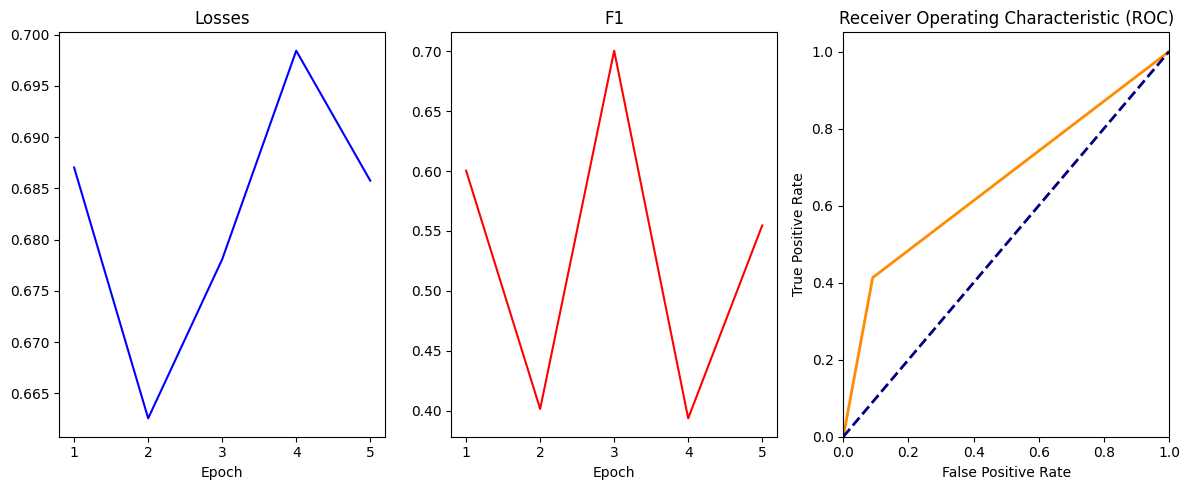

Training epoch 6:   0%|          | 0/10902 [00:00<?, ?it/s]

Testing:   0%|          | 0/2726 [00:00<?, ?it/s]

              precision    recall  f1-score   support

         0.0       0.63      0.91      0.74      1252
         1.0       0.88      0.55      0.67      1474

    accuracy                           0.71      2726
   macro avg       0.75      0.73      0.71      2726
weighted avg       0.76      0.71      0.71      2726

Min Loss = 0.6625713679363391, Curr F1 = 0.6728033472803346, Max F1 = 0.7006369426751592, Curr AUC_ROC = 0.7279988382224803, Max AUC_ROC = 0.7279988382224803


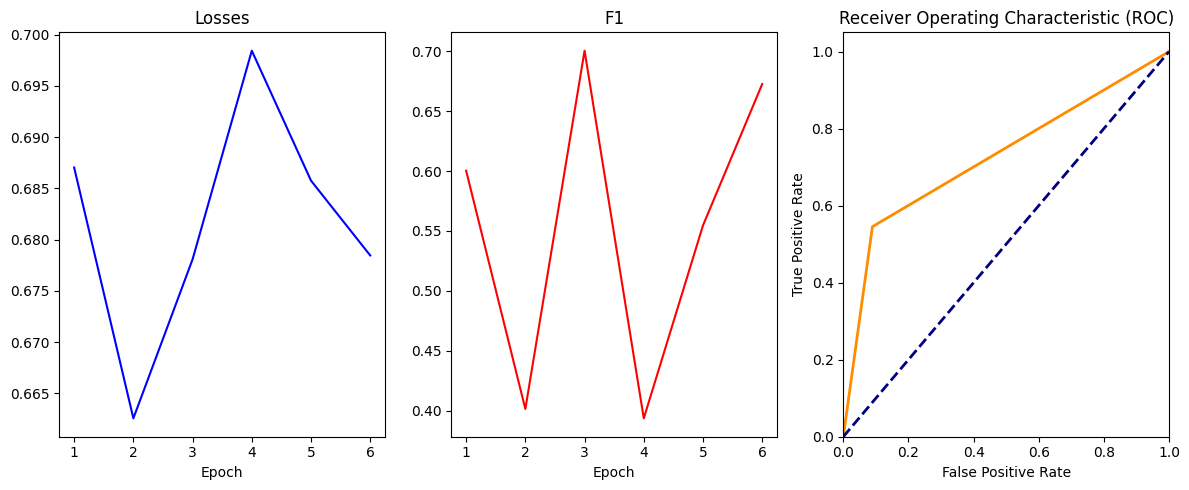

Training epoch 7:   0%|          | 0/10902 [00:00<?, ?it/s]

Testing:   0%|          | 0/2726 [00:00<?, ?it/s]

              precision    recall  f1-score   support

         0.0       0.64      0.97      0.77      1252
         1.0       0.95      0.54      0.69      1474

    accuracy                           0.74      2726
   macro avg       0.80      0.75      0.73      2726
weighted avg       0.81      0.74      0.73      2726

Min Loss = 0.6363137216852075, Curr F1 = 0.6874729085392285, Max F1 = 0.7006369426751592, Curr AUC_ROC = 0.753021488549122, Max AUC_ROC = 0.753021488549122


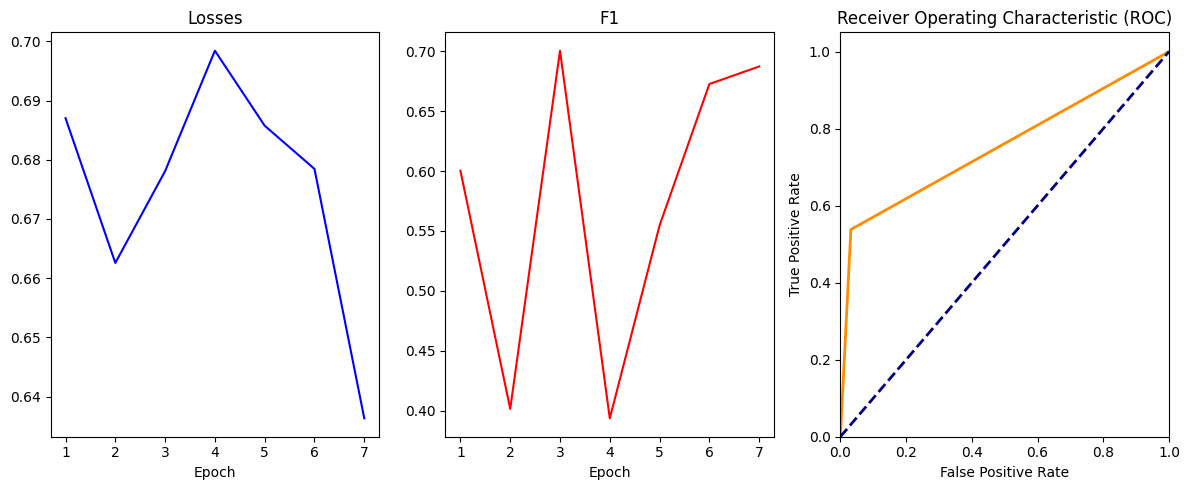

Training epoch 8:   0%|          | 0/10902 [00:00<?, ?it/s]

Testing:   0%|          | 0/2726 [00:00<?, ?it/s]

              precision    recall  f1-score   support

         0.0       0.63      0.93      0.75      1252
         1.0       0.90      0.53      0.66      1474

    accuracy                           0.71      2726
   macro avg       0.76      0.73      0.71      2726
weighted avg       0.77      0.71      0.70      2726

Min Loss = 0.634889669742328, Curr F1 = 0.6638188808201623, Max F1 = 0.7006369426751592, Curr AUC_ROC = 0.7276260290184281, Max AUC_ROC = 0.753021488549122


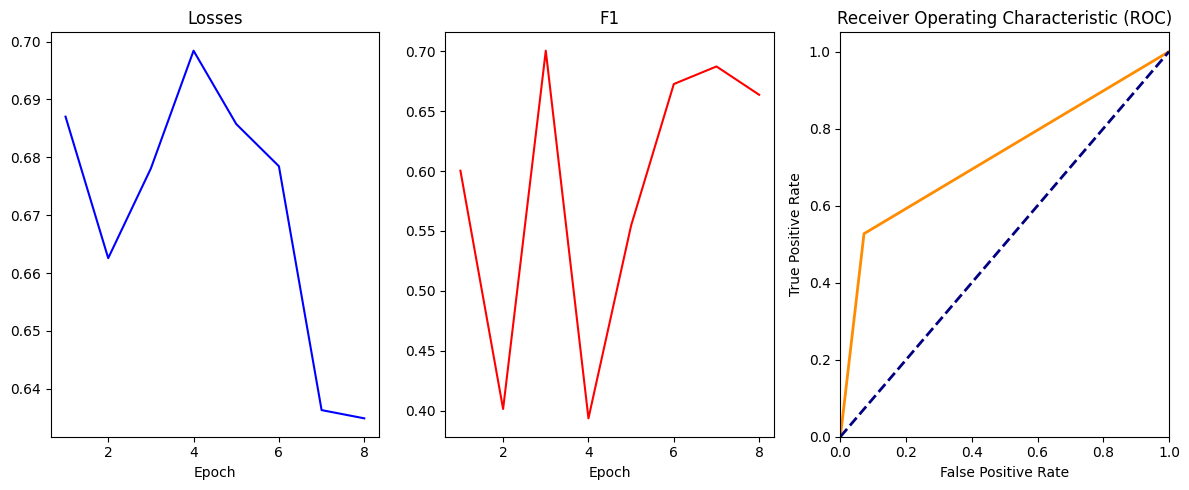

Training epoch 9:   0%|          | 0/10902 [00:00<?, ?it/s]

Testing:   0%|          | 0/2726 [00:00<?, ?it/s]

              precision    recall  f1-score   support

         0.0       0.54      0.99      0.70      1252
         1.0       0.98      0.30      0.45      1474

    accuracy                           0.62      2726
   macro avg       0.76      0.64      0.58      2726
weighted avg       0.78      0.62      0.57      2726

Min Loss = 0.634889669742328, Curr F1 = 0.45393024466423737, Max F1 = 0.7006369426751592, Curr AUC_ROC = 0.6435039079941565, Max AUC_ROC = 0.753021488549122


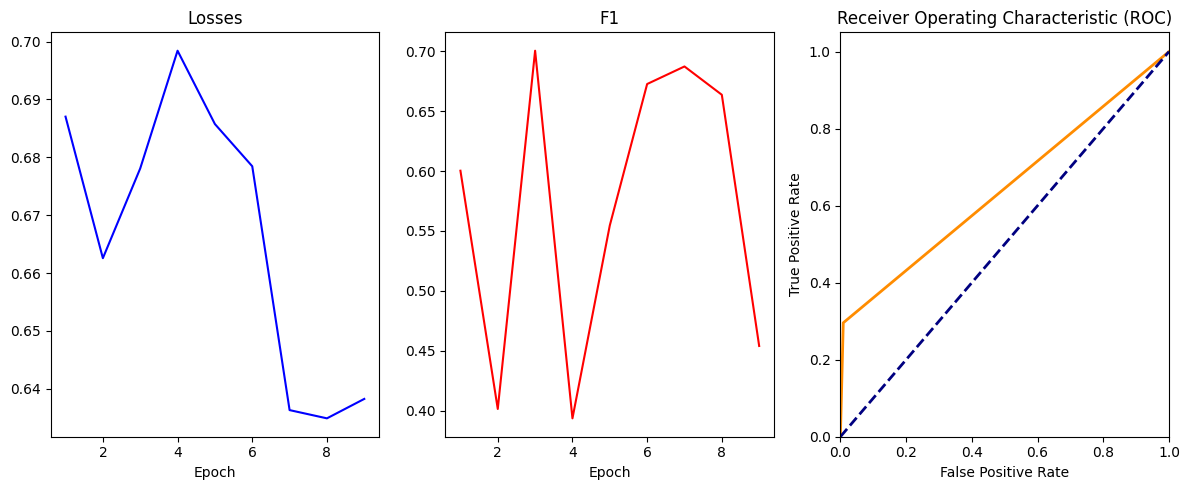

Training epoch 10:   0%|          | 0/10902 [00:00<?, ?it/s]

Testing:   0%|          | 0/2726 [00:00<?, ?it/s]

              precision    recall  f1-score   support

         0.0       0.66      0.91      0.76      1252
         1.0       0.89      0.60      0.71      1474

    accuracy                           0.74      2726
   macro avg       0.77      0.75      0.74      2726
weighted avg       0.78      0.74      0.74      2726

Min Loss = 0.634889669742328, Curr F1 = 0.7149797570850202, Max F1 = 0.7149797570850202, Curr AUC_ROC = 0.7543973062367512, Max AUC_ROC = 0.7543973062367512


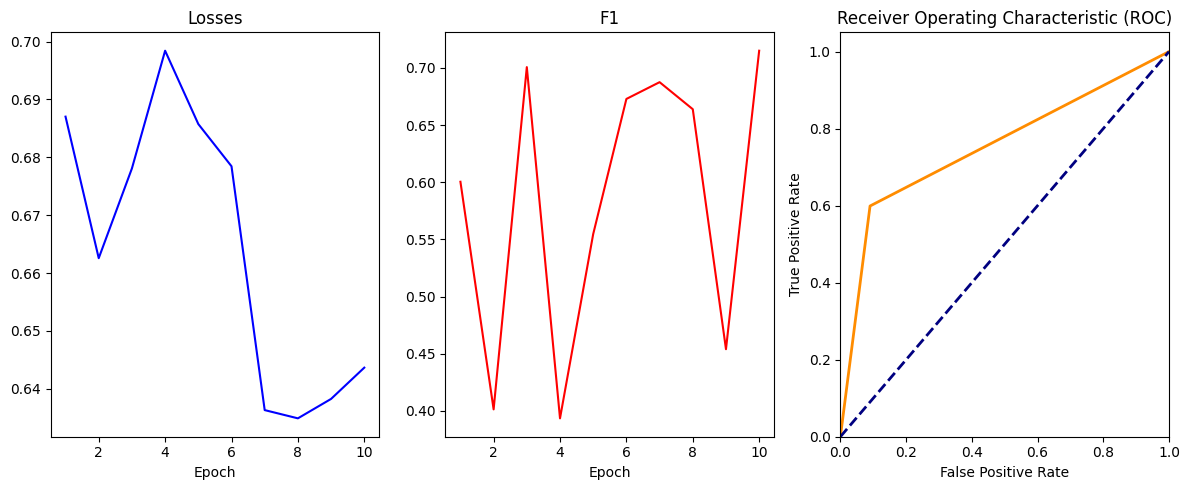

In [57]:
model_lstm = OtchislenieModel_LSTM(hidden_dim=512, input_size=max_subjects_per_semestr, num_classes = 1).to(device)
criterion = nn.BCELoss()
optimizer = torch.optim.Adam(model_lstm.parameters())

model_lstm = train_model(model_lstm, optimizer, criterion, num_epoch=10)

Vanilla RNN Custom Structure

Training epoch 1:   0%|          | 0/10902 [00:00<?, ?it/s]

Testing:   0%|          | 0/2726 [00:00<?, ?it/s]

              precision    recall  f1-score   support

         0.0       0.62      0.98      0.76      1252
         1.0       0.96      0.49      0.65      1474

    accuracy                           0.71      2726
   macro avg       0.79      0.73      0.70      2726
weighted avg       0.81      0.71      0.70      2726

Min Loss = 0.6006426120888003, Curr F1 = 0.6504941599281222, Max F1 = 0.6504941599281222, Curr AUC_ROC = 0.7344081220386596, Max AUC_ROC = 0.7344081220386596


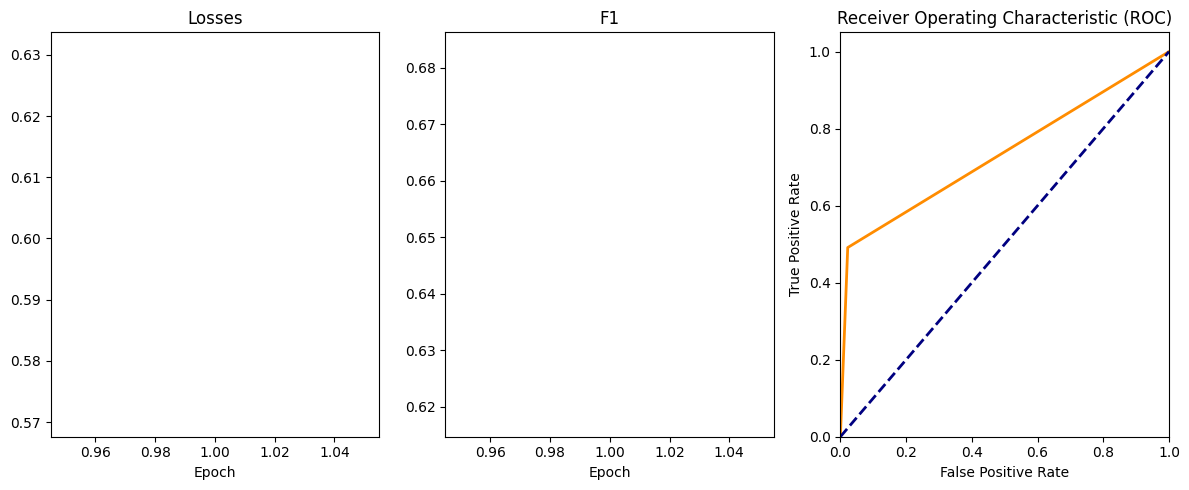

Training epoch 2:   0%|          | 0/10902 [00:00<?, ?it/s]

Testing:   0%|          | 0/2726 [00:00<?, ?it/s]

              precision    recall  f1-score   support

         0.0       0.65      0.97      0.78      1252
         1.0       0.96      0.55      0.70      1474

    accuracy                           0.74      2726
   macro avg       0.80      0.76      0.74      2726
weighted avg       0.81      0.74      0.74      2726

Min Loss = 0.5766238406827798, Curr F1 = 0.6996557659208261, Max F1 = 0.6996557659208261, Curr AUC_ROC = 0.7610038321318184, Max AUC_ROC = 0.7610038321318184


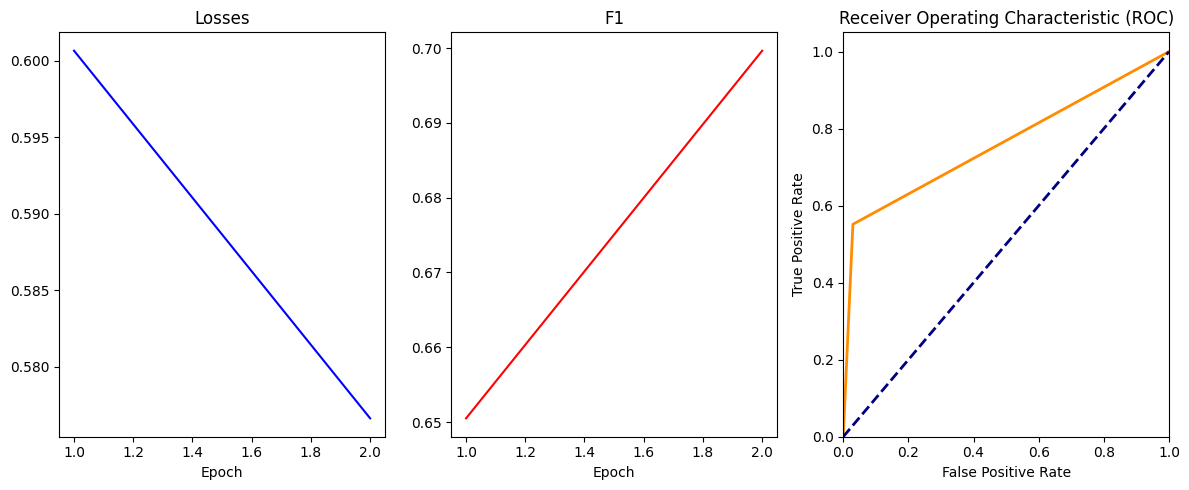

Training epoch 3:   0%|          | 0/10902 [00:00<?, ?it/s]

Testing:   0%|          | 0/2726 [00:00<?, ?it/s]

              precision    recall  f1-score   support

         0.0       0.66      0.98      0.79      1252
         1.0       0.97      0.57      0.72      1474

    accuracy                           0.76      2726
   macro avg       0.81      0.77      0.75      2726
weighted avg       0.83      0.76      0.75      2726

Min Loss = 0.5659243779393964, Curr F1 = 0.7157534246575342, Max F1 = 0.7157534246575342, Curr AUC_ROC = 0.7731987029707692, Max AUC_ROC = 0.7731987029707692


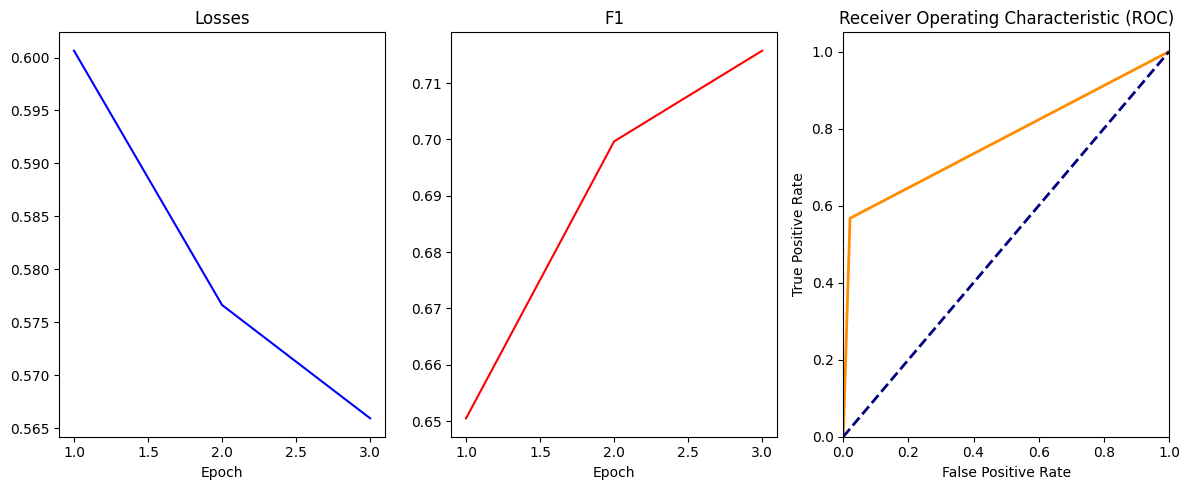

Training epoch 4:   0%|          | 0/10902 [00:00<?, ?it/s]

Testing:   0%|          | 0/2726 [00:00<?, ?it/s]

              precision    recall  f1-score   support

         0.0       0.65      0.97      0.78      1252
         1.0       0.96      0.55      0.70      1474

    accuracy                           0.75      2726
   macro avg       0.81      0.76      0.74      2726
weighted avg       0.82      0.75      0.74      2726

Min Loss = 0.5617556170874961, Curr F1 = 0.7034007748600946, Max F1 = 0.7157534246575342, Curr AUC_ROC = 0.7643574893467602, Max AUC_ROC = 0.7731987029707692


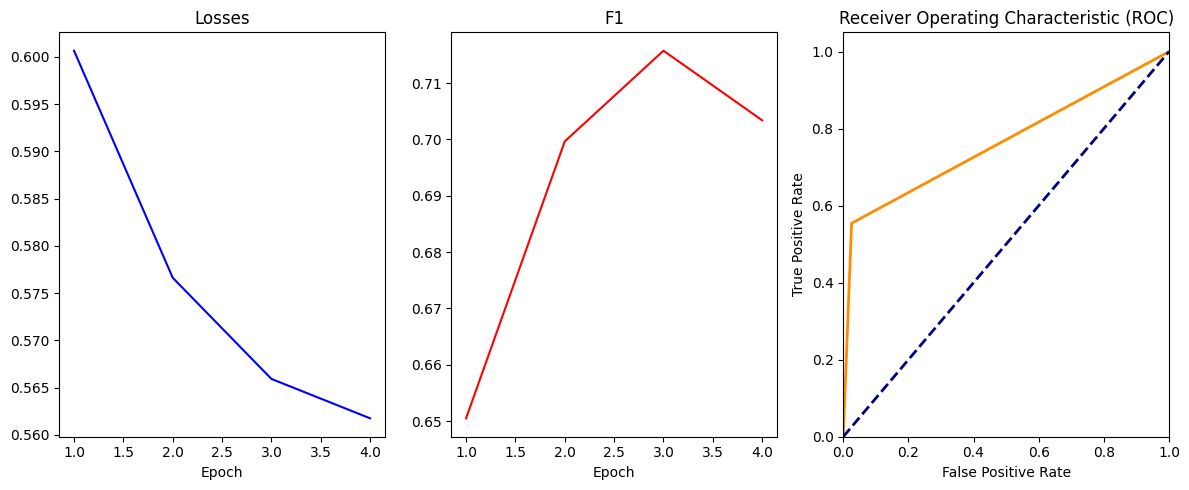

Training epoch 5:   0%|          | 0/10902 [00:00<?, ?it/s]

Testing:   0%|          | 0/2726 [00:00<?, ?it/s]

              precision    recall  f1-score   support

         0.0       0.66      0.98      0.79      1252
         1.0       0.97      0.57      0.72      1474

    accuracy                           0.76      2726
   macro avg       0.82      0.77      0.75      2726
weighted avg       0.83      0.76      0.75      2726

Min Loss = 0.5571203183868315, Curr F1 = 0.7158798283261802, Max F1 = 0.7158798283261802, Curr AUC_ROC = 0.7741177210086656, Max AUC_ROC = 0.7741177210086656


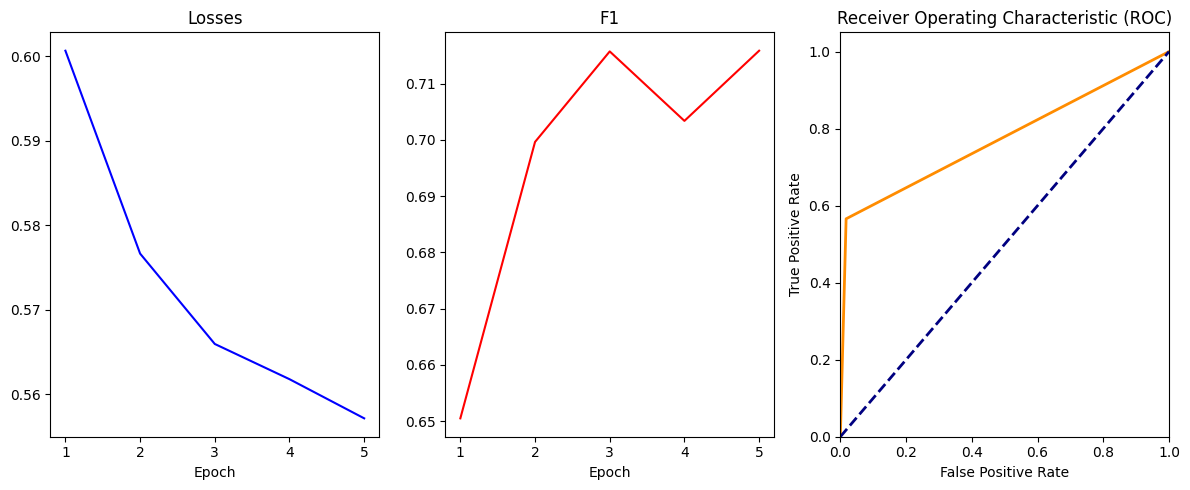

Training epoch 6:   0%|          | 0/10902 [00:00<?, ?it/s]

Testing:   0%|          | 0/2726 [00:00<?, ?it/s]

              precision    recall  f1-score   support

         0.0       0.66      0.98      0.79      1252
         1.0       0.98      0.57      0.72      1474

    accuracy                           0.76      2726
   macro avg       0.82      0.78      0.75      2726
weighted avg       0.83      0.76      0.75      2726

Min Loss = 0.5535769116526756, Curr F1 = 0.7189374464438733, Max F1 = 0.7189374464438733, Curr AUC_ROC = 0.7762131471599308, Max AUC_ROC = 0.7762131471599308


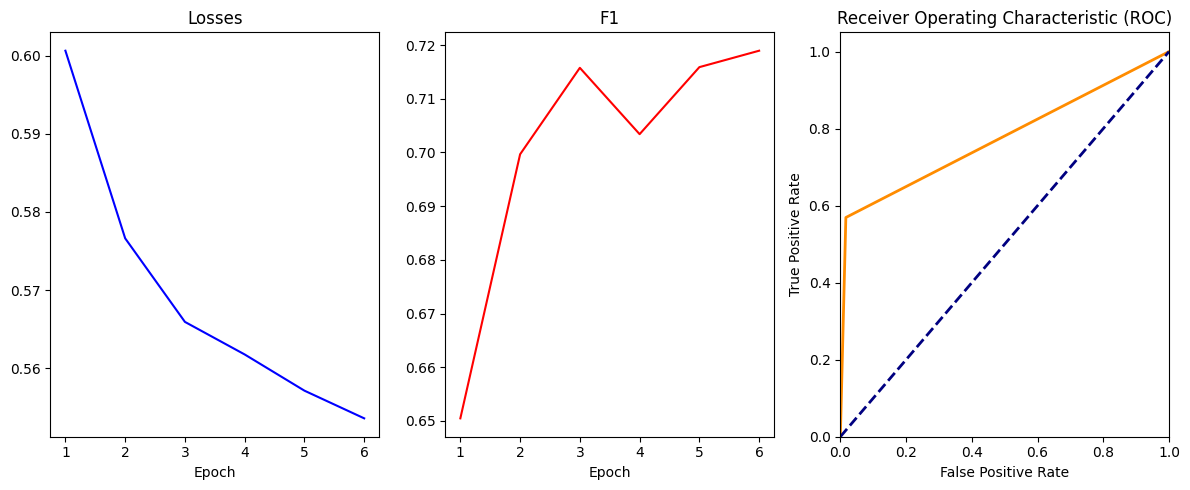

Training epoch 7:   0%|          | 0/10902 [00:00<?, ?it/s]

Testing:   0%|          | 0/2726 [00:00<?, ?it/s]

              precision    recall  f1-score   support

         0.0       0.66      0.98      0.79      1252
         1.0       0.98      0.56      0.71      1474

    accuracy                           0.75      2726
   macro avg       0.82      0.77      0.75      2726
weighted avg       0.83      0.75      0.75      2726

Min Loss = 0.5515852746960521, Curr F1 = 0.7117621714778113, Max F1 = 0.7189374464438733, Curr AUC_ROC = 0.7718033778247884, Max AUC_ROC = 0.7762131471599308


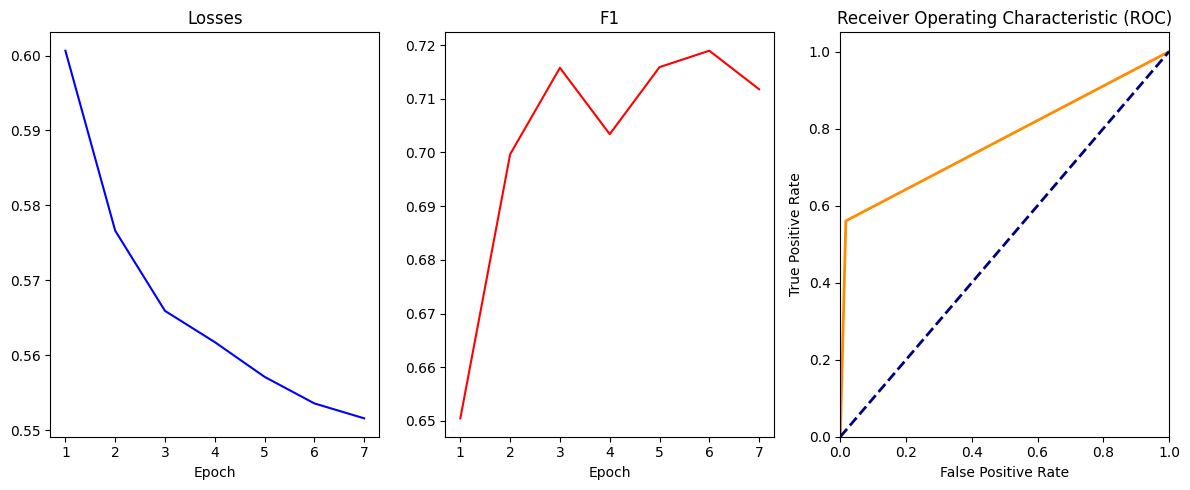

Training epoch 8:   0%|          | 0/10902 [00:00<?, ?it/s]

Testing:   0%|          | 0/2726 [00:00<?, ?it/s]

              precision    recall  f1-score   support

         0.0       0.66      0.98      0.79      1252
         1.0       0.97      0.57      0.72      1474

    accuracy                           0.76      2726
   macro avg       0.82      0.78      0.76      2726
weighted avg       0.83      0.76      0.75      2726

Min Loss = 0.5491886013102896, Curr F1 = 0.7226962457337884, Max F1 = 0.7226962457337884, Curr AUC_ROC = 0.7781281293214438, Max AUC_ROC = 0.7781281293214438


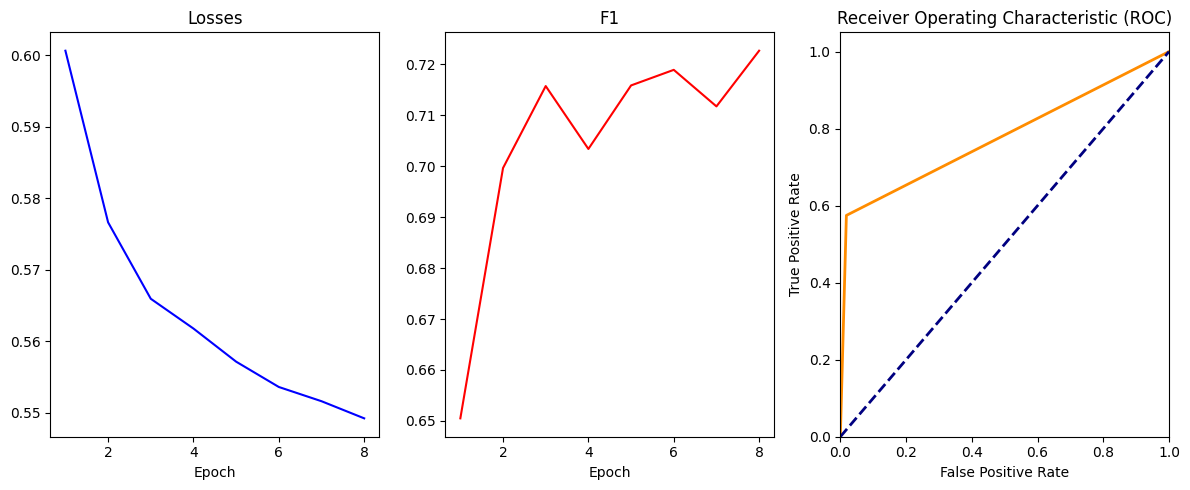

Training epoch 9:   0%|          | 0/10902 [00:00<?, ?it/s]

Testing:   0%|          | 0/2726 [00:00<?, ?it/s]

              precision    recall  f1-score   support

         0.0       0.67      0.98      0.80      1252
         1.0       0.97      0.59      0.73      1474

    accuracy                           0.77      2726
   macro avg       0.82      0.78      0.76      2726
weighted avg       0.83      0.77      0.76      2726

Min Loss = 0.5454659666409886, Curr F1 = 0.7340918668352296, Max F1 = 0.7340918668352296, Curr AUC_ROC = 0.7842724368283474, Max AUC_ROC = 0.7842724368283474


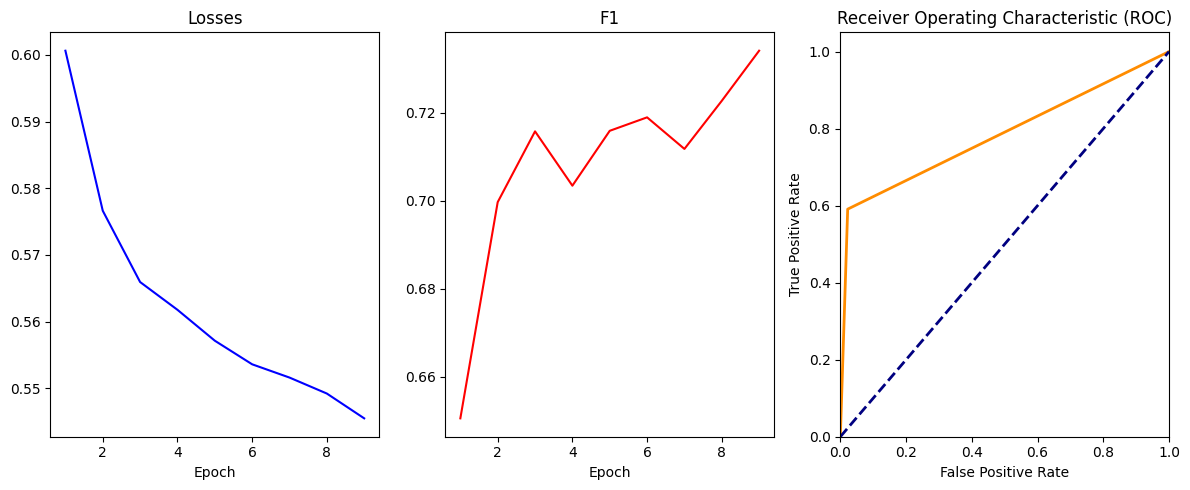

Training epoch 10:   0%|          | 0/10902 [00:00<?, ?it/s]

Testing:   0%|          | 0/2726 [00:00<?, ?it/s]

              precision    recall  f1-score   support

         0.0       0.67      0.98      0.79      1252
         1.0       0.98      0.58      0.73      1474

    accuracy                           0.77      2726
   macro avg       0.82      0.78      0.76      2726
weighted avg       0.83      0.77      0.76      2726

Min Loss = 0.5424004395965126, Curr F1 = 0.727427597955707, Max F1 = 0.7340918668352296, Curr AUC_ROC = 0.7817007035689979, Max AUC_ROC = 0.7842724368283474


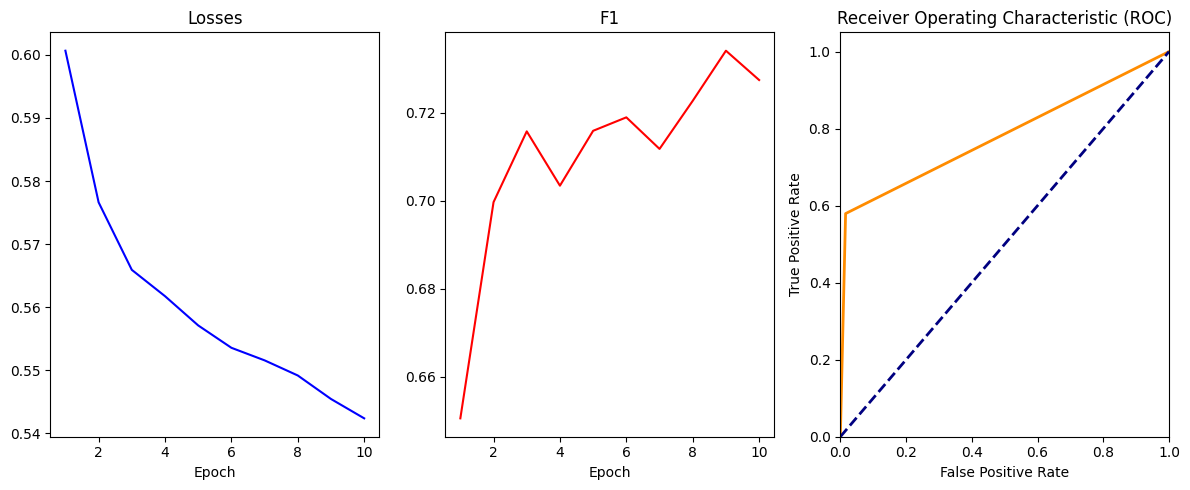

In [58]:
model_rnn_custom = OtchislenieModel_CustomStructure(input_size=max_subjects_per_semestr, num_classes = 1).to(device)
criterion = nn.BCELoss()
optimizer = torch.optim.Adam(model_rnn_custom.parameters())

model_rnn_custom = train_model(model_rnn_custom, optimizer, criterion, num_epoch=10)

GRU Custom Structure

Training epoch 1:   0%|          | 0/10902 [00:00<?, ?it/s]

Testing:   0%|          | 0/2726 [00:00<?, ?it/s]

              precision    recall  f1-score   support

         0.0       0.66      0.98      0.79      1252
         1.0       0.97      0.58      0.72      1474

    accuracy                           0.76      2726
   macro avg       0.82      0.78      0.76      2726
weighted avg       0.83      0.76      0.75      2726

Min Loss = 0.588327097323614, Curr F1 = 0.7235494880546075, Max F1 = 0.7235494880546075, Curr AUC_ROC = 0.7788667033695883, Max AUC_ROC = 0.7788667033695883


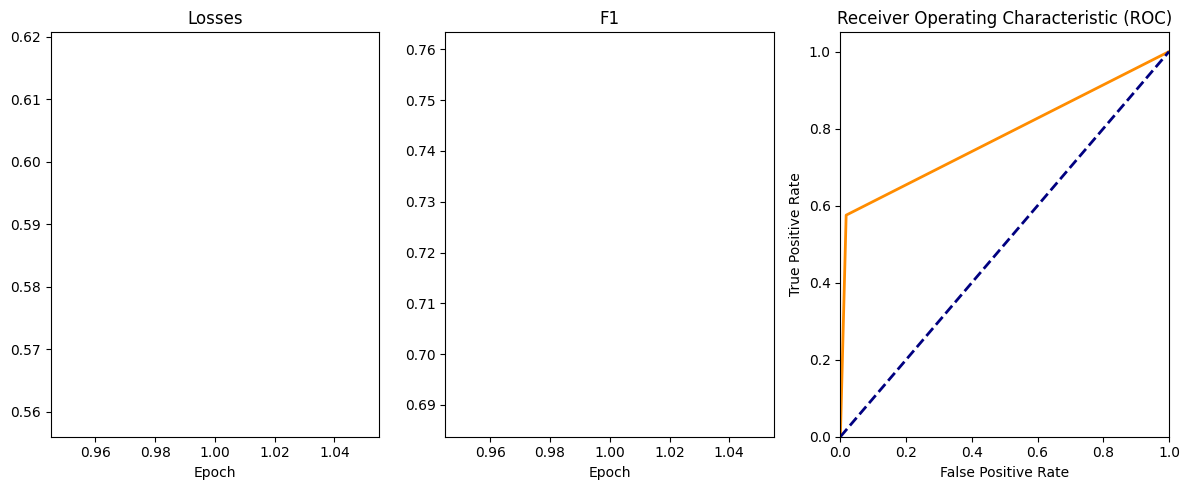

Training epoch 2:   0%|          | 0/10902 [00:00<?, ?it/s]

Testing:   0%|          | 0/2726 [00:00<?, ?it/s]

              precision    recall  f1-score   support

         0.0       0.68      0.97      0.80      1252
         1.0       0.96      0.61      0.74      1474

    accuracy                           0.77      2726
   macro avg       0.82      0.79      0.77      2726
weighted avg       0.83      0.77      0.77      2726

Min Loss = 0.555686840218246, Curr F1 = 0.7422166874221668, Max F1 = 0.7422166874221668, Curr AUC_ROC = 0.786882643130557, Max AUC_ROC = 0.786882643130557


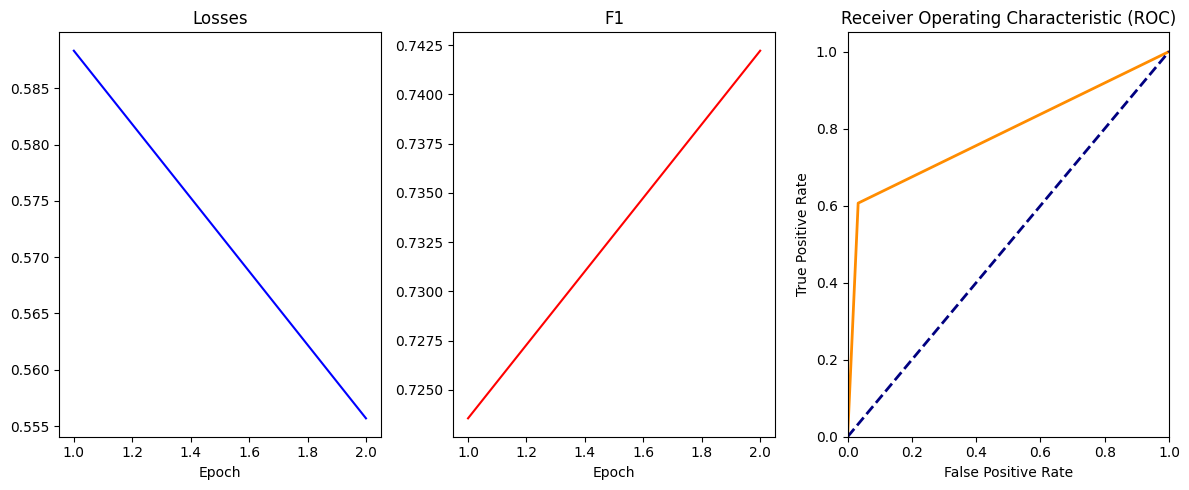

Training epoch 3:   0%|          | 0/10902 [00:00<?, ?it/s]

Testing:   0%|          | 0/2726 [00:00<?, ?it/s]

              precision    recall  f1-score   support

         0.0       0.68      0.97      0.80      1252
         1.0       0.96      0.62      0.75      1474

    accuracy                           0.78      2726
   macro avg       0.82      0.79      0.78      2726
weighted avg       0.83      0.78      0.77      2726

Min Loss = 0.5458705712492857, Curr F1 = 0.7508278145695365, Max F1 = 0.7508278145695365, Curr AUC_ROC = 0.7936885785998848, Max AUC_ROC = 0.7936885785998848


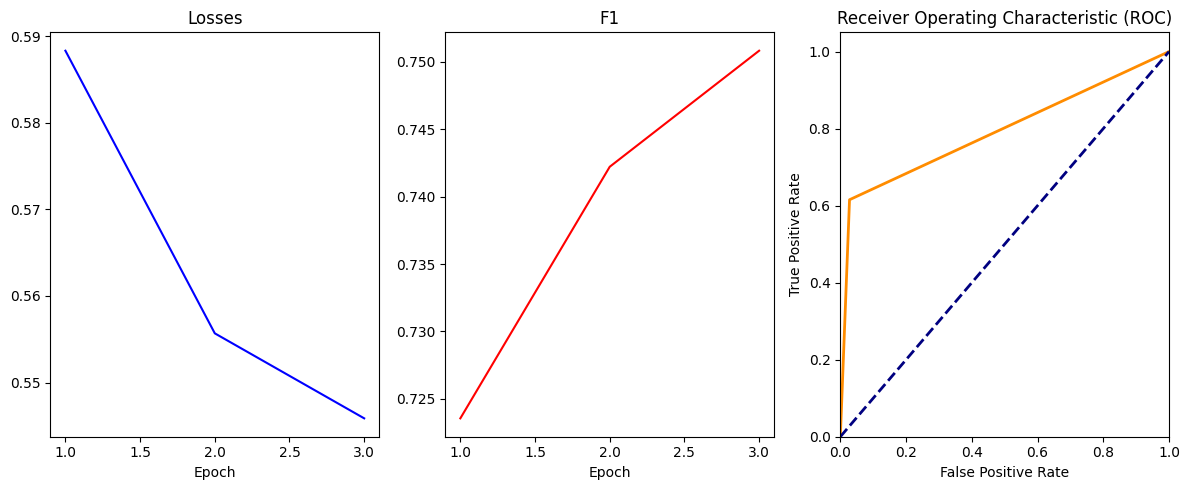

Training epoch 4:   0%|          | 0/10902 [00:00<?, ?it/s]

Testing:   0%|          | 0/2726 [00:00<?, ?it/s]

              precision    recall  f1-score   support

         0.0       0.70      0.96      0.81      1252
         1.0       0.96      0.65      0.77      1474

    accuracy                           0.79      2726
   macro avg       0.83      0.81      0.79      2726
weighted avg       0.84      0.79      0.79      2726

Min Loss = 0.5388275313627988, Curr F1 = 0.7743237787646345, Max F1 = 0.7743237787646345, Curr AUC_ROC = 0.8077334067391767, Max AUC_ROC = 0.8077334067391767


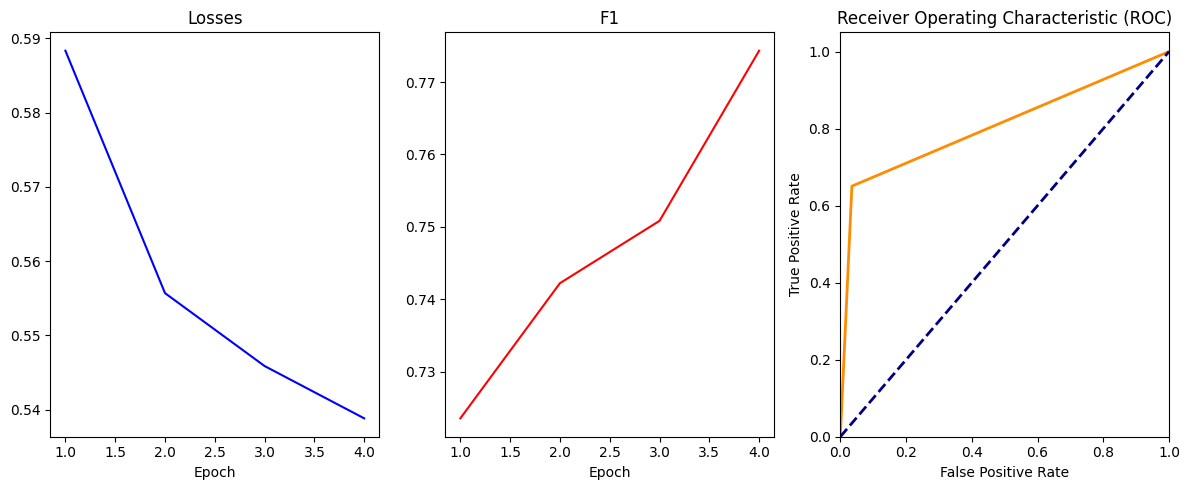

Training epoch 5:   0%|          | 0/10902 [00:00<?, ?it/s]

Testing:   0%|          | 0/2726 [00:00<?, ?it/s]

              precision    recall  f1-score   support

         0.0       0.69      0.97      0.80      1252
         1.0       0.96      0.63      0.76      1474

    accuracy                           0.78      2726
   macro avg       0.82      0.80      0.78      2726
weighted avg       0.84      0.78      0.78      2726

Min Loss = 0.5332250406176612, Curr F1 = 0.7581108829568789, Max F1 = 0.7743237787646345, Curr AUC_ROC = 0.7979179039452751, Max AUC_ROC = 0.8077334067391767


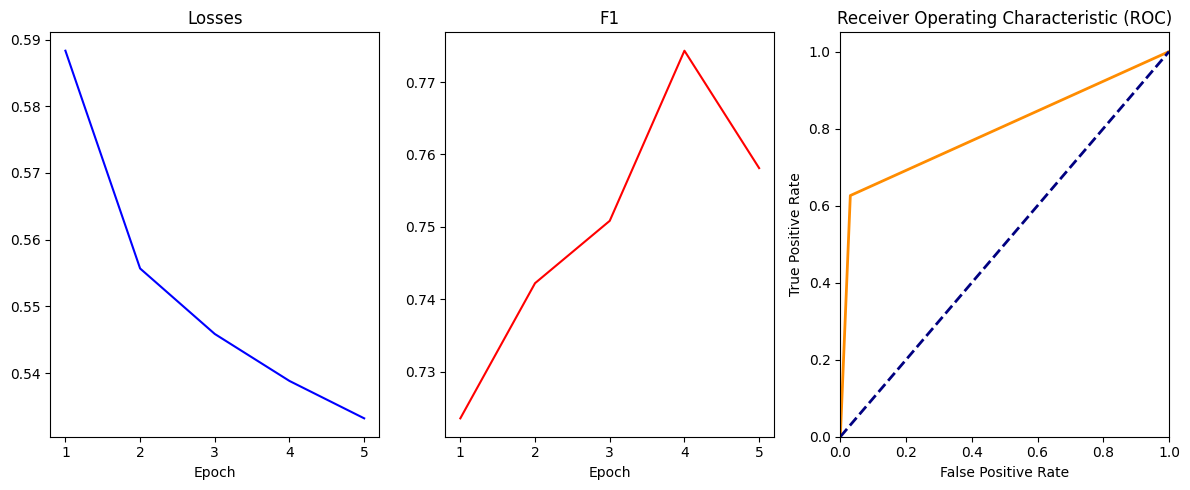

Training epoch 6:   0%|          | 0/10902 [00:00<?, ?it/s]

Testing:   0%|          | 0/2726 [00:00<?, ?it/s]

              precision    recall  f1-score   support

         0.0       0.68      0.96      0.80      1252
         1.0       0.95      0.61      0.75      1474

    accuracy                           0.77      2726
   macro avg       0.82      0.79      0.77      2726
weighted avg       0.83      0.77      0.77      2726

Min Loss = 0.5280875721549978, Curr F1 = 0.7463917525773196, Max F1 = 0.7743237787646345, Curr AUC_ROC = 0.788617181302318, Max AUC_ROC = 0.8077334067391767


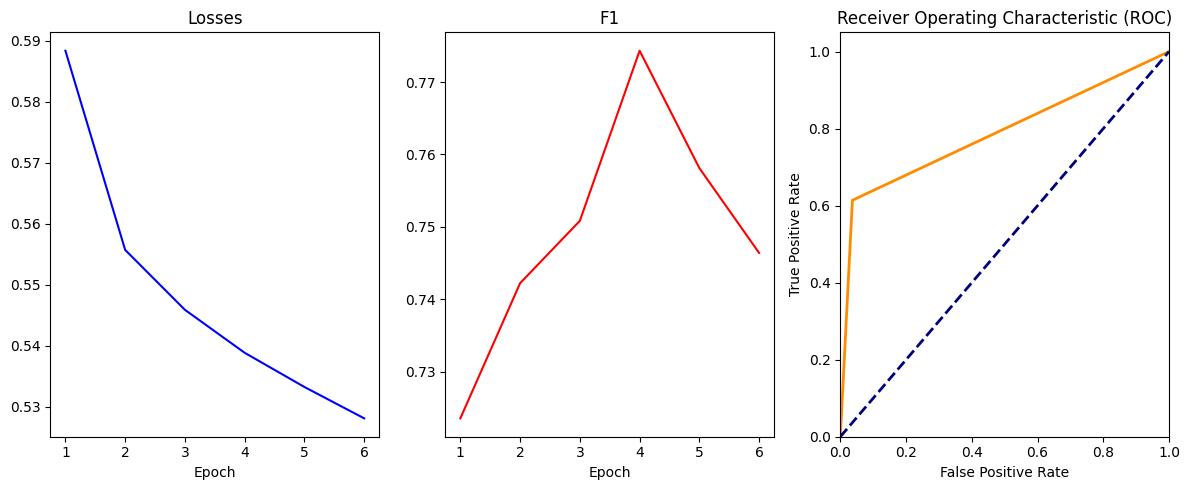

Training epoch 7:   0%|          | 0/10902 [00:00<?, ?it/s]

Testing:   0%|          | 0/2726 [00:00<?, ?it/s]

              precision    recall  f1-score   support

         0.0       0.69      0.96      0.80      1252
         1.0       0.95      0.63      0.76      1474

    accuracy                           0.78      2726
   macro avg       0.82      0.79      0.78      2726
weighted avg       0.83      0.78      0.78      2726

Min Loss = 0.5247537745660028, Curr F1 = 0.7556283258288989, Max F1 = 0.7743237787646345, Curr AUC_ROC = 0.7947230157663614, Max AUC_ROC = 0.8077334067391767


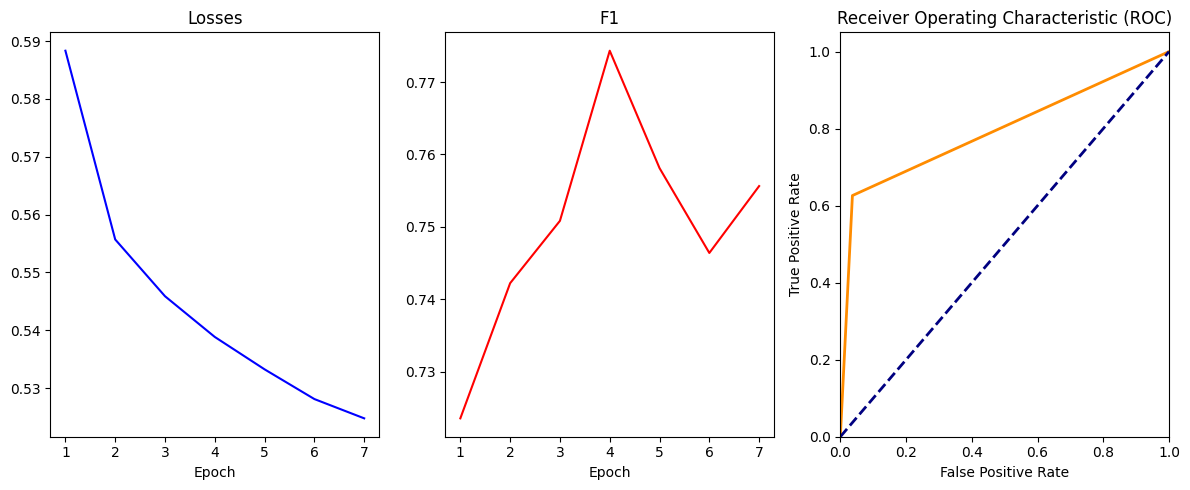

Training epoch 8:   0%|          | 0/10902 [00:00<?, ?it/s]

Testing:   0%|          | 0/2726 [00:00<?, ?it/s]

              precision    recall  f1-score   support

         0.0       0.69      0.96      0.80      1252
         1.0       0.95      0.63      0.76      1474

    accuracy                           0.78      2726
   macro avg       0.82      0.80      0.78      2726
weighted avg       0.83      0.78      0.78      2726

Min Loss = 0.5201719802284213, Curr F1 = 0.7598858540562577, Max F1 = 0.7743237787646345, Curr AUC_ROC = 0.7973765719760189, Max AUC_ROC = 0.8077334067391767


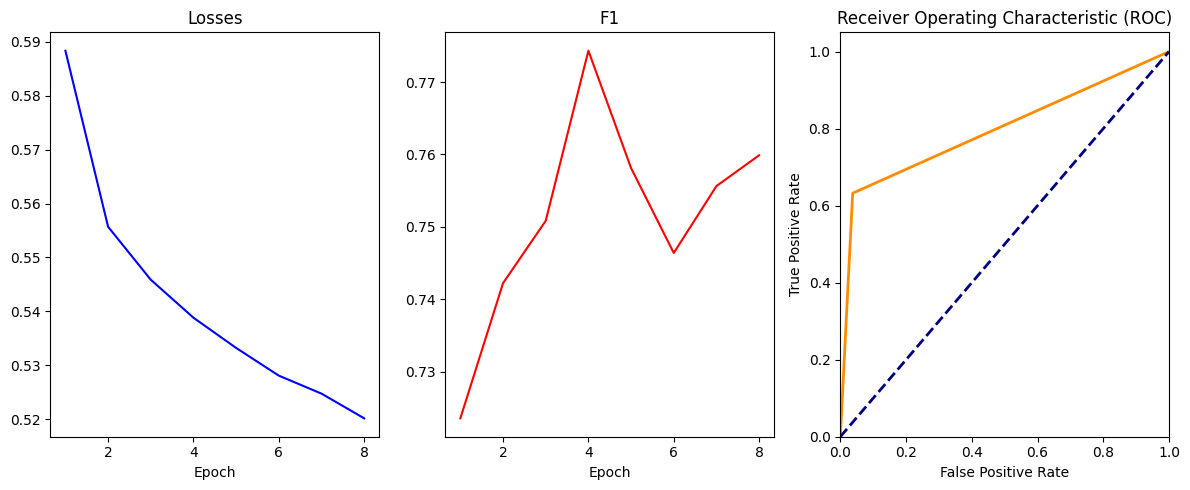

Training epoch 9:   0%|          | 0/10902 [00:00<?, ?it/s]

Testing:   0%|          | 0/2726 [00:00<?, ?it/s]

              precision    recall  f1-score   support

         0.0       0.69      0.96      0.80      1252
         1.0       0.94      0.63      0.76      1474

    accuracy                           0.78      2726
   macro avg       0.82      0.79      0.78      2726
weighted avg       0.83      0.78      0.78      2726

Min Loss = 0.5167526863631557, Curr F1 = 0.7571080422420796, Max F1 = 0.7743237787646345, Curr AUC_ROC = 0.7937823227747408, Max AUC_ROC = 0.8077334067391767


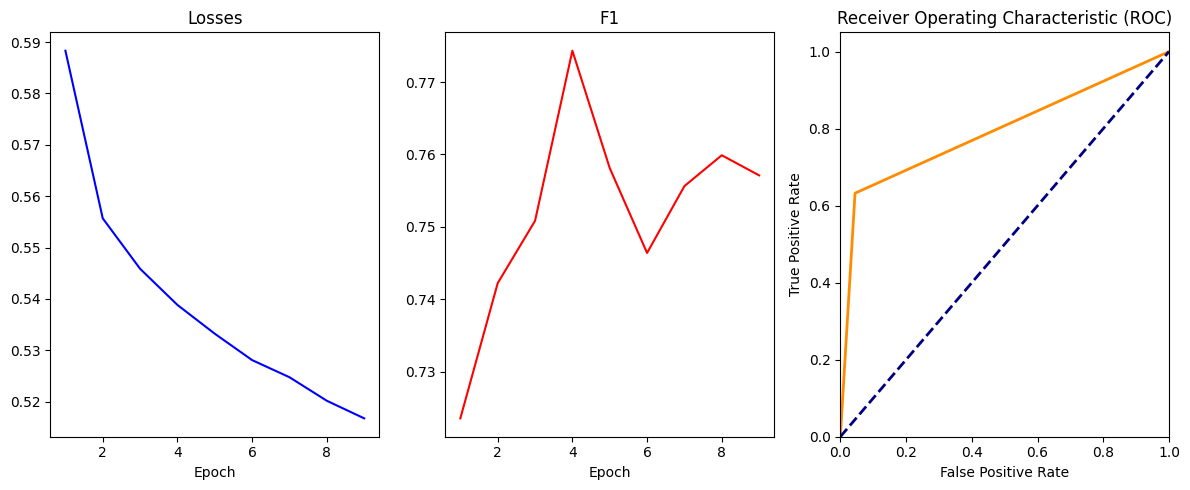

Training epoch 10:   0%|          | 0/10902 [00:00<?, ?it/s]

Testing:   0%|          | 0/2726 [00:00<?, ?it/s]

              precision    recall  f1-score   support

         0.0       0.69      0.96      0.80      1252
         1.0       0.95      0.63      0.76      1474

    accuracy                           0.78      2726
   macro avg       0.82      0.80      0.78      2726
weighted avg       0.83      0.78      0.78      2726

Min Loss = 0.5132680759645439, Curr F1 = 0.7586770110249081, Max F1 = 0.7743237787646345, Curr AUC_ROC = 0.7967582939210424, Max AUC_ROC = 0.8077334067391767


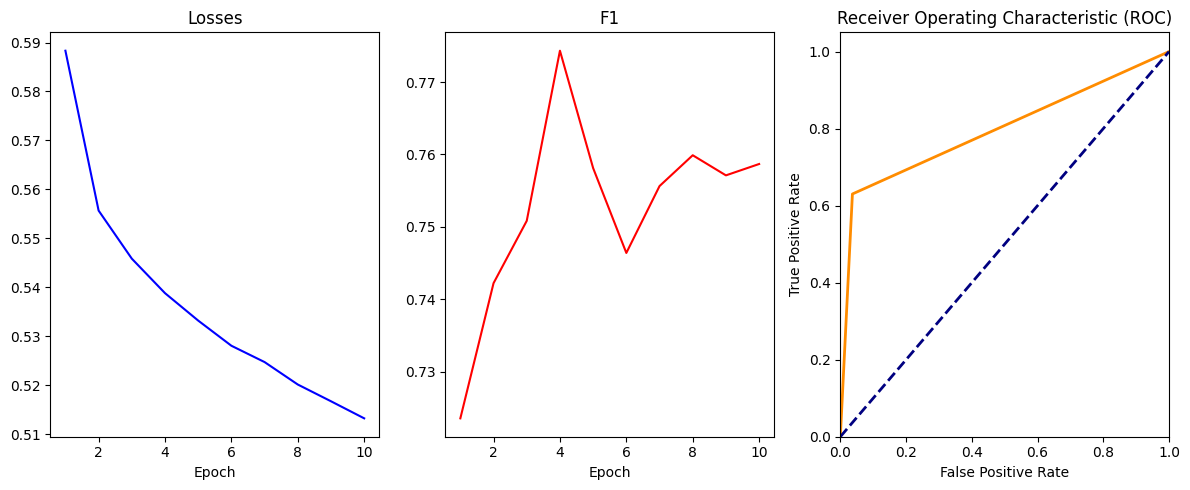

In [59]:
model_gru_custom = OtchislenieModel_GRU_CustomStructure(input_size=max_subjects_per_semestr, num_classes = 1).to(device)
criterion = nn.BCELoss()
optimizer = torch.optim.Adam(model_gru_custom.parameters())

model_gru_custom = train_model(model_gru_custom, optimizer, criterion, num_epoch=10)

LSTM Custom Structure

Training epoch 1:   0%|          | 0/10902 [00:00<?, ?it/s]

Testing:   0%|          | 0/2726 [00:00<?, ?it/s]

              precision    recall  f1-score   support

         0.0       0.67      0.98      0.79      1252
         1.0       0.97      0.58      0.73      1474

    accuracy                           0.77      2726
   macro avg       0.82      0.78      0.76      2726
weighted avg       0.83      0.77      0.76      2726

Min Loss = 0.5836263738136579, Curr F1 = 0.7302798982188294, Max F1 = 0.7302798982188294, Curr AUC_ROC = 0.7828771116823664, Max AUC_ROC = 0.7828771116823664


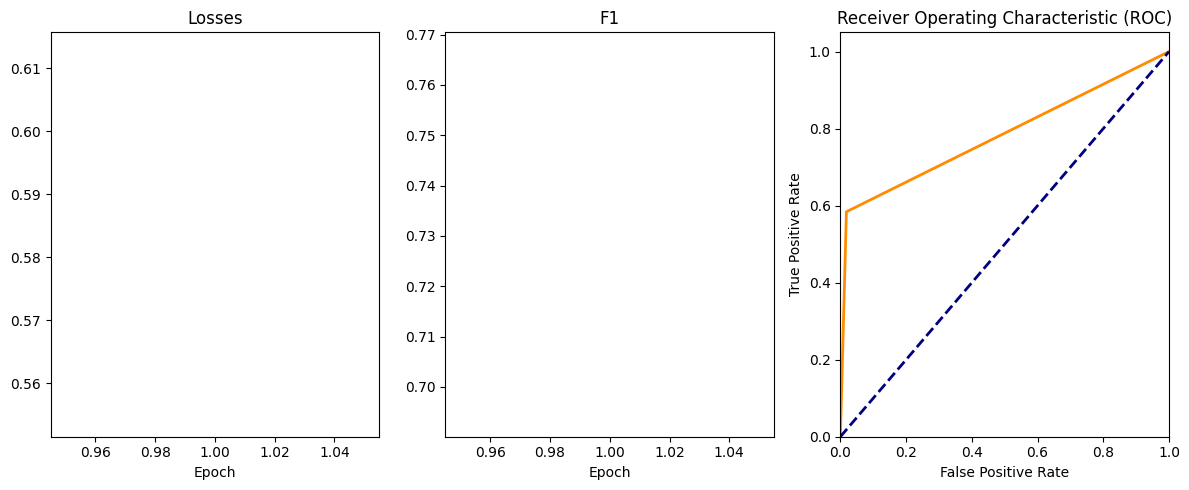

Training epoch 2:   0%|          | 0/10902 [00:00<?, ?it/s]

Testing:   0%|          | 0/2726 [00:00<?, ?it/s]

              precision    recall  f1-score   support

         0.0       0.67      0.98      0.80      1252
         1.0       0.98      0.59      0.73      1474

    accuracy                           0.77      2726
   macro avg       0.82      0.78      0.76      2726
weighted avg       0.83      0.77      0.76      2726

Min Loss = 0.5498403051232165, Curr F1 = 0.7322033898305085, Max F1 = 0.7322033898305085, Curr AUC_ROC = 0.7842941117820713, Max AUC_ROC = 0.7842941117820713


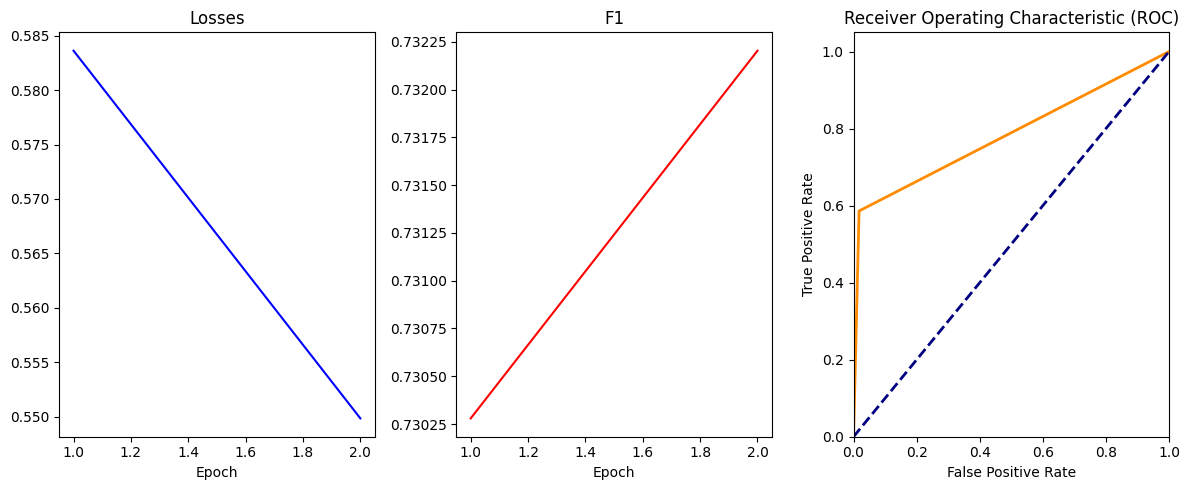

Training epoch 3:   0%|          | 0/10902 [00:00<?, ?it/s]

Testing:   0%|          | 0/2726 [00:00<?, ?it/s]

              precision    recall  f1-score   support

         0.0       0.67      0.98      0.80      1252
         1.0       0.97      0.60      0.74      1474

    accuracy                           0.77      2726
   macro avg       0.82      0.79      0.77      2726
weighted avg       0.83      0.77      0.77      2726

Min Loss = 0.536405936729247, Curr F1 = 0.7404612159329139, Max F1 = 0.7404612159329139, Curr AUC_ROC = 0.7883429931377097, Max AUC_ROC = 0.7883429931377097


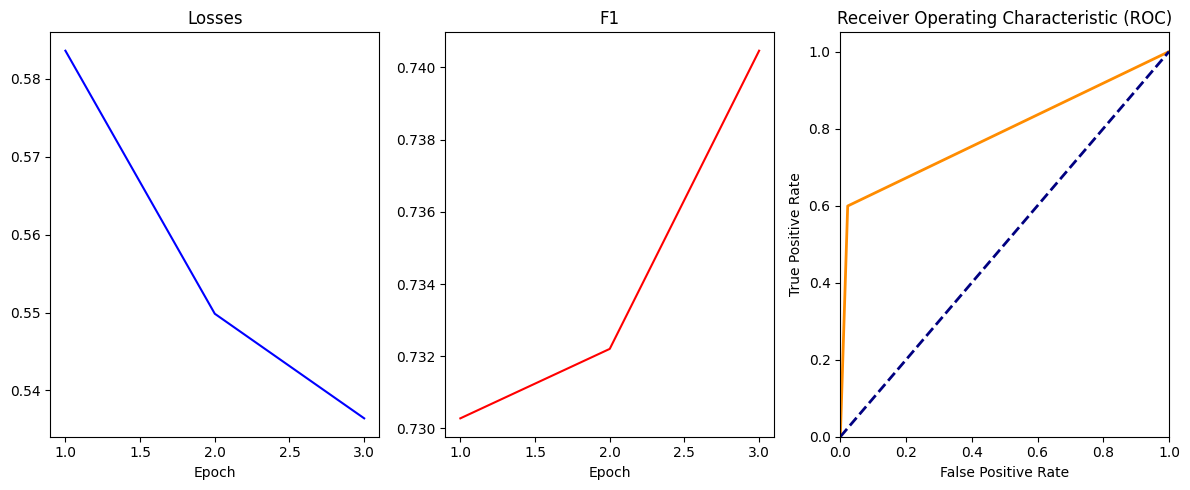

Training epoch 4:   0%|          | 0/10902 [00:00<?, ?it/s]

Testing:   0%|          | 0/2726 [00:00<?, ?it/s]

              precision    recall  f1-score   support

         0.0       0.68      0.96      0.80      1252
         1.0       0.95      0.61      0.74      1474

    accuracy                           0.77      2726
   macro avg       0.81      0.79      0.77      2726
weighted avg       0.83      0.77      0.77      2726

Min Loss = 0.5284071029615804, Curr F1 = 0.7430699213901532, Max F1 = 0.7430699213901532, Curr AUC_ROC = 0.7866420511442208, Max AUC_ROC = 0.7883429931377097


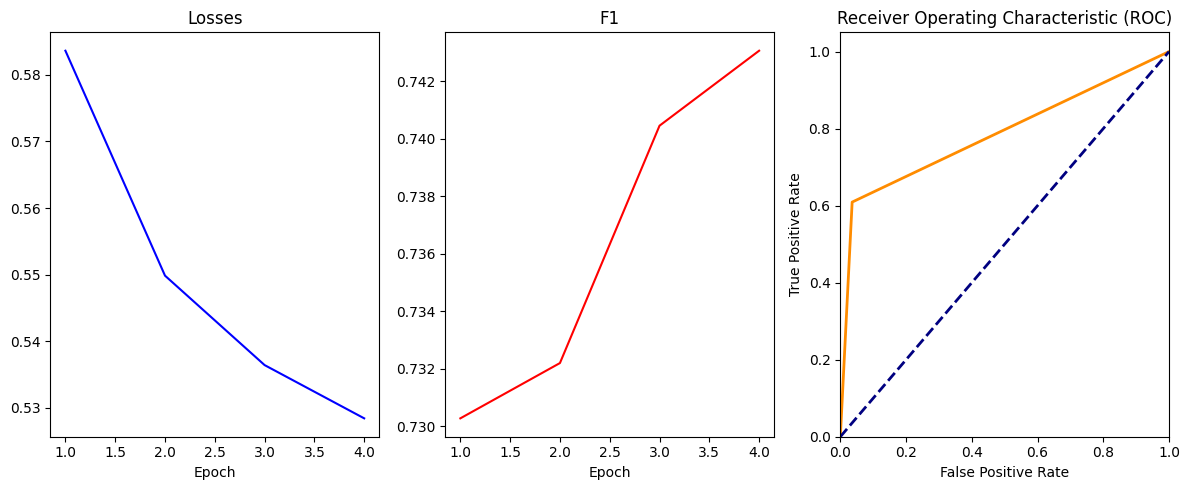

Training epoch 5:   0%|          | 0/10902 [00:00<?, ?it/s]

Testing:   0%|          | 0/2726 [00:00<?, ?it/s]

              precision    recall  f1-score   support

         0.0       0.68      0.97      0.80      1252
         1.0       0.97      0.62      0.75      1474

    accuracy                           0.78      2726
   macro avg       0.82      0.80      0.78      2726
weighted avg       0.84      0.78      0.78      2726

Min Loss = 0.5199445692900588, Curr F1 = 0.7529995862639635, Max F1 = 0.7529995862639635, Curr AUC_ROC = 0.7955049397219537, Max AUC_ROC = 0.7955049397219537


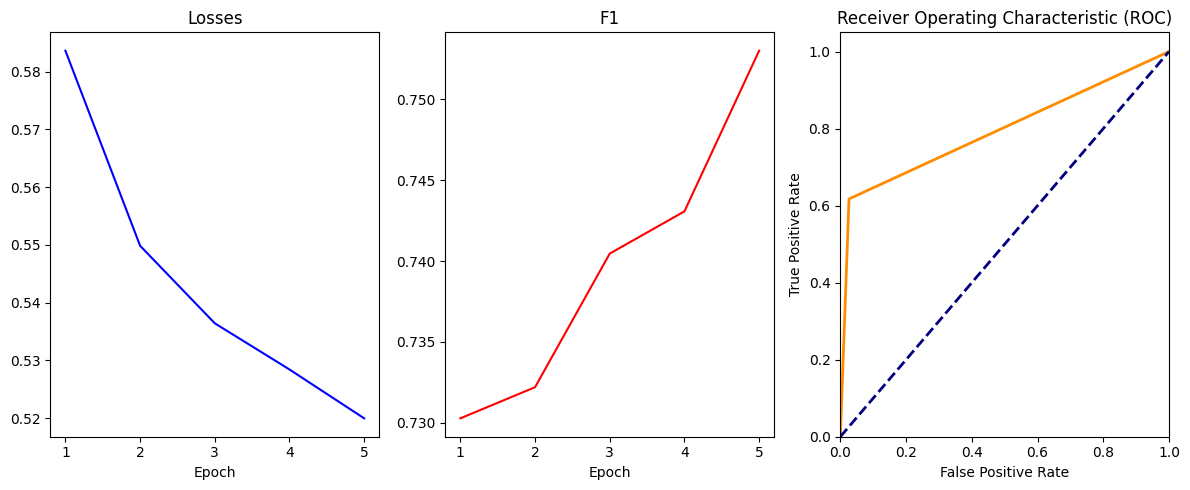

Training epoch 6:   0%|          | 0/10902 [00:00<?, ?it/s]

Testing:   0%|          | 0/2726 [00:00<?, ?it/s]

              precision    recall  f1-score   support

         0.0       0.68      0.97      0.80      1252
         1.0       0.97      0.62      0.75      1474

    accuracy                           0.78      2726
   macro avg       0.82      0.80      0.78      2726
weighted avg       0.84      0.78      0.78      2726

Min Loss = 0.5131036231861167, Curr F1 = 0.7527950310559006, Max F1 = 0.7529995862639635, Curr AUC_ROC = 0.7955650877185378, Max AUC_ROC = 0.7955650877185378


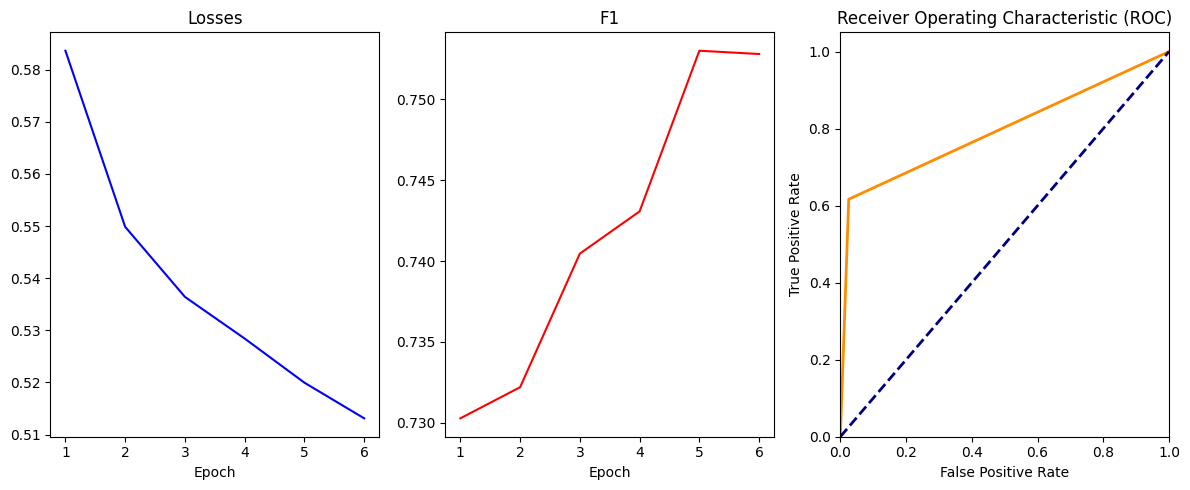

Training epoch 7:   0%|          | 0/10902 [00:00<?, ?it/s]

Testing:   0%|          | 0/2726 [00:00<?, ?it/s]

              precision    recall  f1-score   support

         0.0       0.68      0.97      0.80      1252
         1.0       0.96      0.62      0.75      1474

    accuracy                           0.78      2726
   macro avg       0.82      0.79      0.78      2726
weighted avg       0.83      0.78      0.78      2726

Min Loss = 0.5074548881375894, Curr F1 = 0.7529798602548294, Max F1 = 0.7529995862639635, Curr AUC_ROC = 0.7935466076529927, Max AUC_ROC = 0.7955650877185378


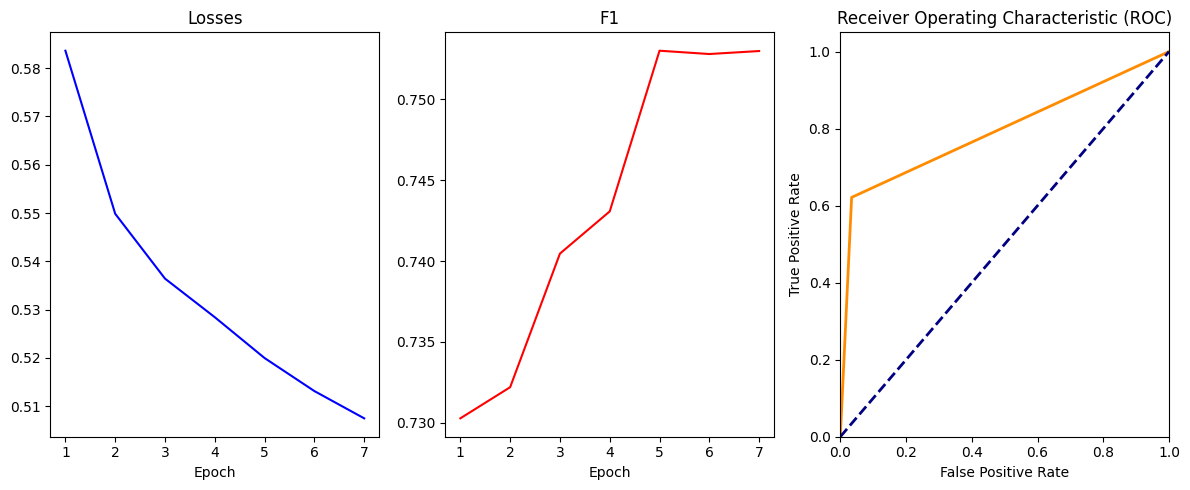

Training epoch 8:   0%|          | 0/10902 [00:00<?, ?it/s]

Testing:   0%|          | 0/2726 [00:00<?, ?it/s]

              precision    recall  f1-score   support

         0.0       0.69      0.96      0.80      1252
         1.0       0.95      0.63      0.76      1474

    accuracy                           0.78      2726
   macro avg       0.82      0.80      0.78      2726
weighted avg       0.83      0.78      0.78      2726

Min Loss = 0.4987063417358109, Curr F1 = 0.7557377049180328, Max F1 = 0.7557377049180328, Curr AUC_ROC = 0.7951825247853096, Max AUC_ROC = 0.7955650877185378


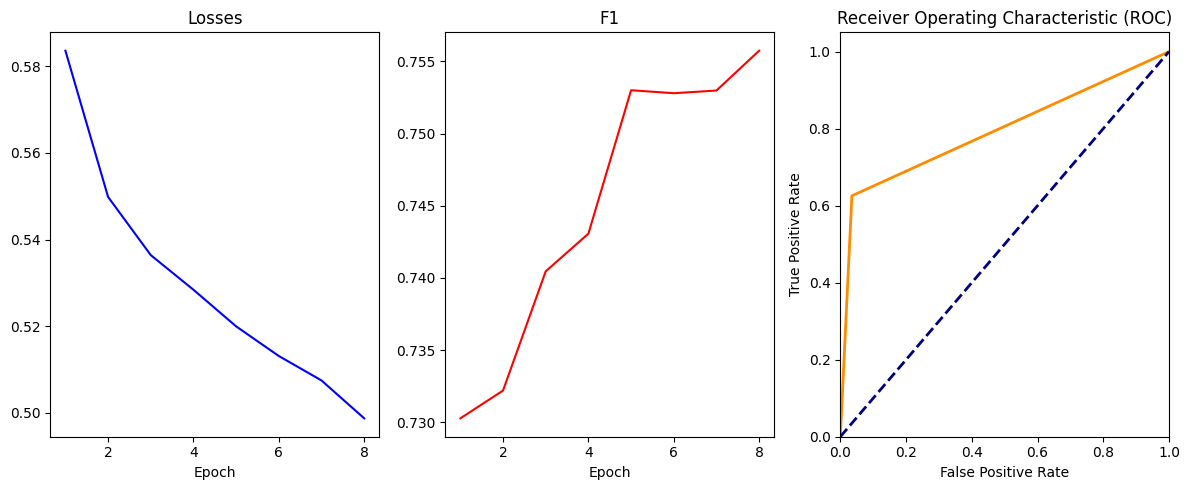

Training epoch 9:   0%|          | 0/10902 [00:00<?, ?it/s]

Testing:   0%|          | 0/2726 [00:00<?, ?it/s]

              precision    recall  f1-score   support

         0.0       0.68      0.95      0.80      1252
         1.0       0.94      0.63      0.75      1474

    accuracy                           0.78      2726
   macro avg       0.81      0.79      0.77      2726
weighted avg       0.82      0.78      0.77      2726

Min Loss = 0.49314505160791167, Curr F1 = 0.751732572360375, Max F1 = 0.7557377049180328, Curr AUC_ROC = 0.7899908314945747, Max AUC_ROC = 0.7955650877185378


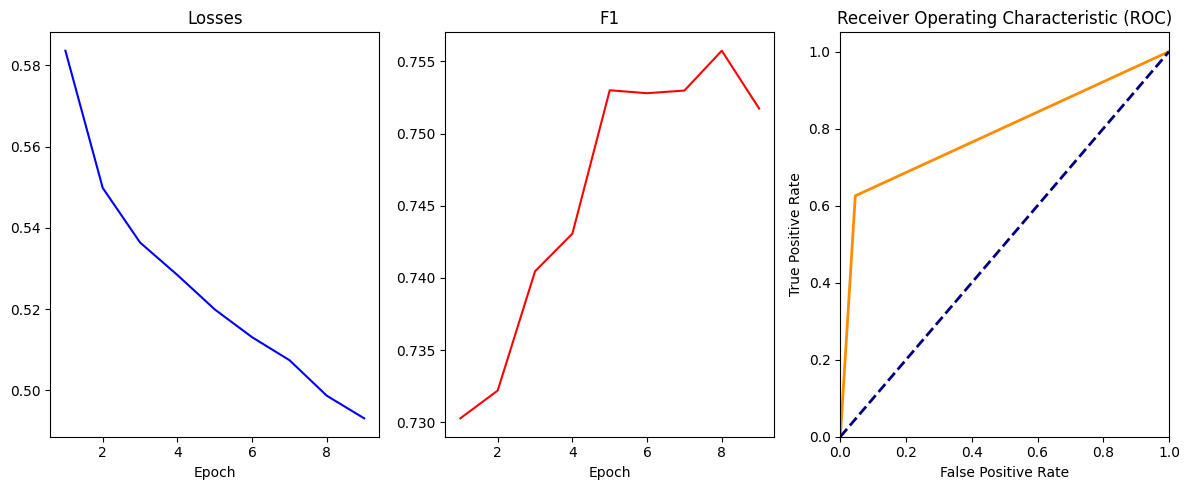

Training epoch 10:   0%|          | 0/10902 [00:00<?, ?it/s]

Testing:   0%|          | 0/2726 [00:00<?, ?it/s]

              precision    recall  f1-score   support

         0.0       0.69      0.95      0.80      1252
         1.0       0.94      0.63      0.76      1474

    accuracy                           0.78      2726
   macro avg       0.81      0.79      0.78      2726
weighted avg       0.82      0.78      0.77      2726

Min Loss = 0.49050964523719154, Curr F1 = 0.7551598543099959, Max F1 = 0.7557377049180328, Curr AUC_ROC = 0.7909266476216074, Max AUC_ROC = 0.7955650877185378


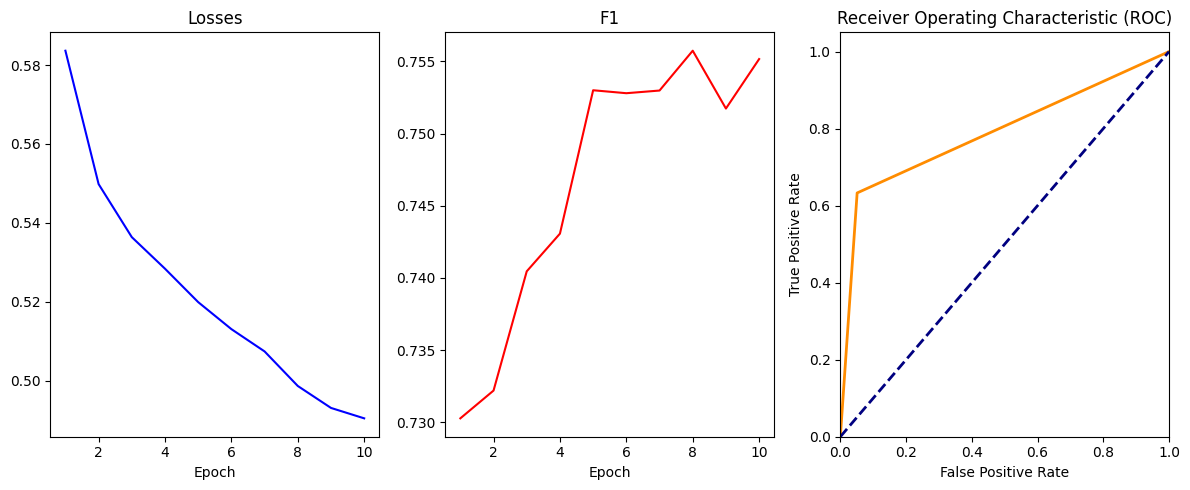

In [60]:
model_lstm_custom = OtchislenieModel_LSTM_CustomStructure(input_size=max_subjects_per_semestr, num_classes = 1).to(device)
criterion = nn.BCELoss()
optimizer = torch.optim.Adam(model_lstm_custom.parameters())

model_lstm_custom = train_model(model_lstm_custom, optimizer, criterion, num_epoch=10)